In [1]:
!pip install umap-learn
import os
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import umap.umap_ as umap
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sys
from sklearn.manifold import TSNE
from torch import Tensor
from typing import Type
import torch.nn.init as init
from google.colab import drive
drive.mount('/content/drive')

# Transformaciones para entrenamiento y validación
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),  # Recorte aleatorio después del padding
    torchvision.transforms.RandomHorizontalFlip(),      # Volteo horizontal aleatorio
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

val_test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

# Cargar datasets CIFAR-10 con transformaciones
train_cifar10 = torchvision.datasets.CIFAR10(
    root="./cifar10",
    train=True,
    download=True,
    transform=train_transform  # Se aplica data augmentation aquí
)

test_cifar10 = torchvision.datasets.CIFAR10(
    root="./cifar10",
    train=False,
    download=True,
    transform=val_test_transform  # Solo normalización para testing
)

# Dividir dataset de entrenamiento y validación
train_cifar10, _ = torch.utils.data.random_split(train_cifar10, [45000, 5000], generator=torch.Generator().manual_seed(42))
_, val_cifar10 = torch.utils.data.random_split(
    torchvision.datasets.CIFAR10(root="./cifar10", train=True, transform=val_test_transform),
    [45000, 5000], generator=torch.Generator().manual_seed(42)
)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.7 MB/s eta 0:00:00
Mounted at /content/drive


100%|██████████| 170M/170M [00:03<00:00, 43.4MB/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


# Resnet Modulo Gen

In [2]:
__all__ = ['resnet68']
def _weights_init(m):
    """
        Initialization of CNN weights
    """
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    """
      Identity mapping between ResNet blocks with diffrenet size feature map
    """
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 experiment, ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)
        self.apply(_weights_init)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        feature_maps['ReLUconv1'] = out
        out = self.layer1(out)
        out = self.layer2(out)
        feature_maps['Layer2'] = out
        out = self.layer3(out)
        feature_maps['Layer3'] = out
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out


## Resnet 68

In [3]:
def resnet68():
    return ResNet(BasicBlock, [11, 11, 11])
model = resnet68()

In [4]:

def show_gradients_ResNet_68(model):
    layers_to_show = ['layer1.0.conv1', 'layer1.0.bn1', 'layer2.2.conv1', 'layer2.2.bn1', 'linear']  # Capas inicial, intermedia y final
    for name, param in model.named_parameters():
        if any(layer in name for layer in layers_to_show) and param.requires_grad and param.grad is not None:
            grad = param.grad.cpu().numpy()
            print(f"Gradientes para {name}: min={grad.min()}, max={grad.max()}, mean={grad.mean()}, std={grad.std()}")
            plt.figure(figsize=(8, 6))
            plt.hist(grad.flatten(), bins=50)
            plt.title(f'Gradientes para {name}')
            plt.xlabel('Valor del gradiente')
            plt.ylabel('Frecuencia')
            plt.show()

In [5]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    # Asegúrate de que los datos estén en la CPU antes de convertirlos a NumPy
    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, np.array(curves['val_loss']), label='validation')
    ax[0].plot(epochs, np.array(curves['train_loss']), label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, np.array(curves['val_acc']), label='validation')
    ax[1].plot(epochs, np.array(curves['train_acc']), label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()

# Visualize feature maps
def show_feature_maps(feature_maps):
    for layer_name, feature_map in feature_maps.items():
        fmap = feature_map[0].cpu().numpy()  # Convert to CPU and NumPy for visualization
        num_feature_maps = fmap.shape[0]

        # Plot a grid of feature maps (first 8 feature maps)
        fig, axes = plt.subplots(1, min(8, num_feature_maps), figsize=(20, 5))
        fig.suptitle(f"Feature Maps from Layer {layer_name}", fontsize=16)

        for i in range(min(8, num_feature_maps)):
            axes[i].imshow(fmap[i], cmap='viridis')
            axes[i].axis('off')

        plt.show()

def checkpoint_save(model, optimizer, epoch, filename):
    checkpoint_data = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint_data, os.path.join(checkpoint_dir, filename))
    print(f"Checkpoint guardado en {os.path.join(checkpoint_dir, filename)}")

def checkpoint_resume(model, optimizer, filename):
    checkpoint_path = os.path.join(checkpoint_dir, filename)
    if os.path.isfile(checkpoint_path):
        checkpoint_data = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint_data['model_state_dict'])
        optimizer.load_state_dict(checkpoint_data['optimizer_state_dict'])
        epoch = checkpoint_data['epoch']
        print(f"Checkpoint cargado desde '{checkpoint_path}' (época {epoch})")
        return epoch
    else:
        print(f"No se encontró ningún checkpoint en '{checkpoint_path}'")
        return None

# Training step function
def train_step(x_batch, y_batch, model, optimizer, criterion, device):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    y_predicted = model(x_batch)
    loss = criterion(y_predicted, y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return y_predicted, loss

# Evaluation function
def evaluate(val_loader, model, criterion, device):
    model.eval()
    cumulative_loss = 0
    cumulative_corrects = 0
    data_count = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            final_output = model(imgs)
            loss = criterion(final_output, labels)
            cumulative_loss += loss.item() * len(labels)
            data_count += len(labels)
            _, pred_class = final_output.max(1)
            cumulative_corrects += (pred_class == labels).sum().item()
    val_acc = cumulative_corrects / data_count
    val_loss = cumulative_loss / data_count
    return val_acc, val_loss

#Segunda Resnet
def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    max_iterations,
    criterion,
    batch_size,
    lr,
    weight_decay,
    n_evaluations_per_epoch,
    early_stop_thresh,  # Early stopping threshold
    show_gradients,
    patience,
    use_gpu=True,
    data_augmentation=False,
    resume_checkpoint=None
):
    original_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])

    if data_augmentation:
        train_dataset.dataset.transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomCrop(32, padding=4),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        ])
    else:
        train_dataset.dataset.transform = original_transform

    print(f"Using train transform: {train_dataset.dataset.transform}")
    print(f"Using validation transform: {val_dataset.dataset.transform}")


    # Usar GPU si está disponible
    device = torch.device('cuda' if use_gpu else 'cpu')
    model = model.to(device)

    # DataLoaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4,pin_memory=use_gpu)

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, threshold=0.0001, threshold_mode='abs')
    scaler = torch.amp.GradScaler()

    curves = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}
    t0 = time.perf_counter()
    iteration = 0
    n_batches = len(train_loader)
    start_epoch = 0
    if resume_checkpoint is not None:
        start_epoch = checkpoint_resume(model, optimizer, resume_checkpoint)
        print(f"Reanudando desde la época {start_epoch}")

    best_val_loss = float('inf')
    best_epoch = -1
    early_stop_counter = 0

    for epoch in range(start_epoch, epochs):
        print(optimizer.param_groups[0]["lr"])
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, device)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]

            # Accuracy calculation
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()


            # Registro de métricas
            if (i + 1) % (n_batches // n_evaluations_per_epoch) == 0:
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count

                print(
                    f"Iteración {iteration + 1} - Lote {i + 1}/{n_batches} - "
                    f"Pérdida de Entrenamiento: {train_loss:.4f}, Precisión de Entrenamiento: {train_acc:.4f}"
                )


            iteration += 1
            if iteration >= max_iterations:
                print(f"Número máximo de iteraciones alcanzado: {max_iterations}")
                break

        val_acc, val_loss = evaluate(val_loader, model, criterion, device)
        print(f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)
        scheduler.step(val_loss)

        # Checkpointing the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            early_stop_counter = 0
            checkpoint_filename = f"best_checkpoint_epoch_{epoch + 1}.pth"
            checkpoint_save(model, optimizer, epoch, checkpoint_filename)
            print(f"Checkpoint del mejor modelo guardado en la época {epoch + 1}")
        else:
            early_stop_counter += 1

        if epoch + 1 == 1 or (epoch + 1) % 5 == 0 or early_stop_counter >= early_stop_thresh:
            show_gradients(model)
            show_feature_maps(feature_maps)

        if early_stop_counter >= early_stop_thresh:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        if iteration >= max_iterations:
            break

    total_time = time.perf_counter() - t0
    print(f"\nTiempo total de entrenamiento: {total_time:.2f} segundos")

    # Ensure the model is on CPU after training
    model.cpu()

    if data_augmentation:
        train_dataset.dataset.transform = original_transform

    return curves

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Iteración 35 - Lote 35/352 - Pérdida de Entrenamiento: 4.6569, Precisión de Entrenamiento: 0.1121
Iteración 70 - Lote 70/352 - Pérdida de Entrenamiento: 3.4672, Precisión de Entrenamiento: 0.1324
Iteración 105 - Lote 105/352 - Pérdida de Entrenamiento: 3.0052, Precisión de Entrenamiento: 0.1600
Iteración 140 - Lote 140/352 - Pérdida de Entrenamiento: 2.7516, Precisión de Entrenamiento: 0.1815
Iteración 175 - Lote 175/352 - Pérdida de Entrenamiento: 2.5801, Precisión de Entrenamiento: 0.2021
Iteración 210 - Lote 210/352 - Pérdida de Entrenamiento: 2.4553, Precisión de Entrenamiento: 0.2195
Iteración 245 - Lote 245/352 - Pérdida de Entrenamiento: 2.3552, Precisión de Entrenamiento: 0.2356
Iteración 280 - Lote 280/352 - Pérdida de Entrenamiento: 2.2801, Precisión de Entrenamiento: 0.2489
Iteración 315 - Lote 315/352 - Pérdida de Entrenamiento: 2.2121, Precisión de Entrenamiento: 0.2626
Iteración 350 - Lote 350/352 - Pérdida de Entrenamiento: 2.1577, Precisión de Entrenamiento: 0.2740
Val 

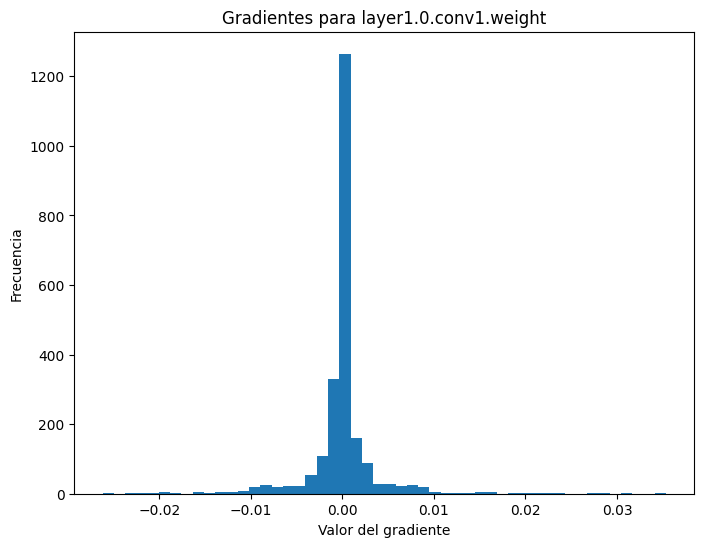

Gradientes para layer1.0.bn1.weight: min=-0.01692815124988556, max=0.015785176306962967, mean=-2.6824185624718666e-05, std=0.00957409292459488


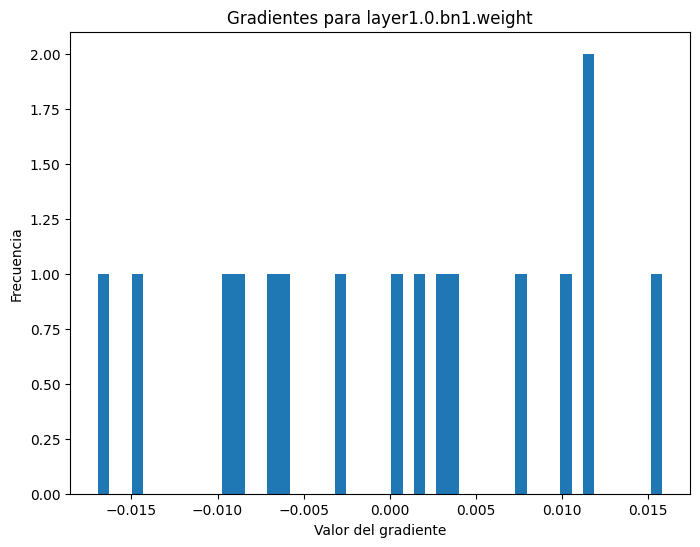

Gradientes para layer1.0.bn1.bias: min=-0.021227344870567322, max=0.020874973386526108, mean=0.00039998232387006283, std=0.010989541187882423


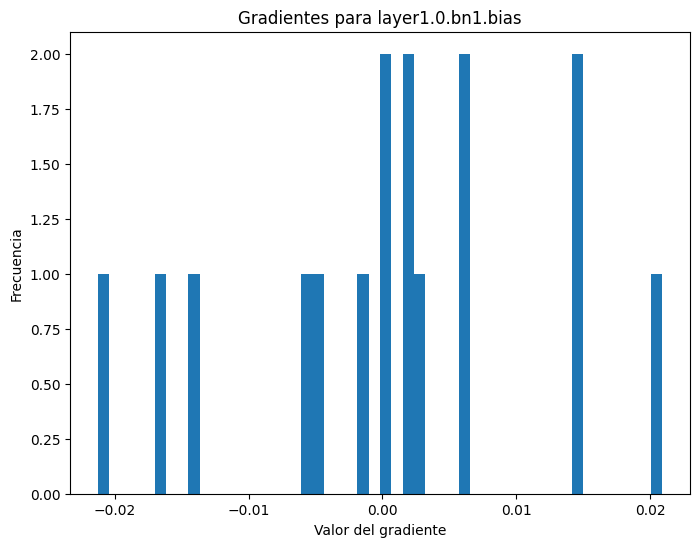

Gradientes para layer2.2.conv1.weight: min=-0.014920325949788094, max=0.014488393440842628, mean=-5.2955532737541944e-05, std=0.0015296787023544312


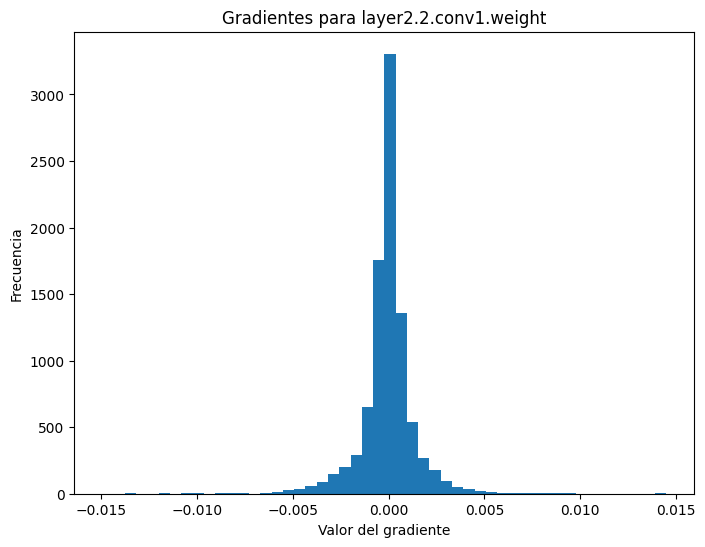

Gradientes para layer2.2.bn1.weight: min=-0.005065999459475279, max=0.003747035516425967, mean=2.140150172635913e-07, std=0.002025013556703925


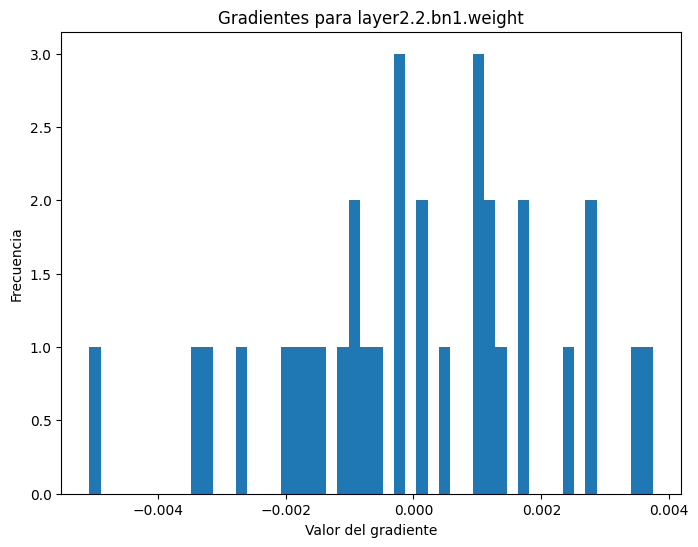

Gradientes para layer2.2.bn1.bias: min=-0.007611854933202267, max=0.008091799914836884, mean=-0.0003293952322565019, std=0.003260224126279354


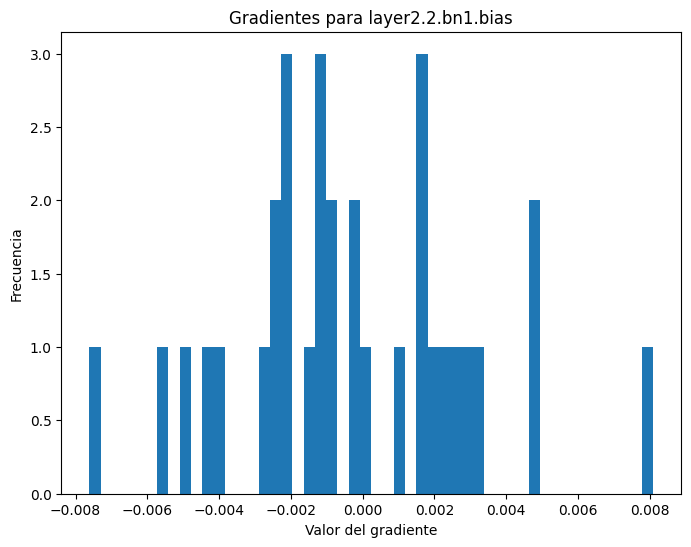

Gradientes para linear.weight: min=-0.10095494240522385, max=0.12516045570373535, mean=9.313225884932663e-11, std=0.024306142702698708


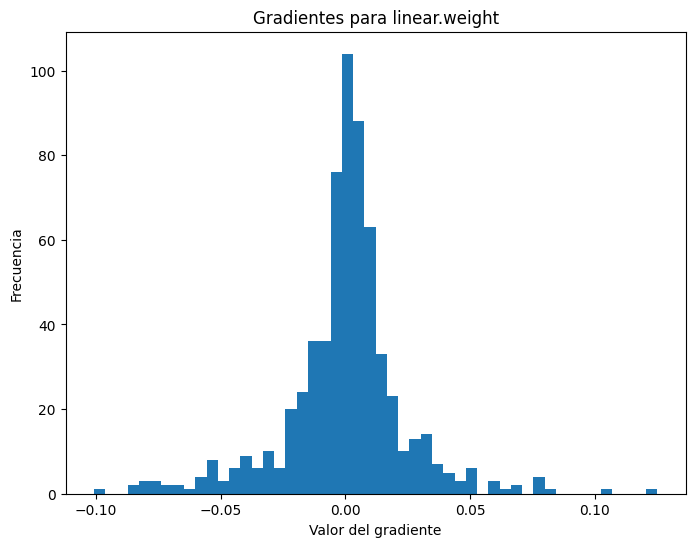

Gradientes para linear.bias: min=-0.06331643462181091, max=0.05666297674179077, mean=5.587935669737476e-10, std=0.034890469163656235


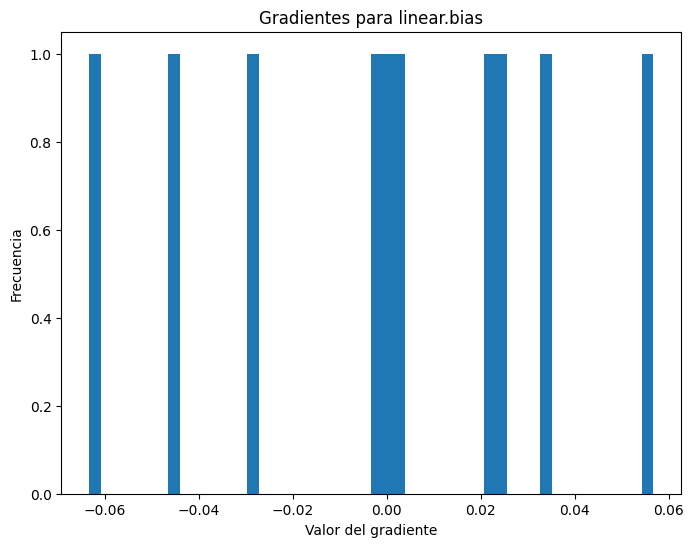

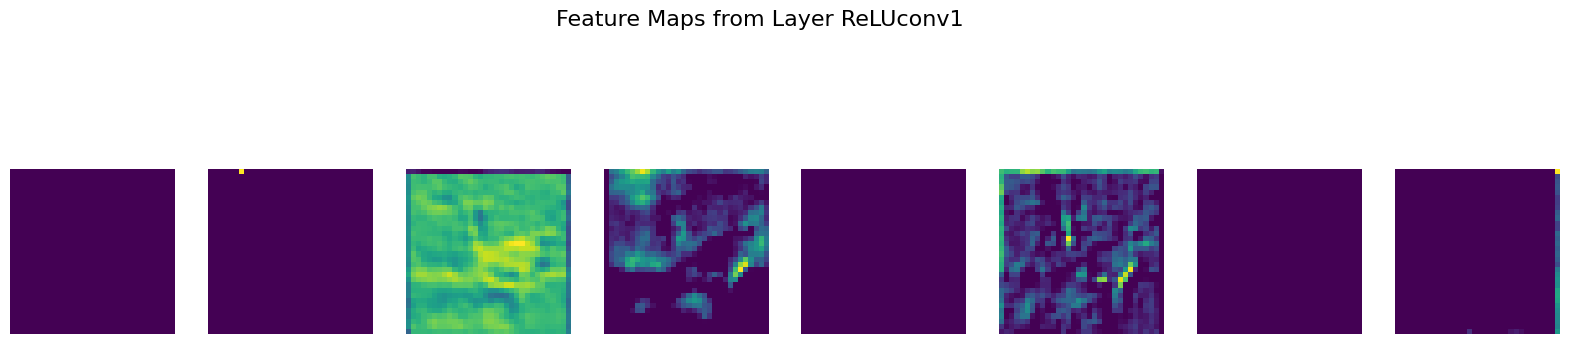

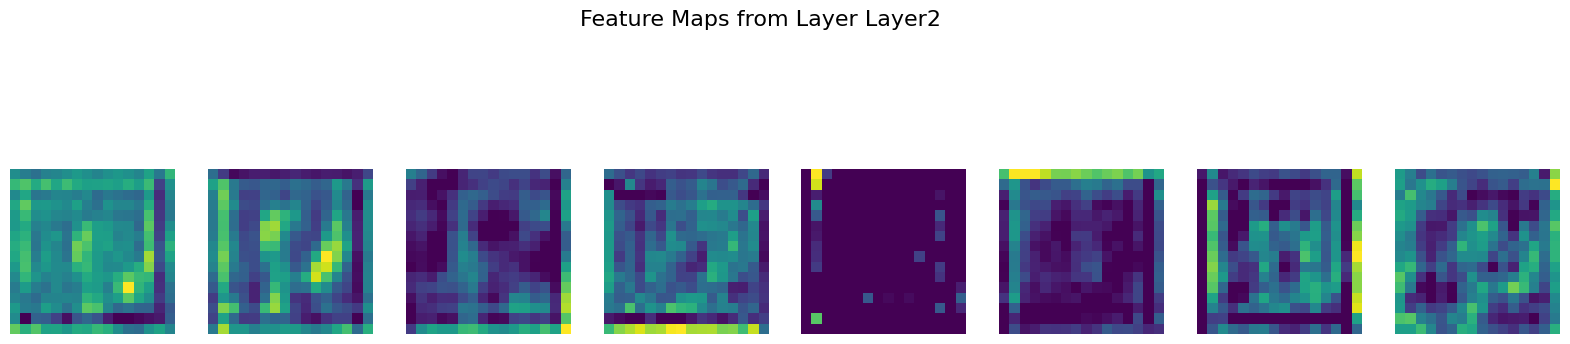

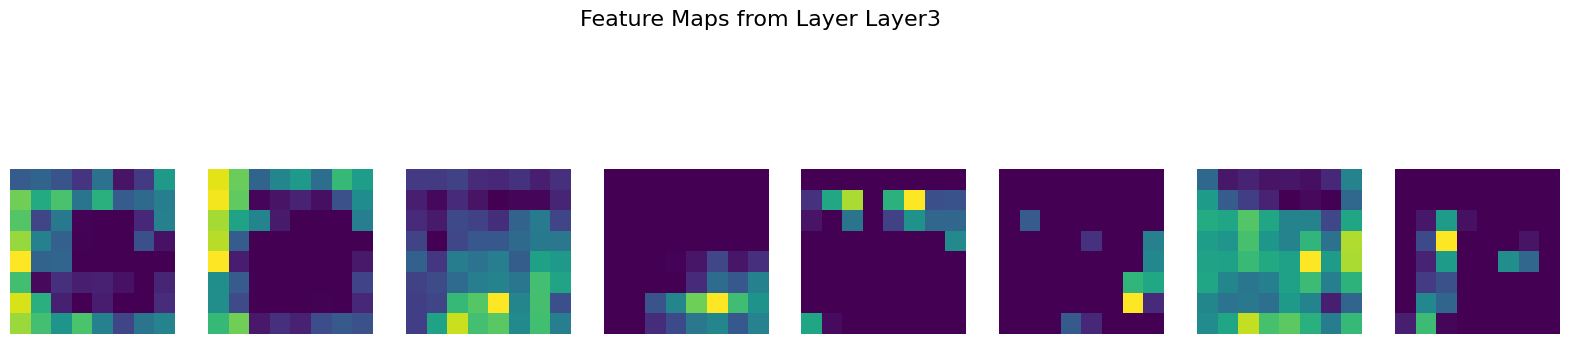

0.04
Epoch 2/70
Iteración 387 - Lote 35/352 - Pérdida de Entrenamiento: 1.6232, Precisión de Entrenamiento: 0.4007
Iteración 422 - Lote 70/352 - Pérdida de Entrenamiento: 1.6143, Precisión de Entrenamiento: 0.4012
Iteración 457 - Lote 105/352 - Pérdida de Entrenamiento: 1.5976, Precisión de Entrenamiento: 0.4093
Iteración 492 - Lote 140/352 - Pérdida de Entrenamiento: 1.5781, Precisión de Entrenamiento: 0.4164
Iteración 527 - Lote 175/352 - Pérdida de Entrenamiento: 1.5606, Precisión de Entrenamiento: 0.4221
Iteración 562 - Lote 210/352 - Pérdida de Entrenamiento: 1.5459, Precisión de Entrenamiento: 0.4258
Iteración 597 - Lote 245/352 - Pérdida de Entrenamiento: 1.5327, Precisión de Entrenamiento: 0.4316
Iteración 632 - Lote 280/352 - Pérdida de Entrenamiento: 1.5184, Precisión de Entrenamiento: 0.4390
Iteración 667 - Lote 315/352 - Pérdida de Entrenamiento: 1.5058, Precisión de Entrenamiento: 0.4446
Iteración 702 - Lote 350/352 - Pérdida de Entrenamiento: 1.4899, Precisión de Entrenam

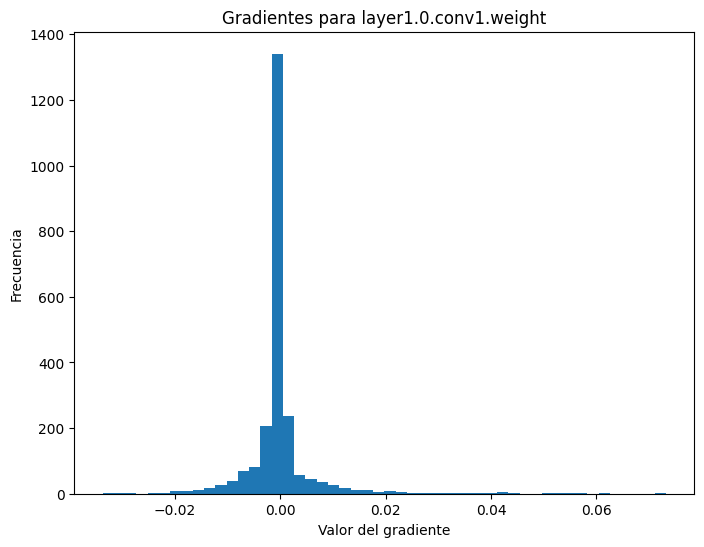

Gradientes para layer1.0.bn1.weight: min=-0.02898492105305195, max=0.028480807319283485, mean=-0.00181487831287086, std=0.014731201343238354


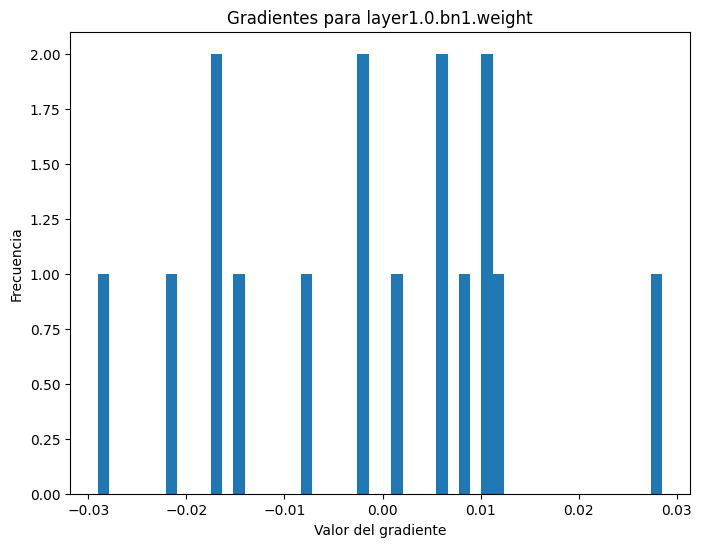

Gradientes para layer1.0.bn1.bias: min=-0.02361143007874489, max=0.03627198934555054, mean=0.006477915681898594, std=0.01762709580361843


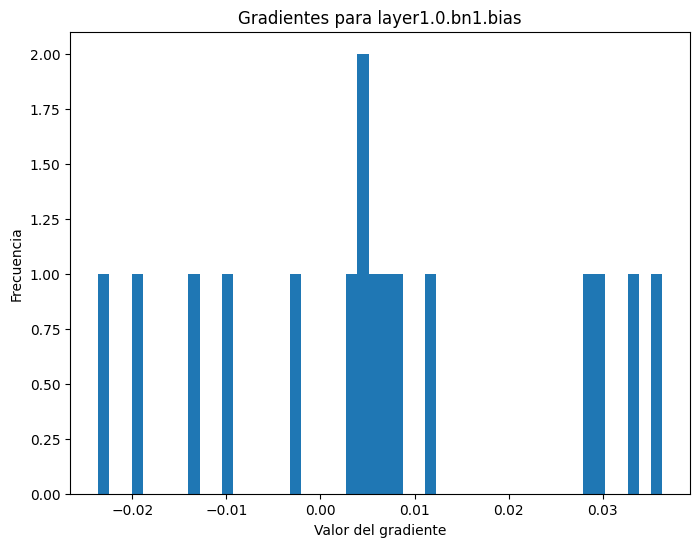

Gradientes para layer2.2.conv1.weight: min=-0.017407510429620743, max=0.016778571531176567, mean=0.00020685272465925664, std=0.0020558685064315796


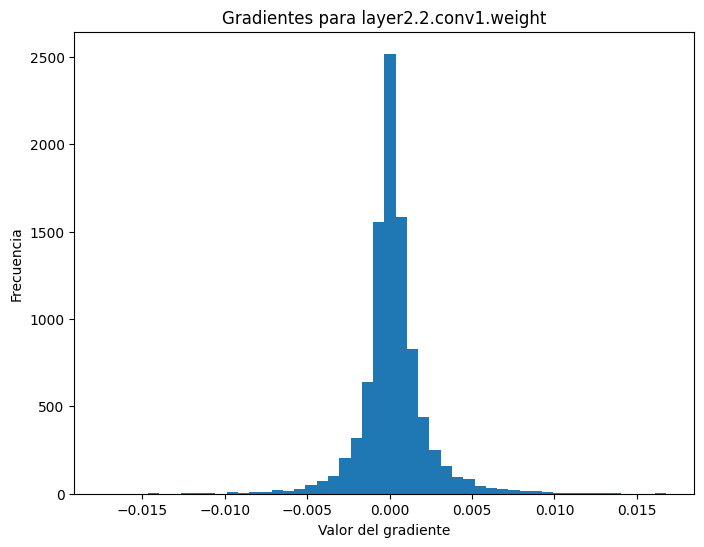

Gradientes para layer2.2.bn1.weight: min=-0.010129394009709358, max=0.011639340780675411, mean=-5.2073010010644794e-05, std=0.003950709477066994


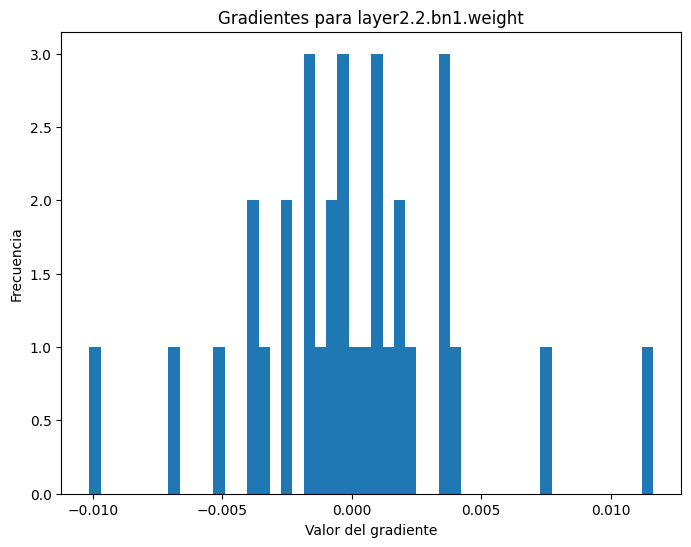

Gradientes para layer2.2.bn1.bias: min=-0.006763338111341, max=0.004607516806572676, mean=-0.000775368302129209, std=0.003044497687369585


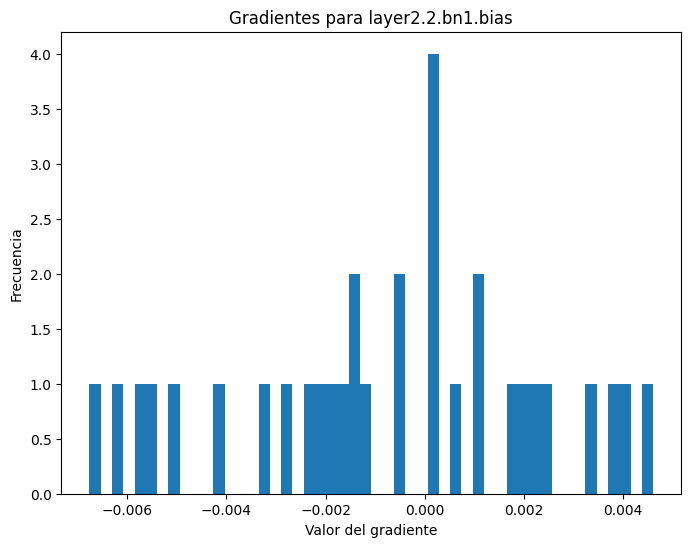

Gradientes para linear.weight: min=-0.11163464933633804, max=0.10599427670240402, mean=4.656612873077393e-10, std=0.023122340440750122


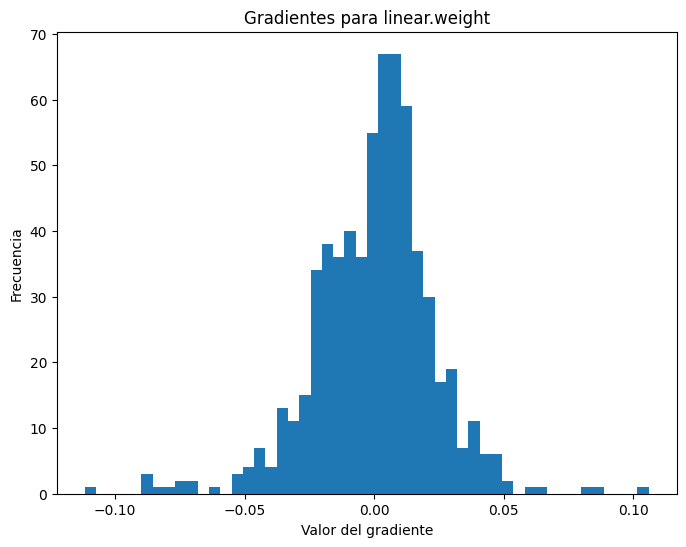

Gradientes para linear.bias: min=-0.043961767107248306, max=0.04175136983394623, mean=1.3038515822572094e-09, std=0.02690306305885315


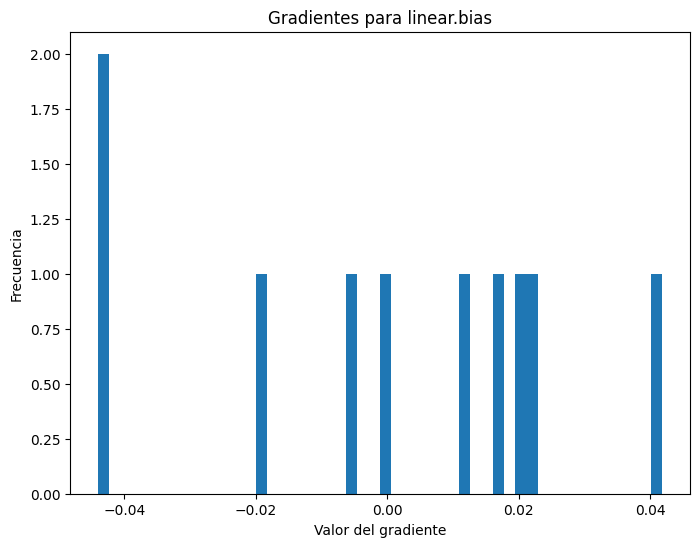

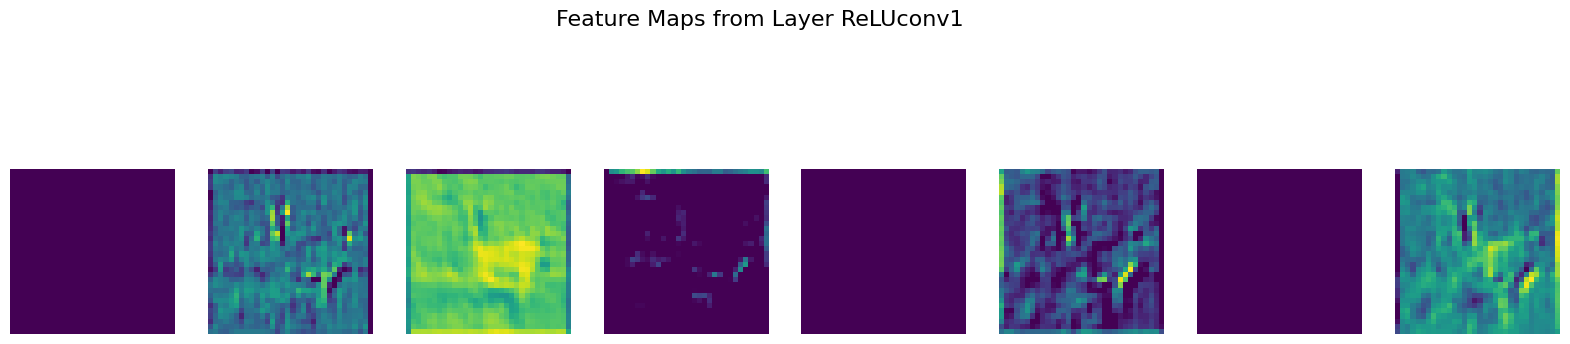

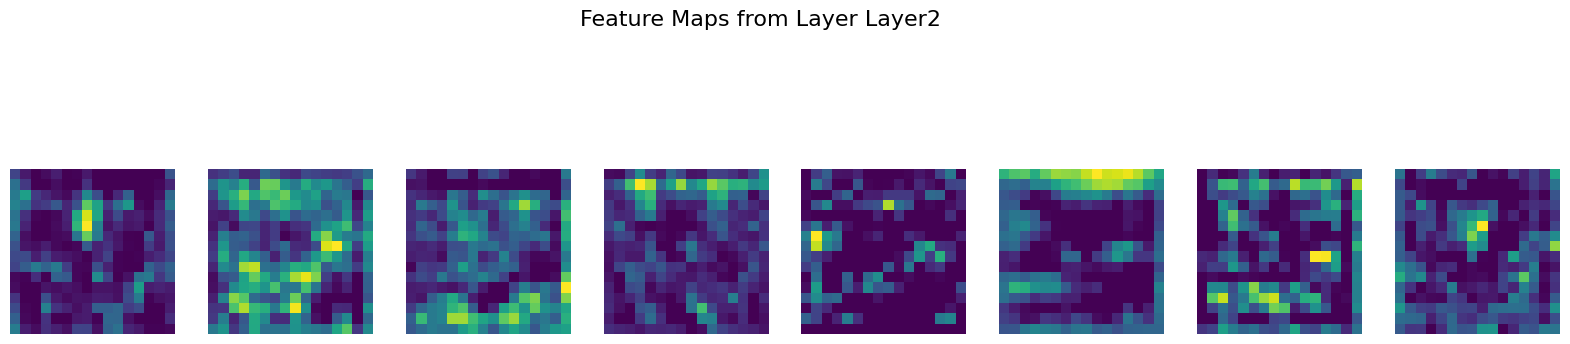

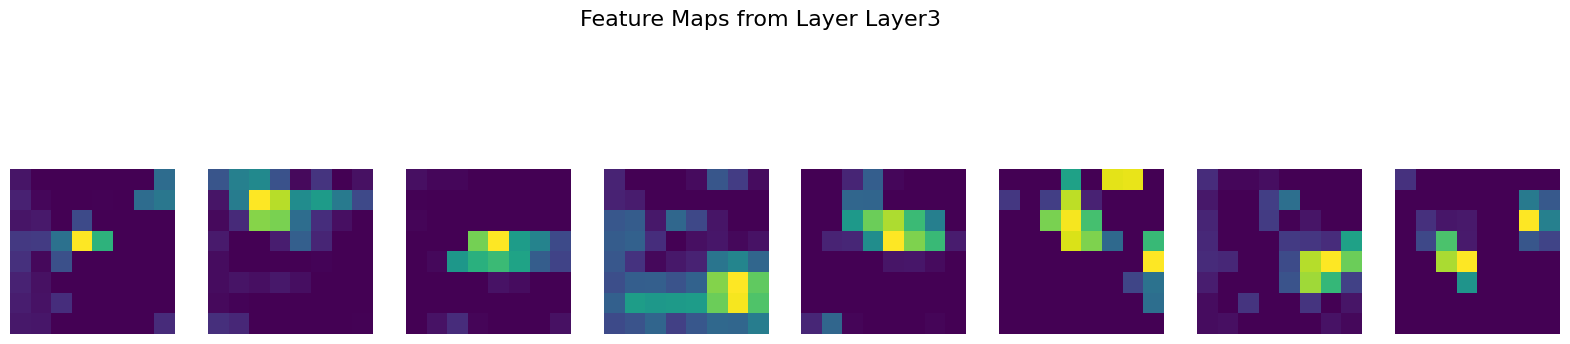

0.04
Epoch 6/70
Iteración 1795 - Lote 35/352 - Pérdida de Entrenamiento: 0.7903, Precisión de Entrenamiento: 0.7212
Iteración 1830 - Lote 70/352 - Pérdida de Entrenamiento: 0.8251, Precisión de Entrenamiento: 0.7128
Iteración 1865 - Lote 105/352 - Pérdida de Entrenamiento: 0.8334, Precisión de Entrenamiento: 0.7092
Iteración 1900 - Lote 140/352 - Pérdida de Entrenamiento: 0.8309, Precisión de Entrenamiento: 0.7104
Iteración 1935 - Lote 175/352 - Pérdida de Entrenamiento: 0.8248, Precisión de Entrenamiento: 0.7113
Iteración 1970 - Lote 210/352 - Pérdida de Entrenamiento: 0.8239, Precisión de Entrenamiento: 0.7100
Iteración 2005 - Lote 245/352 - Pérdida de Entrenamiento: 0.8222, Precisión de Entrenamiento: 0.7103
Iteración 2040 - Lote 280/352 - Pérdida de Entrenamiento: 0.8172, Precisión de Entrenamiento: 0.7118
Iteración 2075 - Lote 315/352 - Pérdida de Entrenamiento: 0.8143, Precisión de Entrenamiento: 0.7135
Iteración 2110 - Lote 350/352 - Pérdida de Entrenamiento: 0.8096, Precisión d

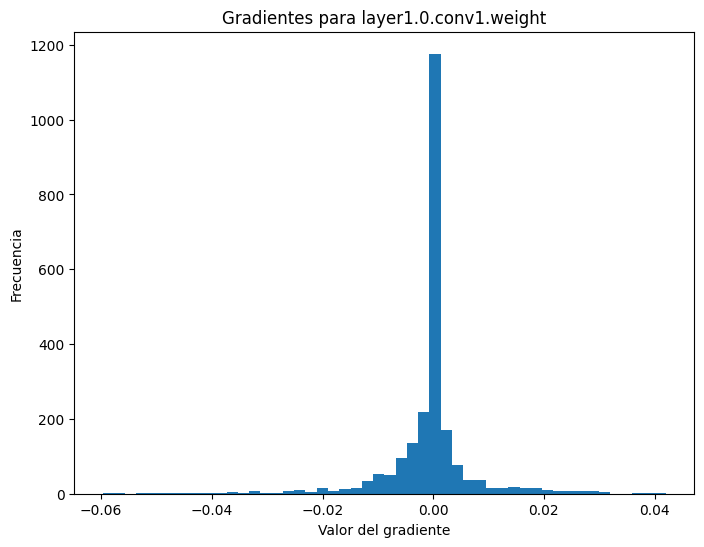

Gradientes para layer1.0.bn1.weight: min=-0.03813667222857475, max=0.04212058335542679, mean=0.005043239798396826, std=0.02378464862704277


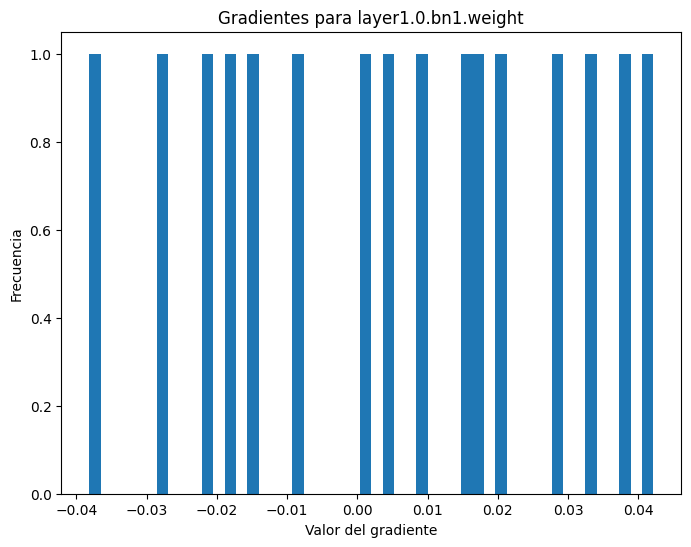

Gradientes para layer1.0.bn1.bias: min=-0.019319472834467888, max=0.021618420258164406, mean=0.006613770499825478, std=0.012327679432928562


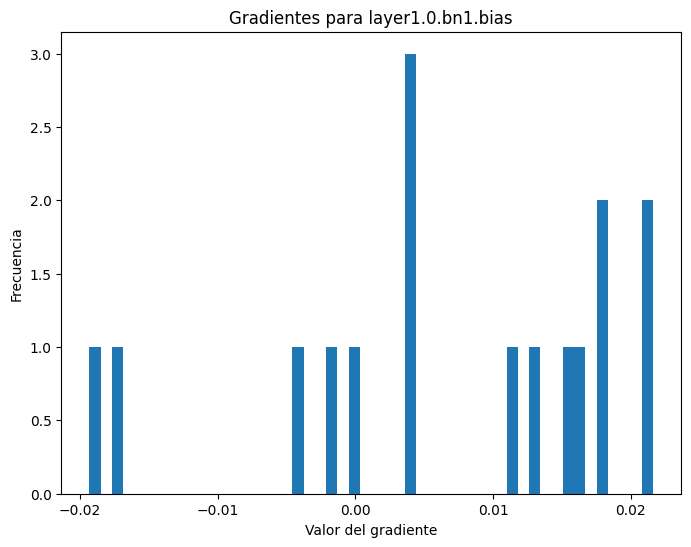

Gradientes para layer2.2.conv1.weight: min=-0.01923268660902977, max=0.020098360255360603, mean=-4.374631680548191e-05, std=0.00258568674325943


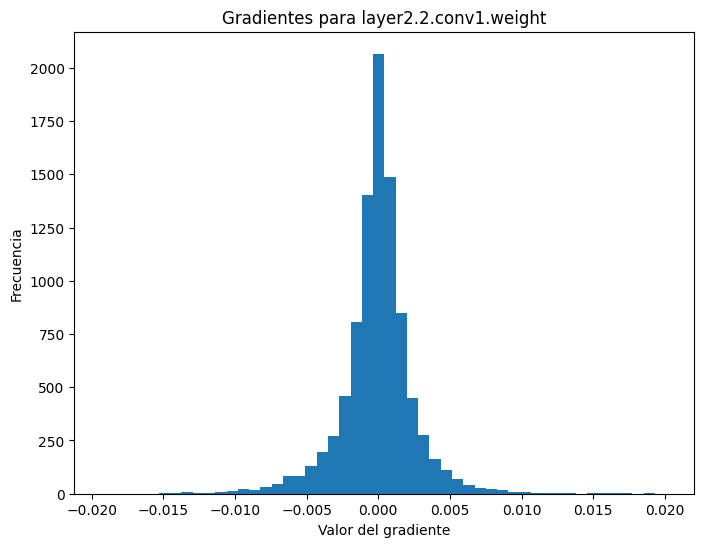

Gradientes para layer2.2.bn1.weight: min=-0.010478038340806961, max=0.010404994711279869, mean=-6.682821549475193e-06, std=0.0057301647029817104


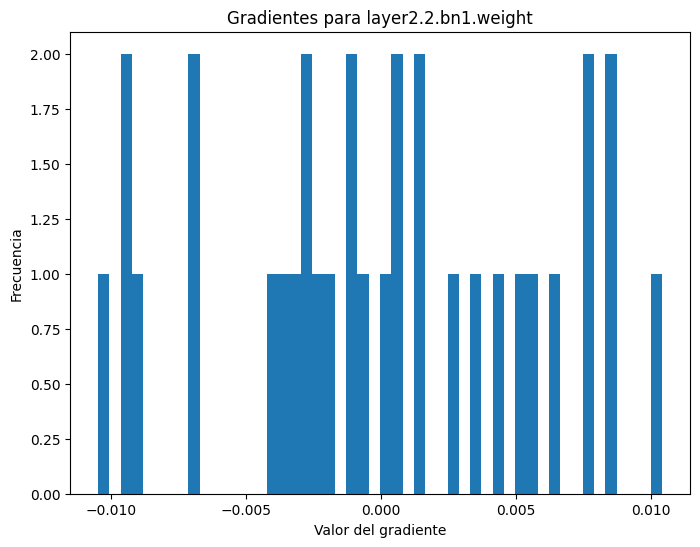

Gradientes para layer2.2.bn1.bias: min=-0.009625055827200413, max=0.010120190680027008, mean=0.00010868129902519286, std=0.004934527445584536


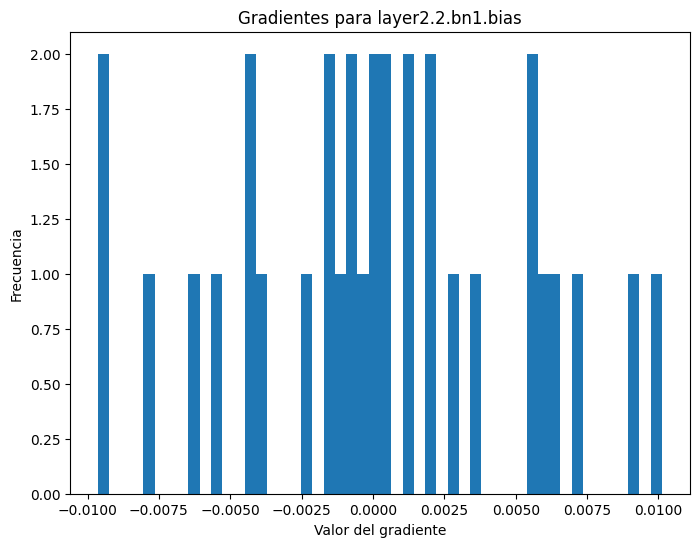

Gradientes para linear.weight: min=-0.19657325744628906, max=0.20431947708129883, mean=3.7252903539730653e-10, std=0.04121799394488335


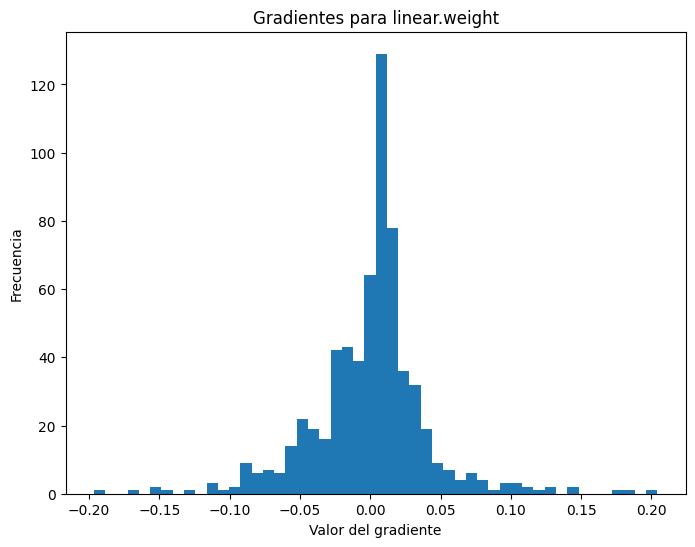

Gradientes para linear.bias: min=-0.09880734980106354, max=0.08207009732723236, mean=-3.7252903539730653e-10, std=0.05077269673347473


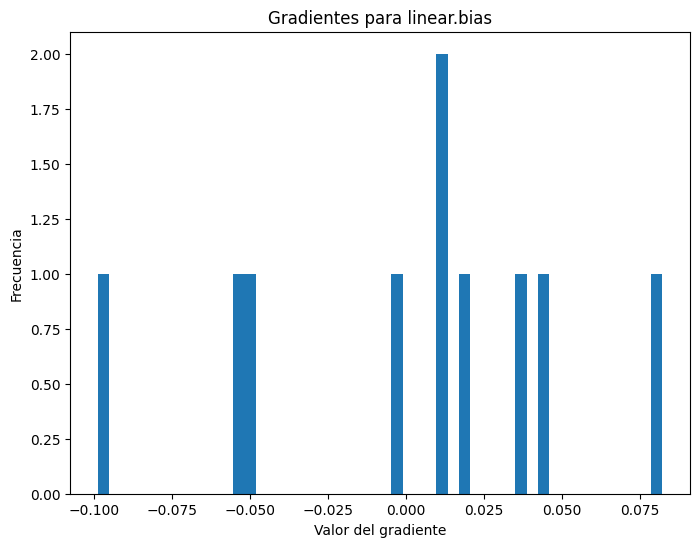

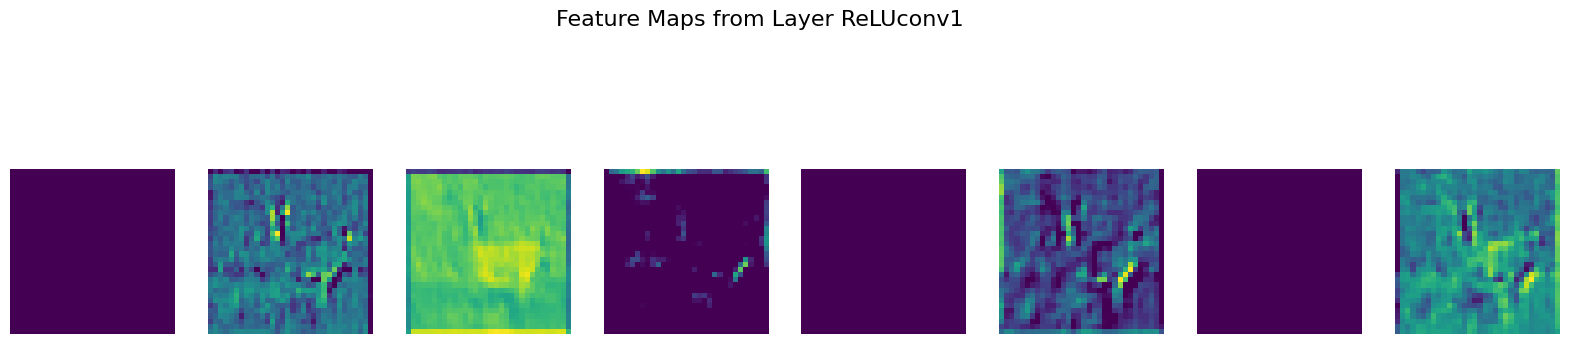

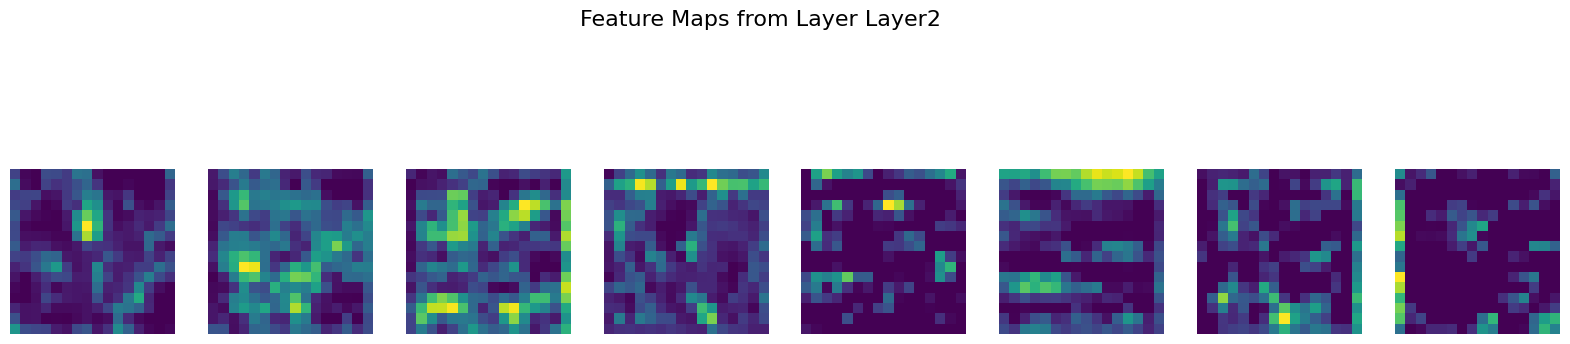

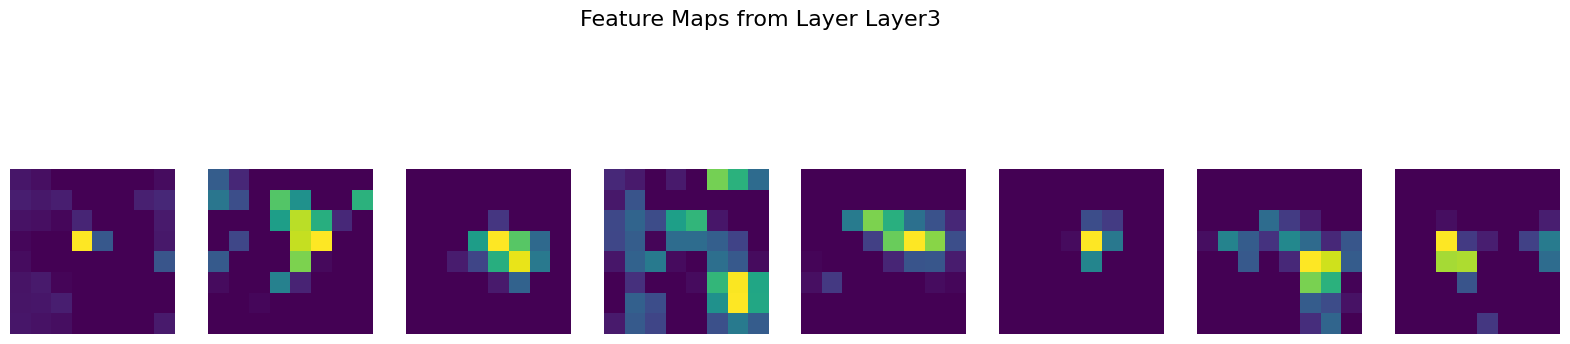

0.04
Epoch 11/70
Iteración 3555 - Lote 35/352 - Pérdida de Entrenamiento: 0.5442, Precisión de Entrenamiento: 0.8145
Iteración 3590 - Lote 70/352 - Pérdida de Entrenamiento: 0.5502, Precisión de Entrenamiento: 0.8138
Iteración 3625 - Lote 105/352 - Pérdida de Entrenamiento: 0.5527, Precisión de Entrenamiento: 0.8124
Iteración 3660 - Lote 140/352 - Pérdida de Entrenamiento: 0.5539, Precisión de Entrenamiento: 0.8106
Iteración 3695 - Lote 175/352 - Pérdida de Entrenamiento: 0.5527, Precisión de Entrenamiento: 0.8094
Iteración 3730 - Lote 210/352 - Pérdida de Entrenamiento: 0.5557, Precisión de Entrenamiento: 0.8078
Iteración 3765 - Lote 245/352 - Pérdida de Entrenamiento: 0.5523, Precisión de Entrenamiento: 0.8082
Iteración 3800 - Lote 280/352 - Pérdida de Entrenamiento: 0.5561, Precisión de Entrenamiento: 0.8076
Iteración 3835 - Lote 315/352 - Pérdida de Entrenamiento: 0.5554, Precisión de Entrenamiento: 0.8072
Iteración 3870 - Lote 350/352 - Pérdida de Entrenamiento: 0.5516, Precisión 

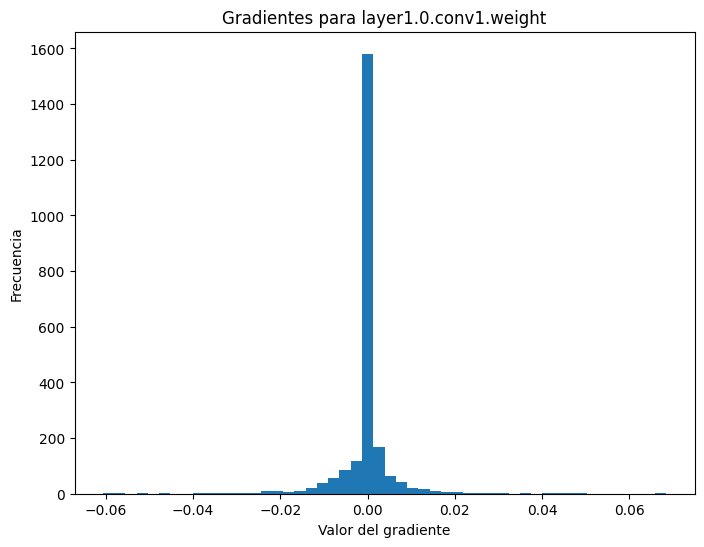

Gradientes para layer1.0.bn1.weight: min=-0.019426945596933365, max=0.020305754616856575, mean=-0.0011526705930009484, std=0.011702076531946659


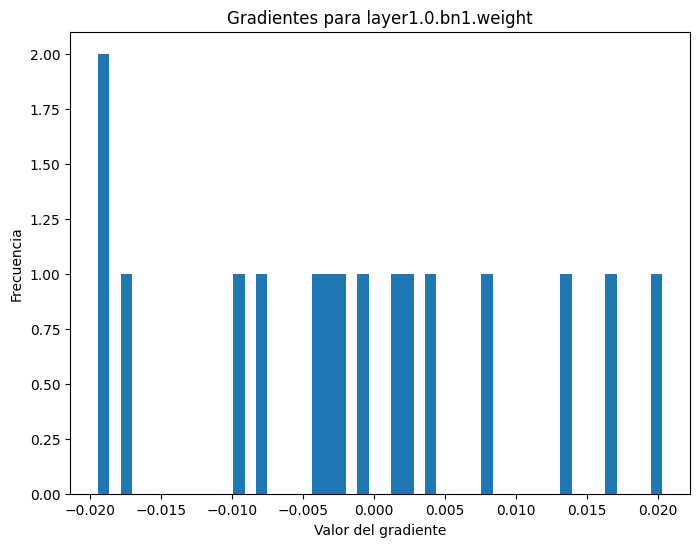

Gradientes para layer1.0.bn1.bias: min=-0.02567591704428196, max=0.04262836277484894, mean=0.0029591687489300966, std=0.017562871798872948


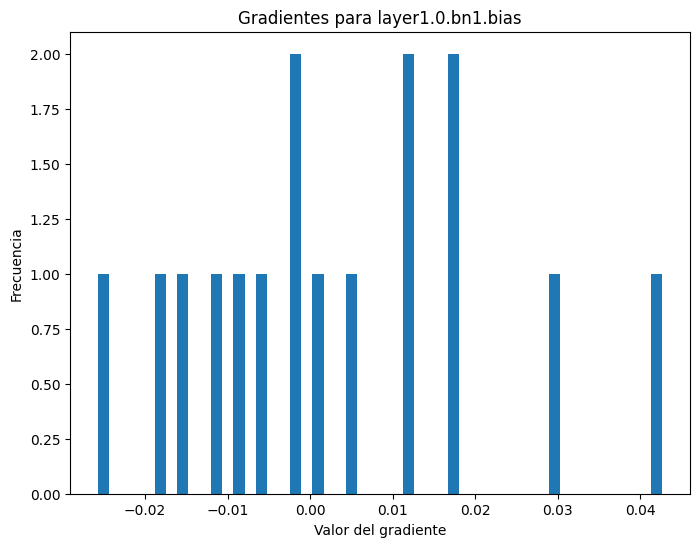

Gradientes para layer2.2.conv1.weight: min=-0.014633845537900925, max=0.013565890491008759, mean=-2.4326103812200017e-05, std=0.0017666617641225457


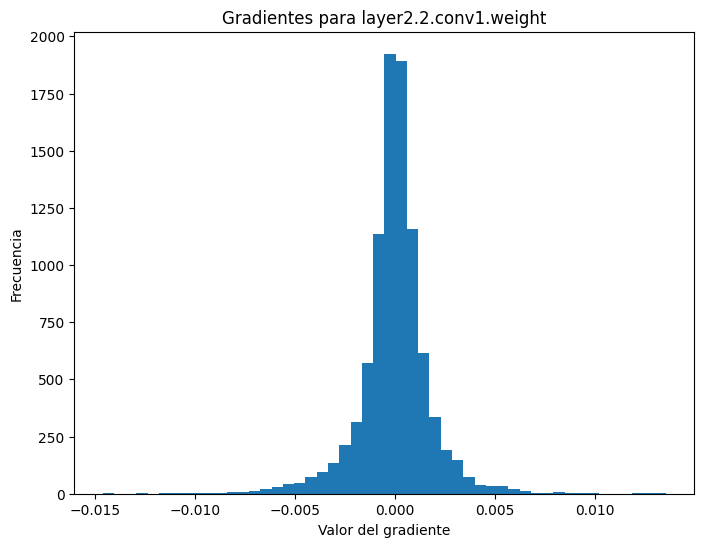

Gradientes para layer2.2.bn1.weight: min=-0.011456158943474293, max=0.010242916643619537, mean=0.00039135414408519864, std=0.004809906240552664


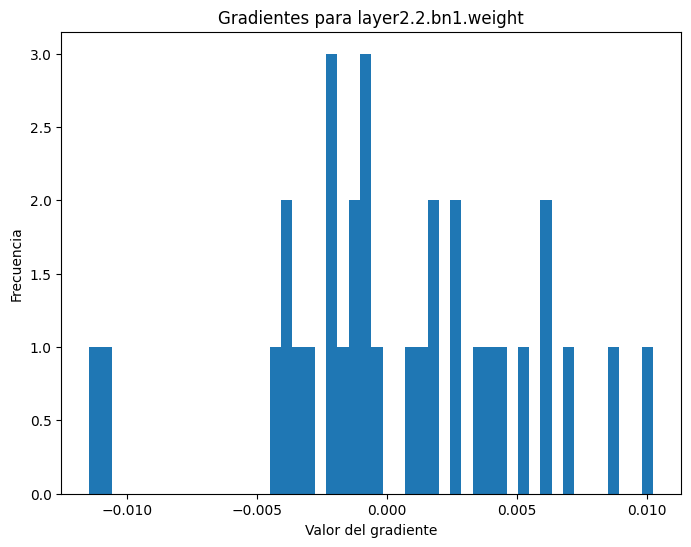

Gradientes para layer2.2.bn1.bias: min=-0.005375147797167301, max=0.007467188872396946, mean=0.00029152733623050153, std=0.003079855814576149


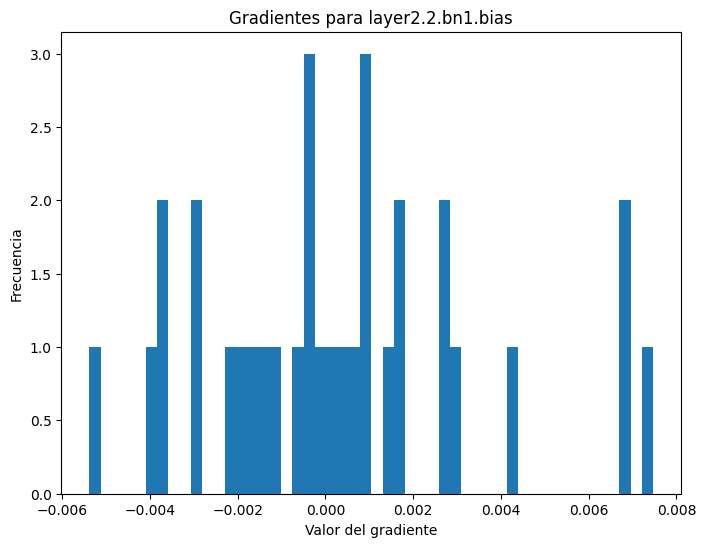

Gradientes para linear.weight: min=-0.07124730944633484, max=0.08323002606630325, mean=3.7252903539730653e-10, std=0.016008570790290833


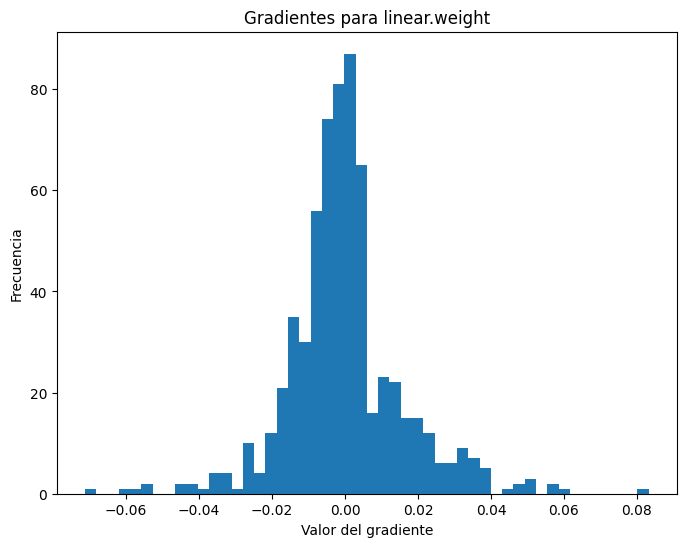

Gradientes para linear.bias: min=-0.03213411942124367, max=0.04745647311210632, mean=-4.190951474747351e-10, std=0.02322004921734333


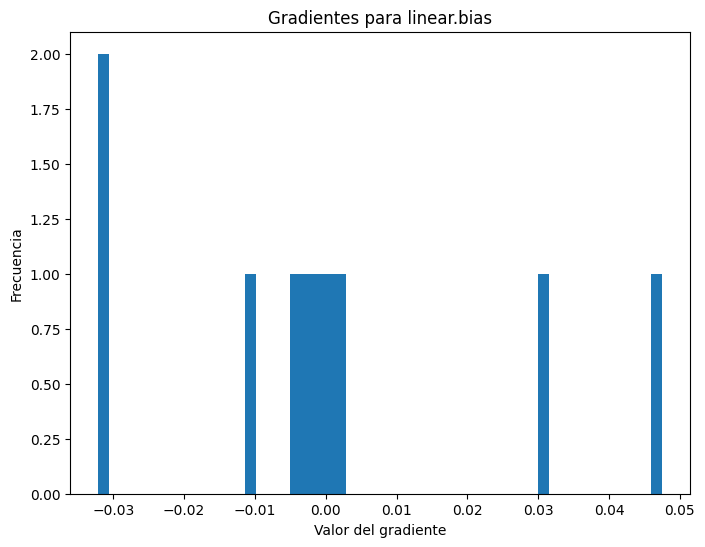

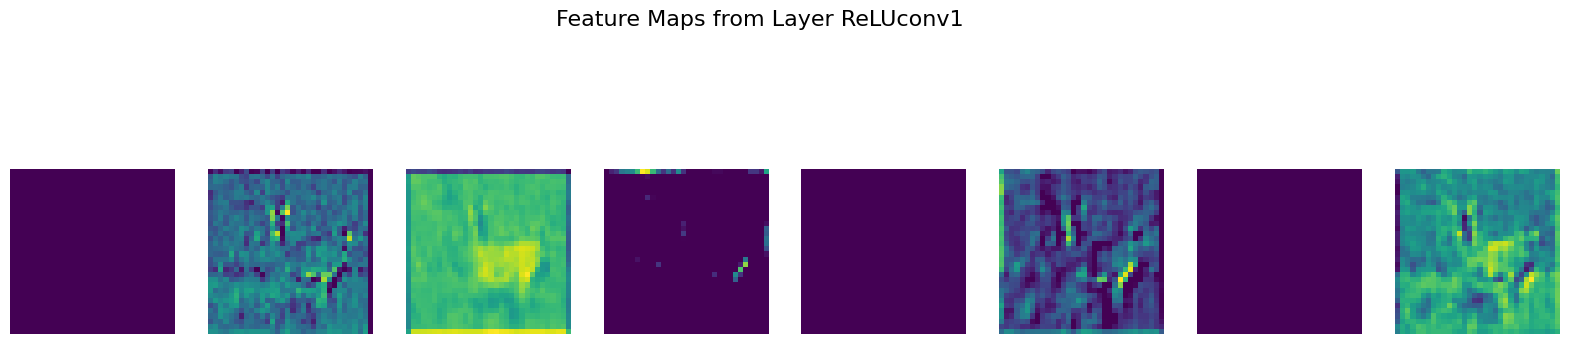

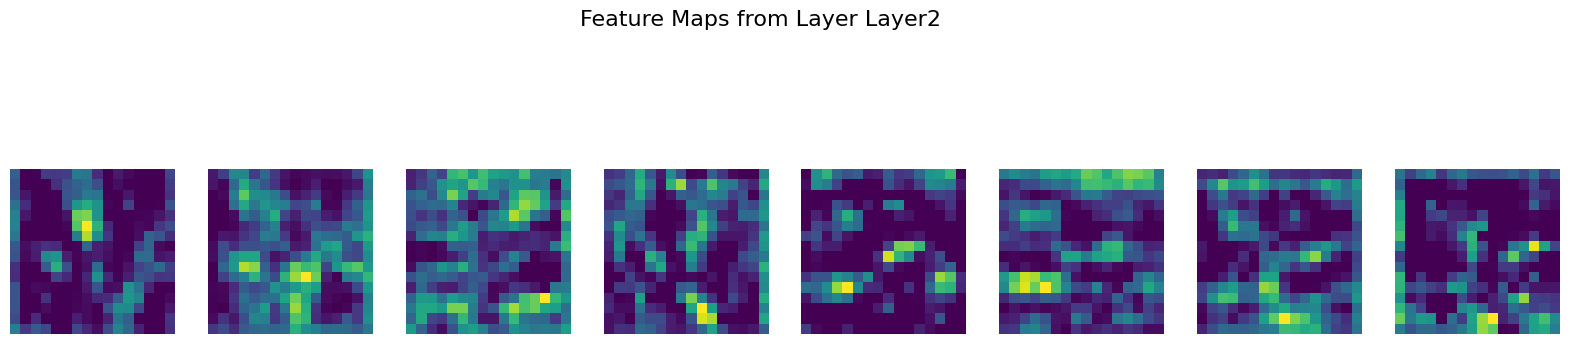

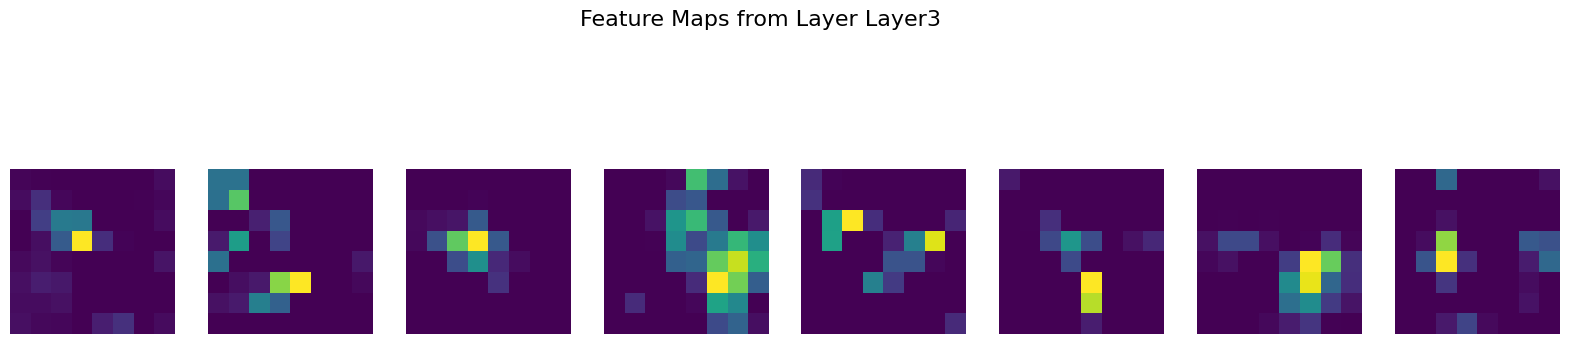

0.04
Epoch 16/70
Iteración 5315 - Lote 35/352 - Pérdida de Entrenamiento: 0.3994, Precisión de Entrenamiento: 0.8618
Iteración 5350 - Lote 70/352 - Pérdida de Entrenamiento: 0.3956, Precisión de Entrenamiento: 0.8608
Iteración 5385 - Lote 105/352 - Pérdida de Entrenamiento: 0.4004, Precisión de Entrenamiento: 0.8600
Iteración 5420 - Lote 140/352 - Pérdida de Entrenamiento: 0.4029, Precisión de Entrenamiento: 0.8593
Iteración 5455 - Lote 175/352 - Pérdida de Entrenamiento: 0.4065, Precisión de Entrenamiento: 0.8579
Iteración 5490 - Lote 210/352 - Pérdida de Entrenamiento: 0.4065, Precisión de Entrenamiento: 0.8577
Iteración 5525 - Lote 245/352 - Pérdida de Entrenamiento: 0.4112, Precisión de Entrenamiento: 0.8565
Iteración 5560 - Lote 280/352 - Pérdida de Entrenamiento: 0.4162, Precisión de Entrenamiento: 0.8541
Iteración 5595 - Lote 315/352 - Pérdida de Entrenamiento: 0.4166, Precisión de Entrenamiento: 0.8542
Iteración 5630 - Lote 350/352 - Pérdida de Entrenamiento: 0.4159, Precisión 

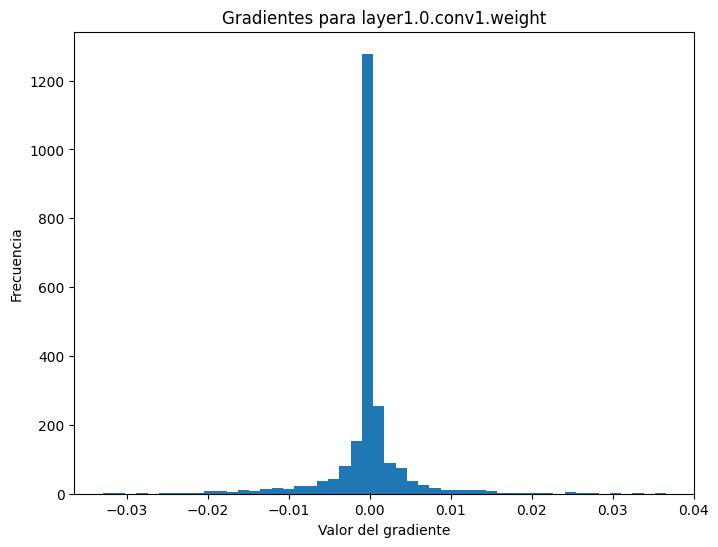

Gradientes para layer1.0.bn1.weight: min=-0.034993868321180344, max=0.021887281909585, mean=-0.0016701365821063519, std=0.016608979552984238


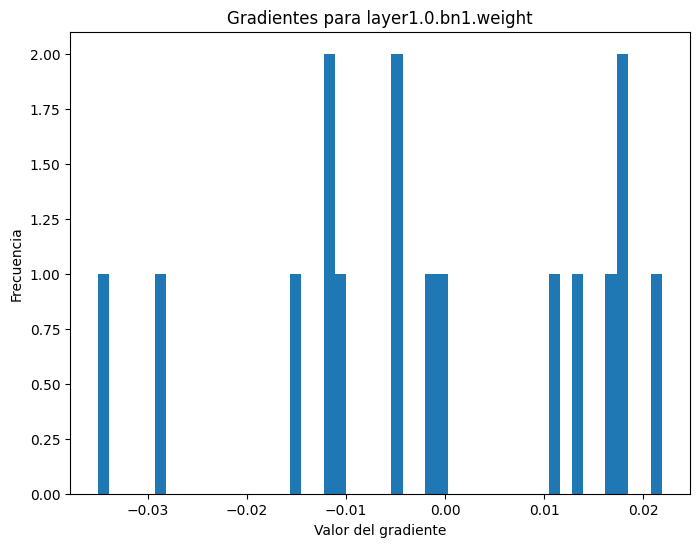

Gradientes para layer1.0.bn1.bias: min=-0.03648495674133301, max=0.046249620616436005, mean=0.0019091070862486959, std=0.021934598684310913


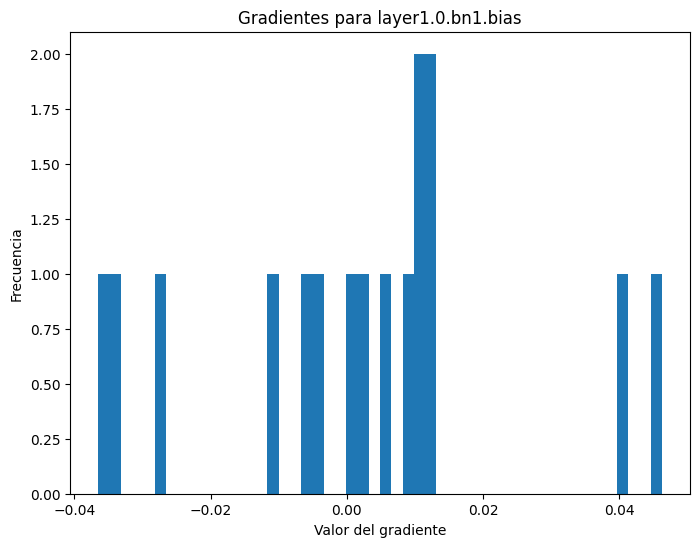

Gradientes para layer2.2.conv1.weight: min=-0.013672346249222755, max=0.0144231291487813, mean=-9.97857659967849e-06, std=0.0021179988980293274


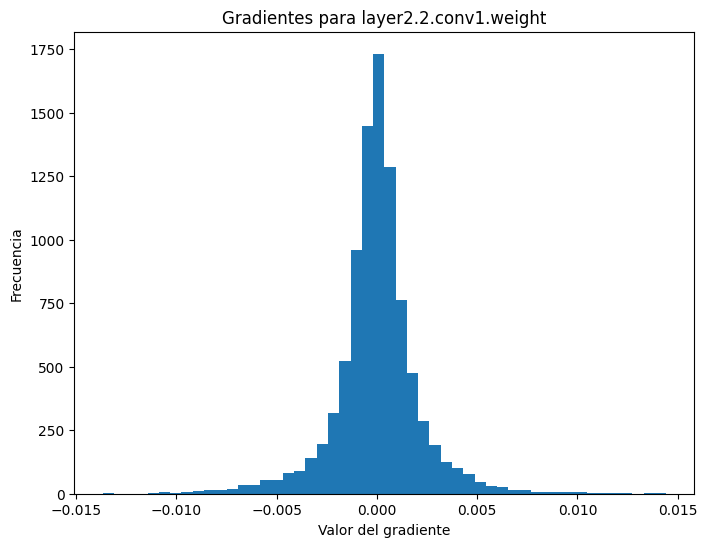

Gradientes para layer2.2.bn1.weight: min=-0.0158227551728487, max=0.014674028381705284, mean=-3.0942901503294706e-06, std=0.006497546564787626


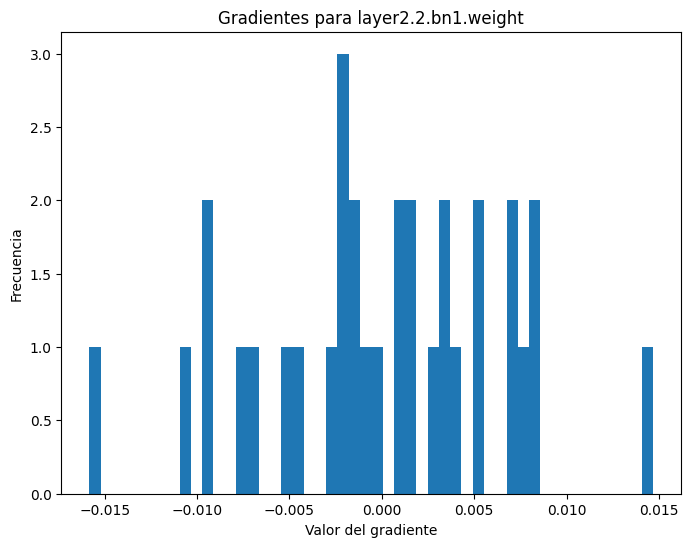

Gradientes para layer2.2.bn1.bias: min=-0.011675736866891384, max=0.012764816172420979, mean=-0.0005402392707765102, std=0.004941495135426521


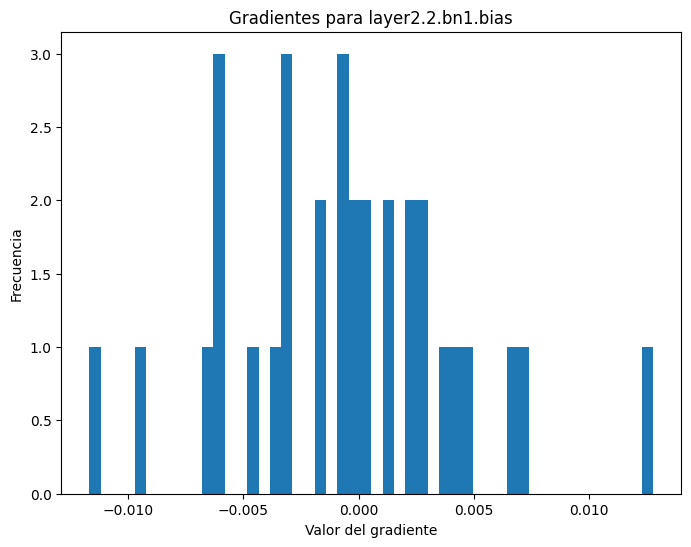

Gradientes para linear.weight: min=-0.10025639832019806, max=0.06642626225948334, mean=7.450580707946131e-10, std=0.01533316820859909


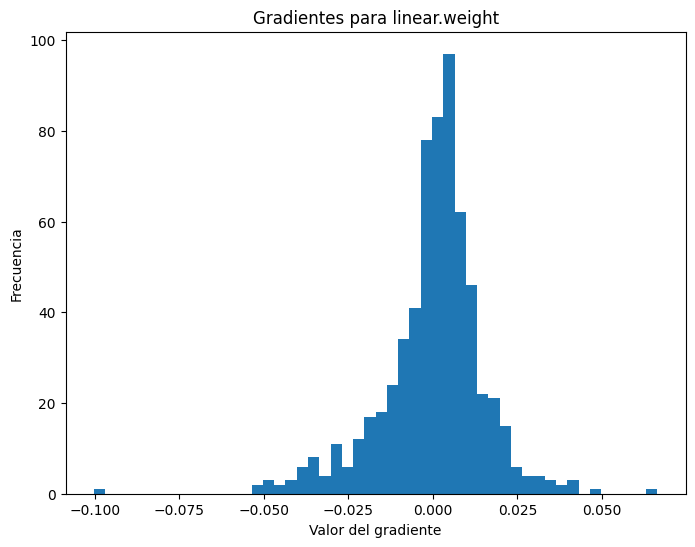

Gradientes para linear.bias: min=-0.048611074686050415, max=0.03395227715373039, mean=1.3969838619232178e-09, std=0.023263536393642426


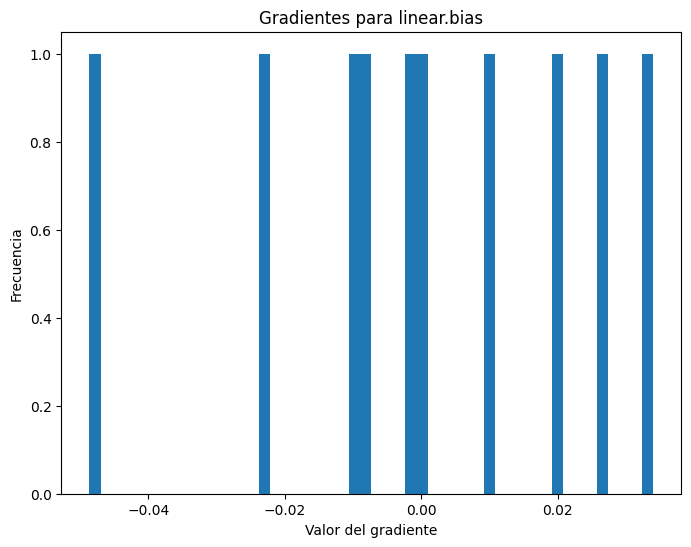

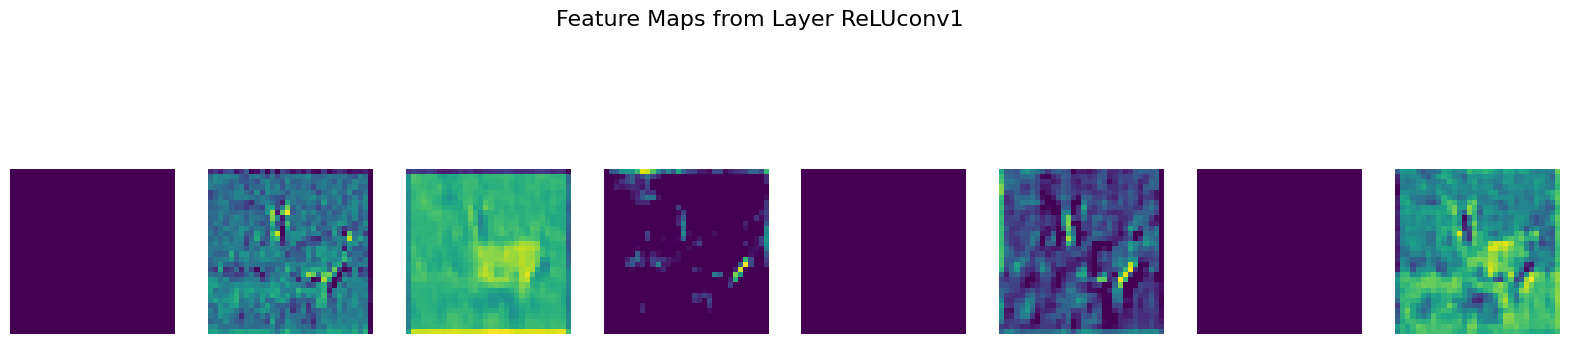

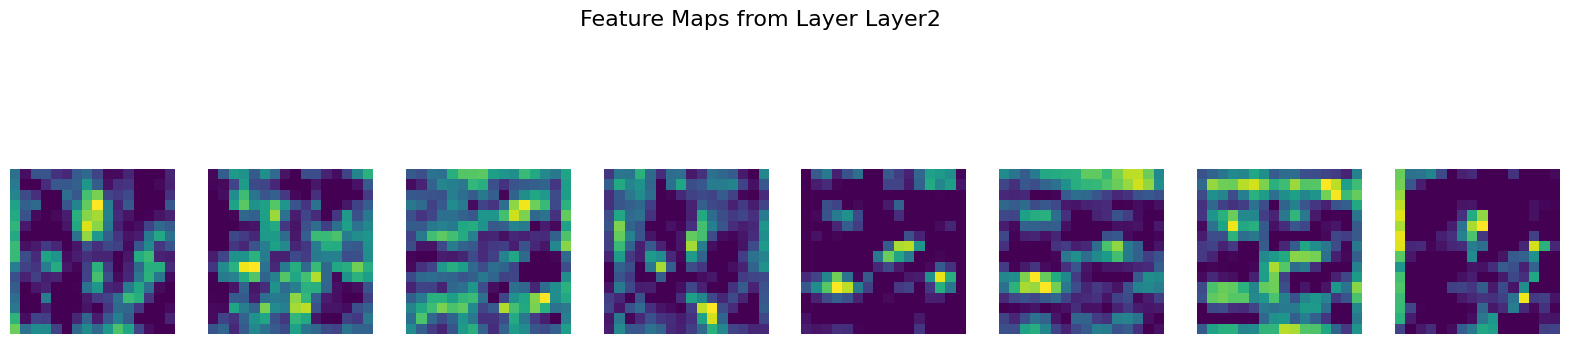

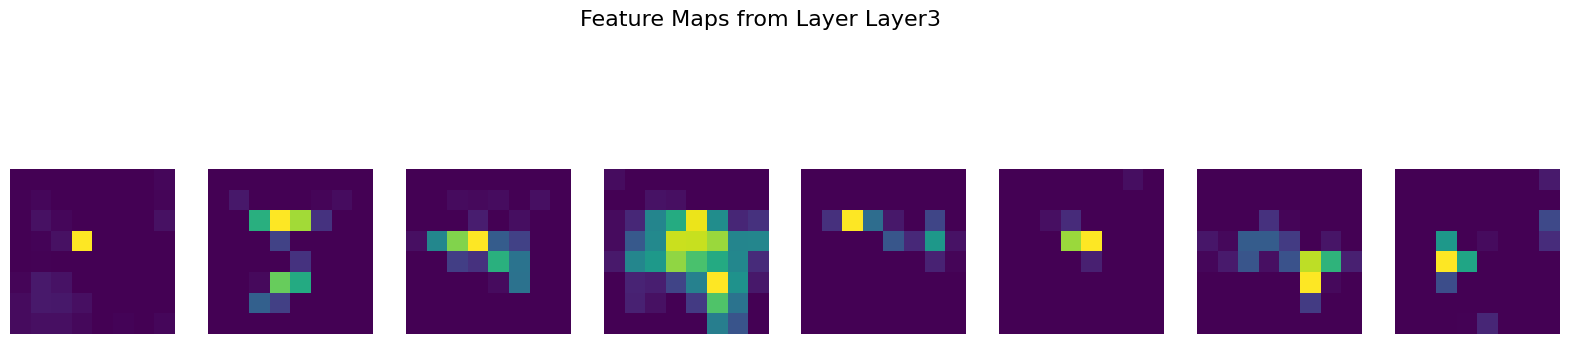

0.04
Epoch 21/70
Iteración 7075 - Lote 35/352 - Pérdida de Entrenamiento: 0.3142, Precisión de Entrenamiento: 0.8911
Iteración 7110 - Lote 70/352 - Pérdida de Entrenamiento: 0.3222, Precisión de Entrenamiento: 0.8858
Iteración 7145 - Lote 105/352 - Pérdida de Entrenamiento: 0.3326, Precisión de Entrenamiento: 0.8823
Iteración 7180 - Lote 140/352 - Pérdida de Entrenamiento: 0.3331, Precisión de Entrenamiento: 0.8809
Iteración 7215 - Lote 175/352 - Pérdida de Entrenamiento: 0.3344, Precisión de Entrenamiento: 0.8810
Iteración 7250 - Lote 210/352 - Pérdida de Entrenamiento: 0.3373, Precisión de Entrenamiento: 0.8800
Iteración 7285 - Lote 245/352 - Pérdida de Entrenamiento: 0.3399, Precisión de Entrenamiento: 0.8798
Iteración 7320 - Lote 280/352 - Pérdida de Entrenamiento: 0.3413, Precisión de Entrenamiento: 0.8798
Iteración 7355 - Lote 315/352 - Pérdida de Entrenamiento: 0.3425, Precisión de Entrenamiento: 0.8796
Iteración 7390 - Lote 350/352 - Pérdida de Entrenamiento: 0.3423, Precisión 

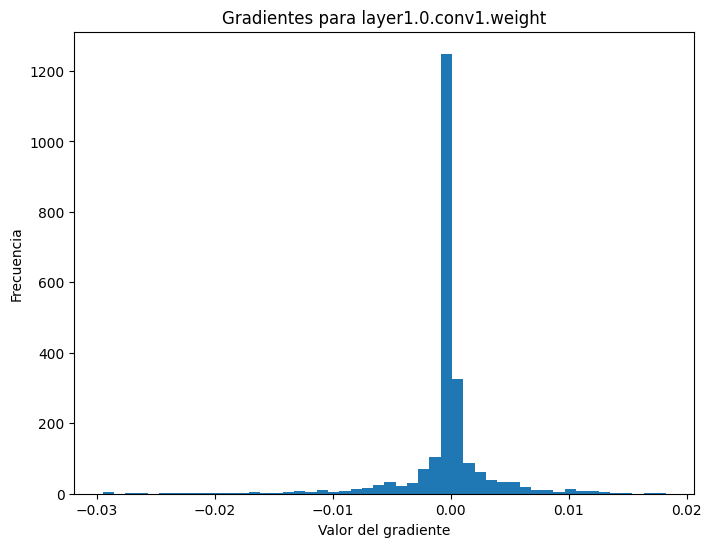

Gradientes para layer1.0.bn1.weight: min=-0.025032179430127144, max=0.029020681977272034, mean=-0.00021606823429465294, std=0.011873933486640453


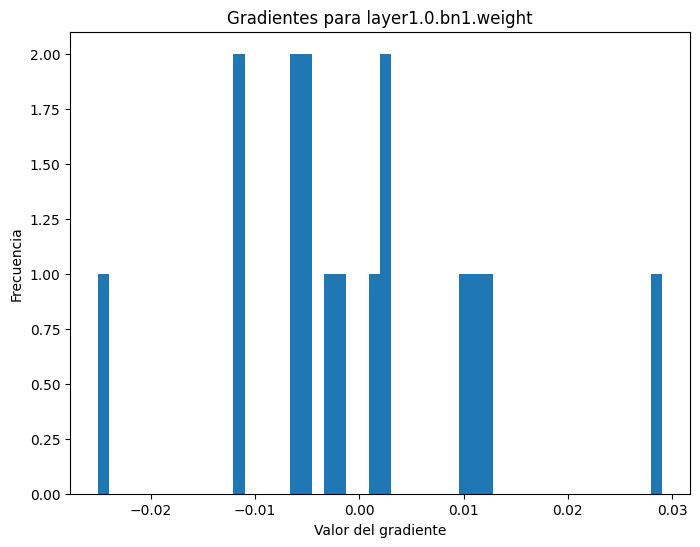

Gradientes para layer1.0.bn1.bias: min=-0.03410661965608597, max=0.027083896100521088, mean=-0.0013243434950709343, std=0.0140834990888834


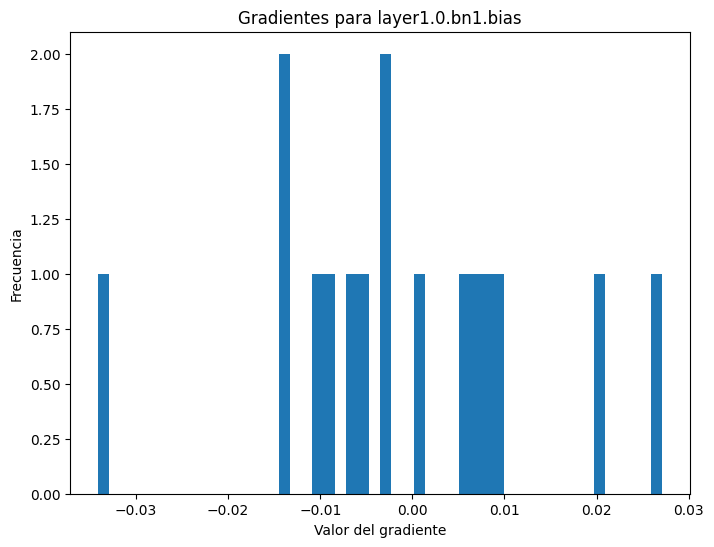

Gradientes para layer2.2.conv1.weight: min=-0.011774148792028427, max=0.009790764190256596, mean=2.4228593247244135e-05, std=0.0015159386675804853


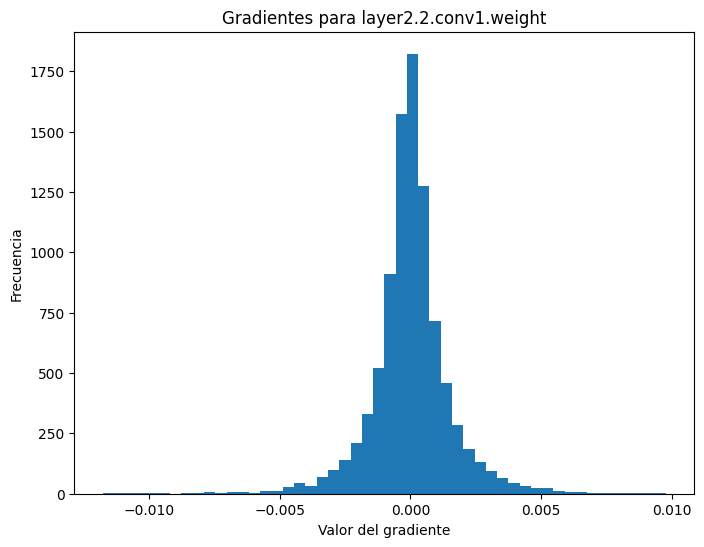

Gradientes para layer2.2.bn1.weight: min=-0.00635441392660141, max=0.012399926781654358, mean=-0.00022934982553124428, std=0.003948852885514498


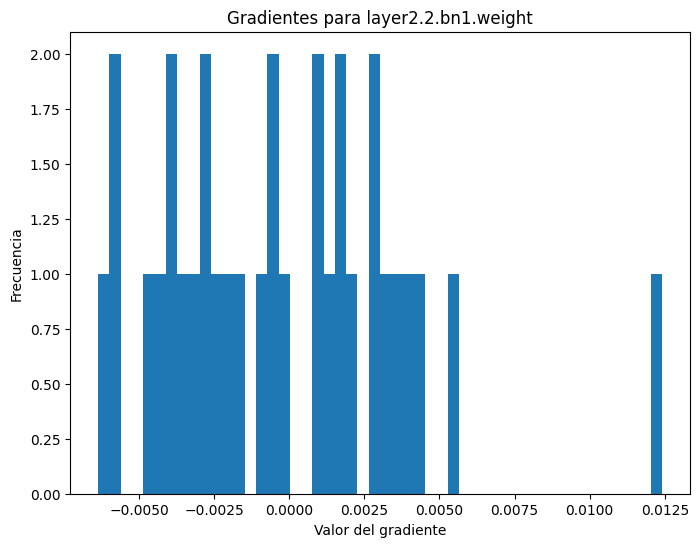

Gradientes para layer2.2.bn1.bias: min=-0.007487068884074688, max=0.007102590519934893, mean=-0.0001646597811486572, std=0.0035097997169941664


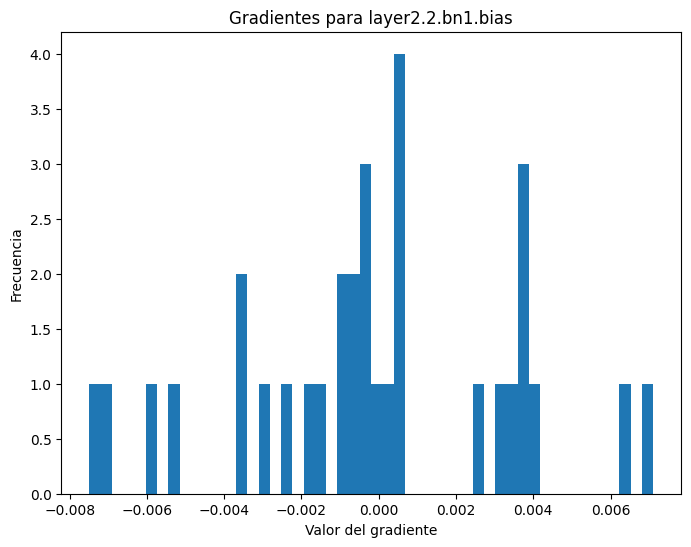

Gradientes para linear.weight: min=-0.03599054738879204, max=0.04128914698958397, mean=4.190951474747351e-10, std=0.009396997280418873


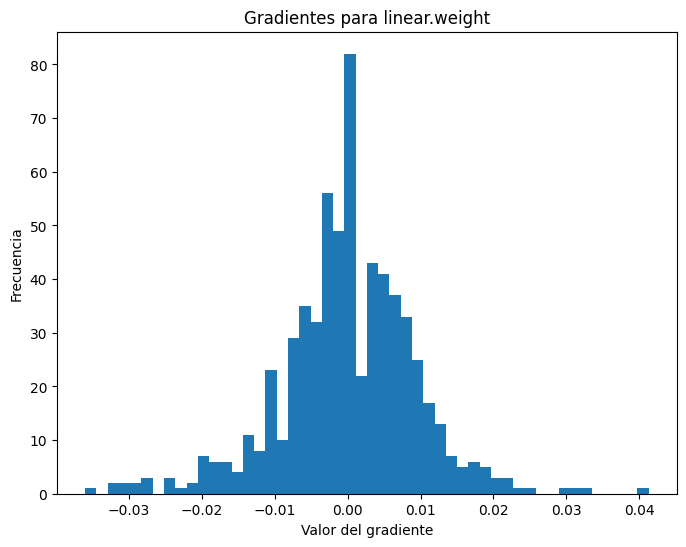

Gradientes para linear.bias: min=-0.023080572485923767, max=0.018505502492189407, mean=8.381902949494702e-10, std=0.014016848988831043


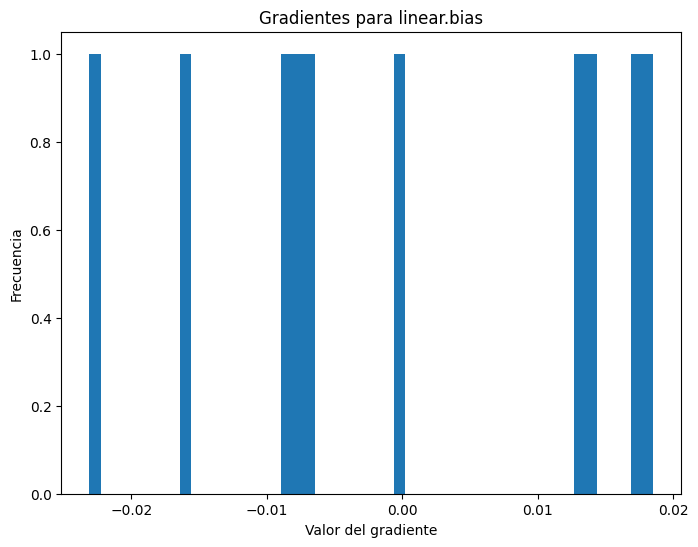

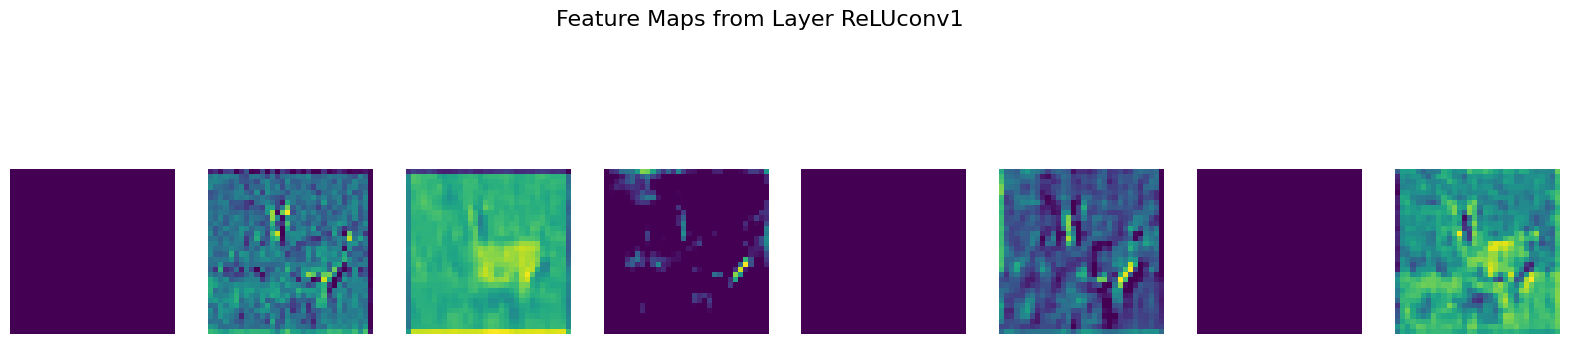

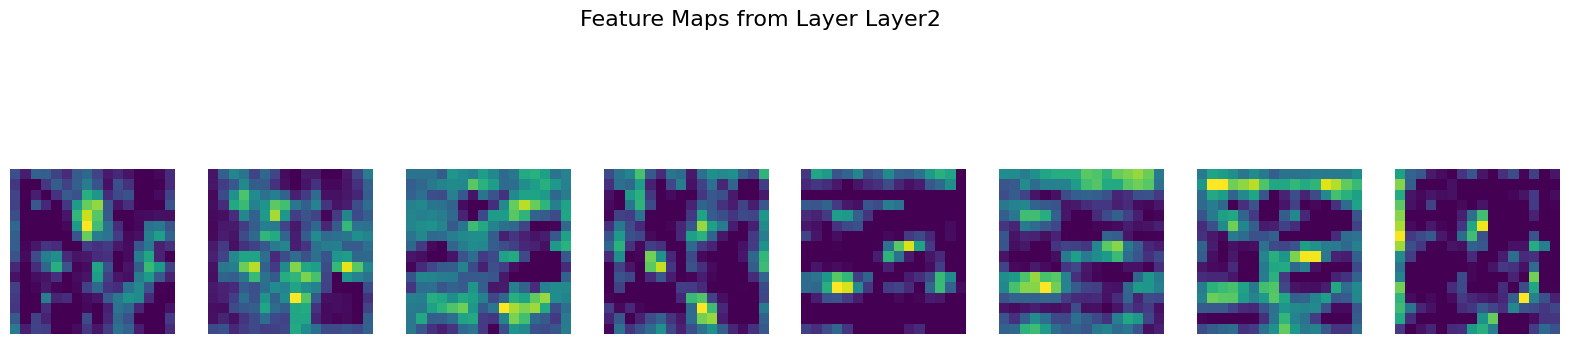

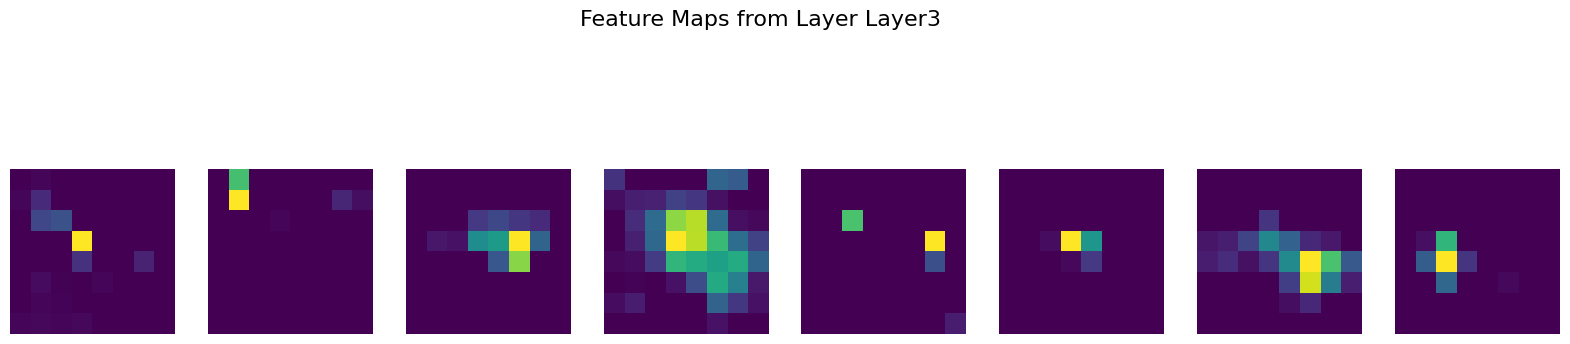

0.04
Epoch 26/70
Iteración 8835 - Lote 35/352 - Pérdida de Entrenamiento: 0.2573, Precisión de Entrenamiento: 0.9123
Iteración 8870 - Lote 70/352 - Pérdida de Entrenamiento: 0.2696, Precisión de Entrenamiento: 0.9078
Iteración 8905 - Lote 105/352 - Pérdida de Entrenamiento: 0.2761, Precisión de Entrenamiento: 0.9038
Iteración 8940 - Lote 140/352 - Pérdida de Entrenamiento: 0.2785, Precisión de Entrenamiento: 0.9026
Iteración 8975 - Lote 175/352 - Pérdida de Entrenamiento: 0.2789, Precisión de Entrenamiento: 0.9024
Iteración 9010 - Lote 210/352 - Pérdida de Entrenamiento: 0.2802, Precisión de Entrenamiento: 0.9025
Iteración 9045 - Lote 245/352 - Pérdida de Entrenamiento: 0.2851, Precisión de Entrenamiento: 0.9010
Iteración 9080 - Lote 280/352 - Pérdida de Entrenamiento: 0.2847, Precisión de Entrenamiento: 0.9009
Iteración 9115 - Lote 315/352 - Pérdida de Entrenamiento: 0.2858, Precisión de Entrenamiento: 0.9000
Iteración 9150 - Lote 350/352 - Pérdida de Entrenamiento: 0.2872, Precisión 

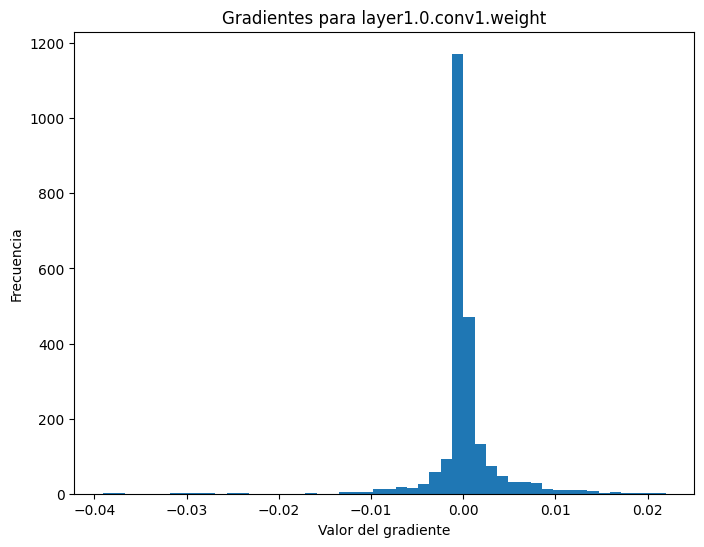

Gradientes para layer1.0.bn1.weight: min=-0.013350793160498142, max=0.030232524499297142, mean=0.0031145266257226467, std=0.012956255115568638


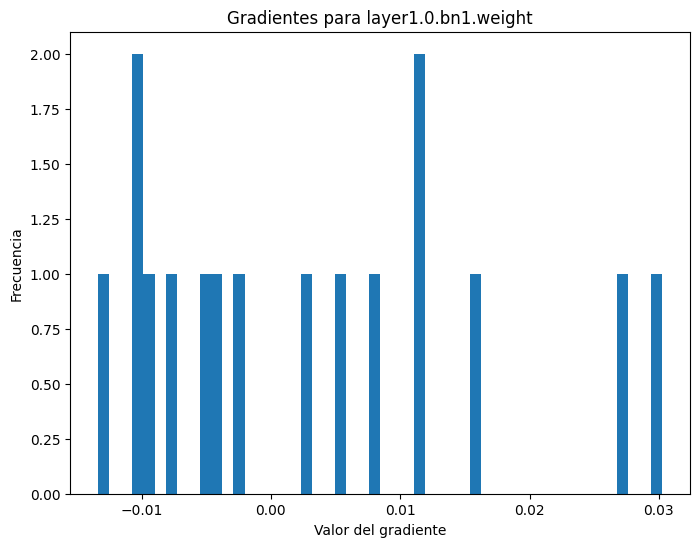

Gradientes para layer1.0.bn1.bias: min=-0.01276593841612339, max=0.03162906691431999, mean=0.005792886950075626, std=0.0127090560272336


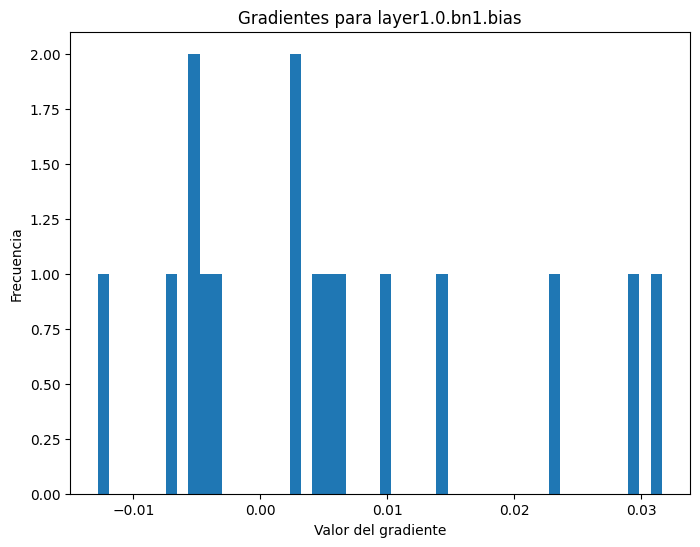

Gradientes para layer2.2.conv1.weight: min=-0.014657504856586456, max=0.012907000258564949, mean=-0.0001860890188254416, std=0.001572524313814938


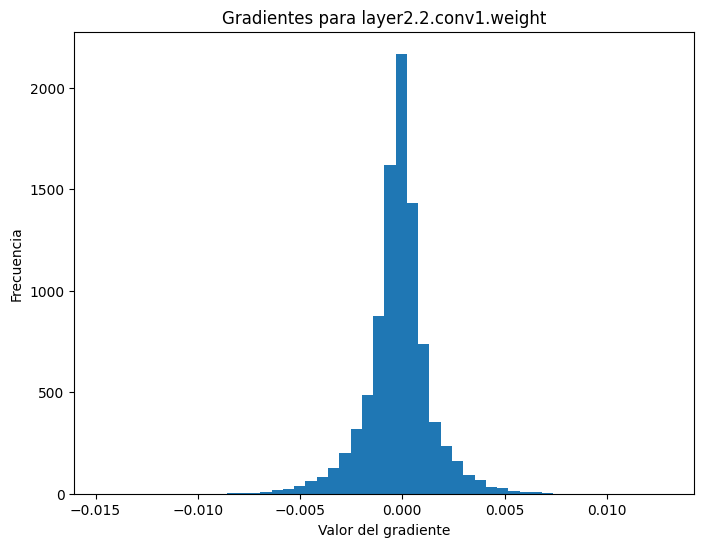

Gradientes para layer2.2.bn1.weight: min=-0.010796153917908669, max=0.014127553440630436, mean=-0.00010135845514014363, std=0.00557461054995656


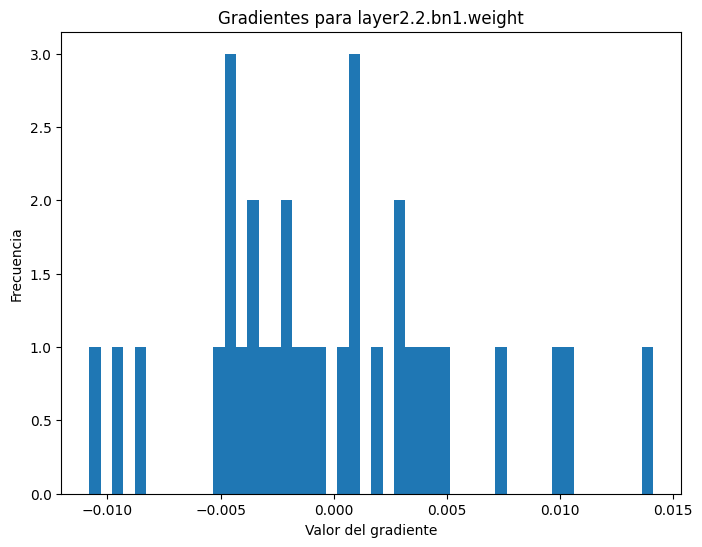

Gradientes para layer2.2.bn1.bias: min=-0.008427472785115242, max=0.01200689934194088, mean=0.00024412531638517976, std=0.004311420489102602


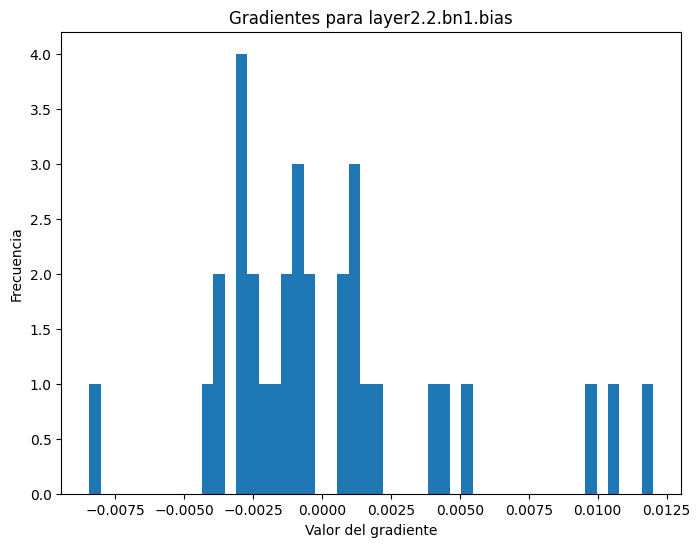

Gradientes para linear.weight: min=-0.029598403722047806, max=0.030153457075357437, mean=1.3038515822572094e-09, std=0.006570219062268734


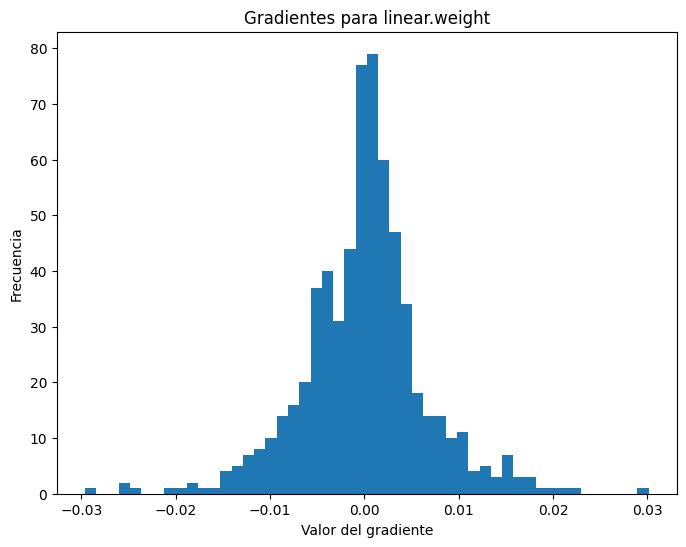

Gradientes para linear.bias: min=-0.01721014268696308, max=0.023911219090223312, mean=1.862645149230957e-09, std=0.011112065985798836


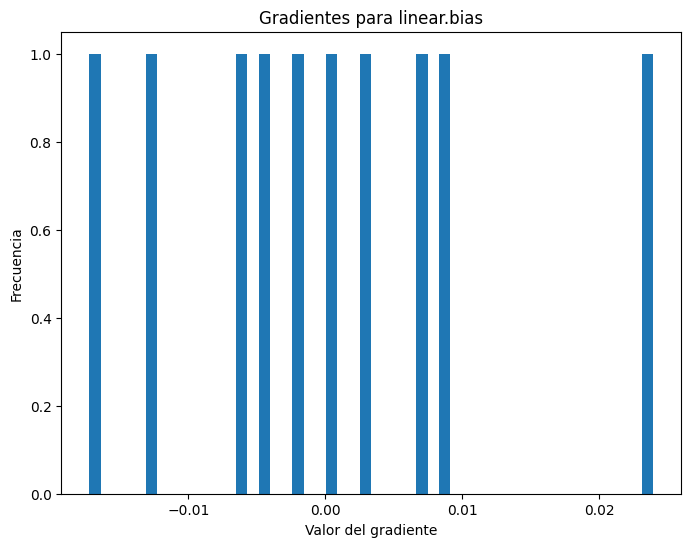

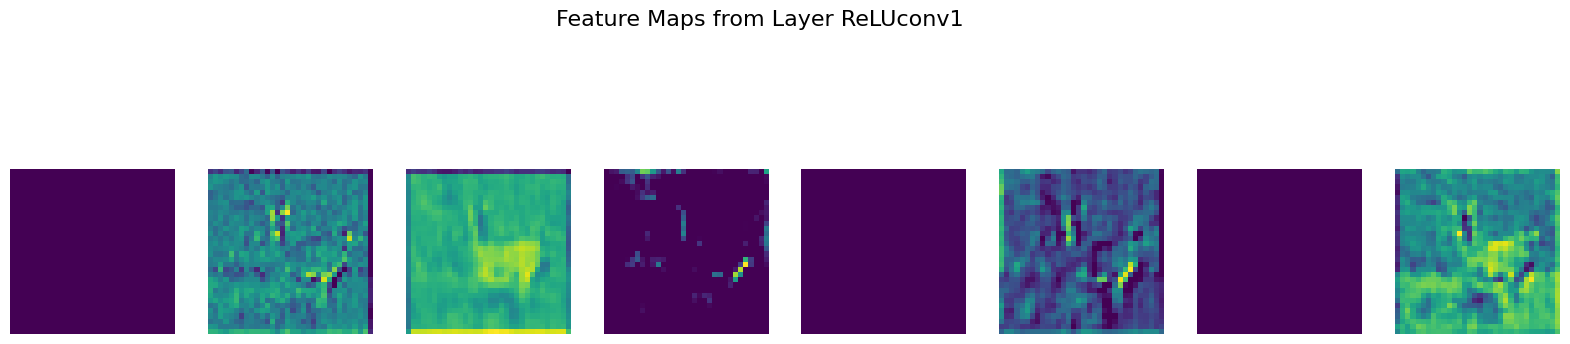

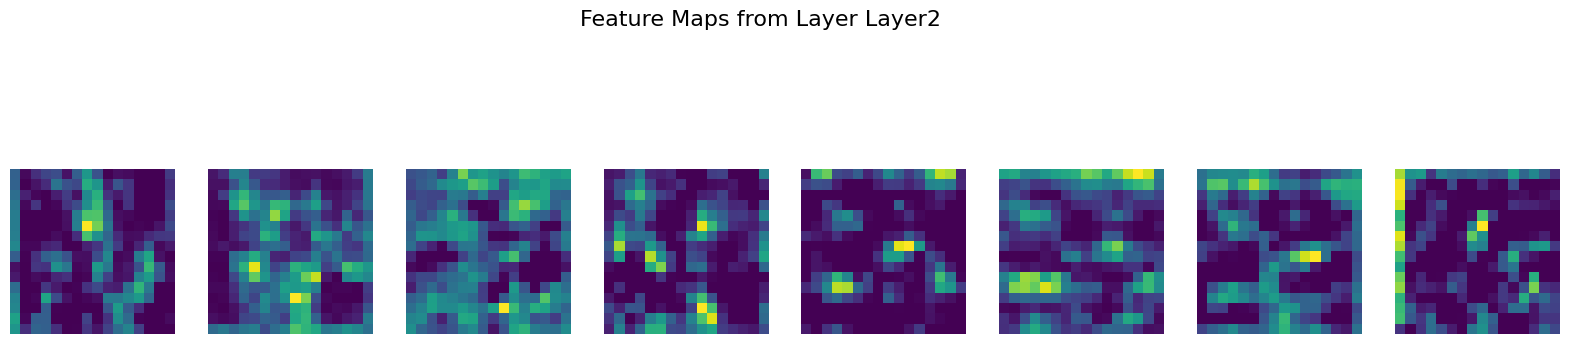

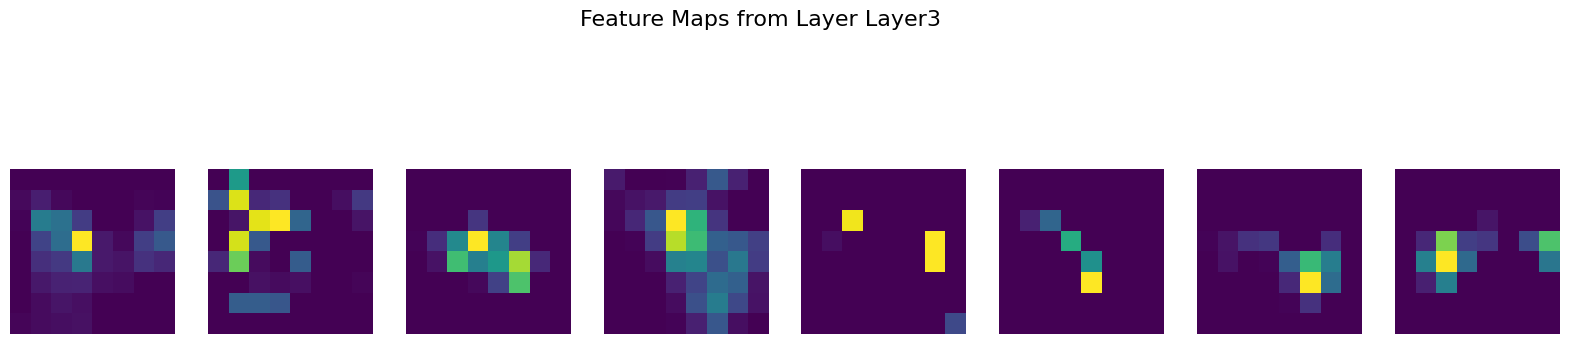

0.004
Epoch 31/70
Iteración 10595 - Lote 35/352 - Pérdida de Entrenamiento: 0.2091, Precisión de Entrenamiento: 0.9263
Iteración 10630 - Lote 70/352 - Pérdida de Entrenamiento: 0.2033, Precisión de Entrenamiento: 0.9309
Iteración 10665 - Lote 105/352 - Pérdida de Entrenamiento: 0.1941, Precisión de Entrenamiento: 0.9346
Iteración 10700 - Lote 140/352 - Pérdida de Entrenamiento: 0.1861, Precisión de Entrenamiento: 0.9379
Iteración 10735 - Lote 175/352 - Pérdida de Entrenamiento: 0.1835, Precisión de Entrenamiento: 0.9387
Iteración 10770 - Lote 210/352 - Pérdida de Entrenamiento: 0.1810, Precisión de Entrenamiento: 0.9396
Iteración 10805 - Lote 245/352 - Pérdida de Entrenamiento: 0.1781, Precisión de Entrenamiento: 0.9406
Iteración 10840 - Lote 280/352 - Pérdida de Entrenamiento: 0.1739, Precisión de Entrenamiento: 0.9420
Iteración 10875 - Lote 315/352 - Pérdida de Entrenamiento: 0.1702, Precisión de Entrenamiento: 0.9432
Iteración 10910 - Lote 350/352 - Pérdida de Entrenamiento: 0.1692,

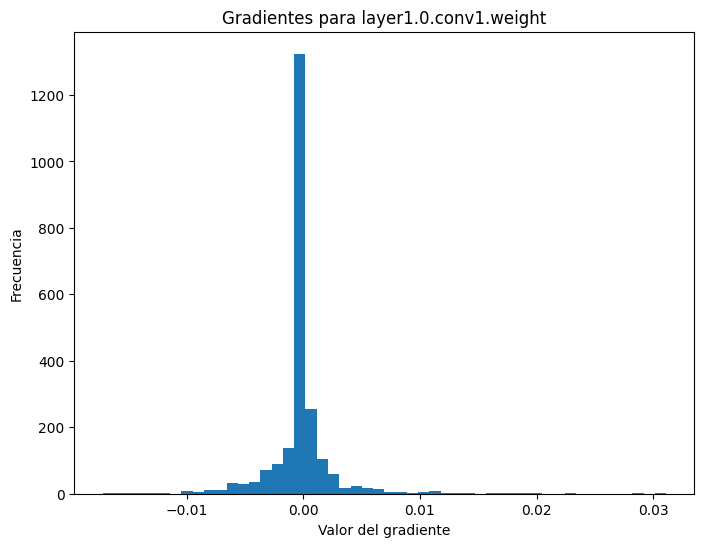

Gradientes para layer1.0.bn1.weight: min=-0.009032540954649448, max=0.010665209963917732, mean=-0.0008976618992164731, std=0.005770537070930004


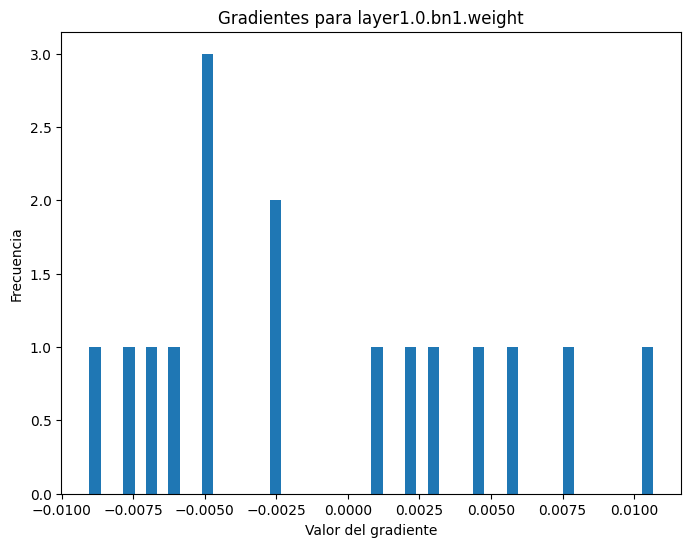

Gradientes para layer1.0.bn1.bias: min=-0.015928156673908234, max=0.022533953189849854, mean=-0.0006791310152038932, std=0.0105405542999506


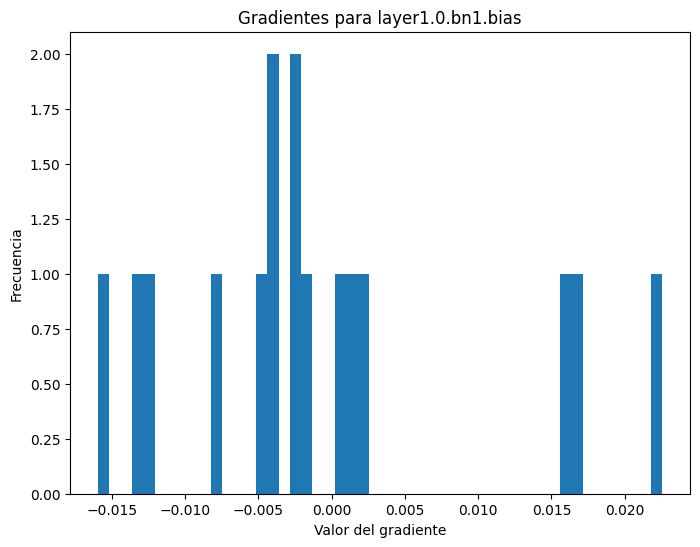

Gradientes para layer2.2.conv1.weight: min=-0.01326154638081789, max=0.010660311207175255, mean=1.3700981071451679e-05, std=0.0015225401148200035


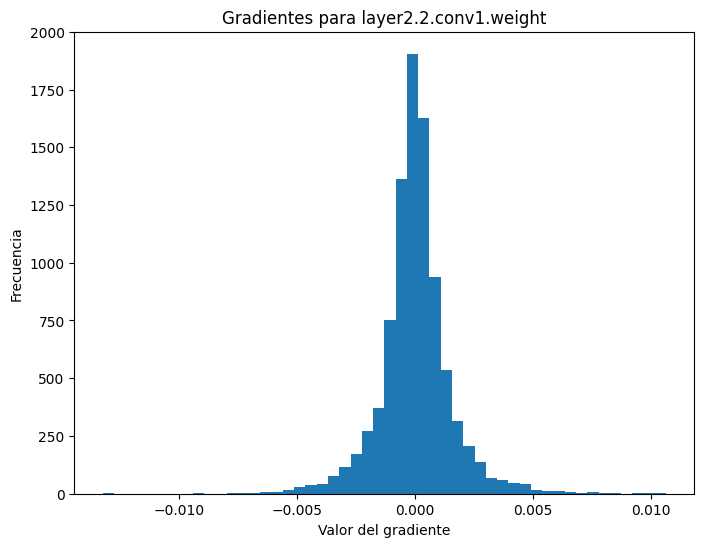

Gradientes para layer2.2.bn1.weight: min=-0.010722109116613865, max=0.009459924884140491, mean=0.0001884541125036776, std=0.004657387267798185


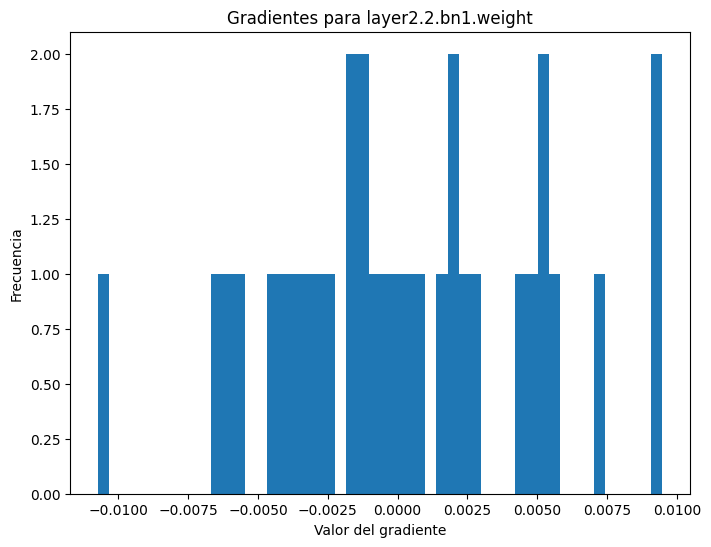

Gradientes para layer2.2.bn1.bias: min=-0.008029468357563019, max=0.008667683228850365, mean=0.00030747303389944136, std=0.0039158654399216175


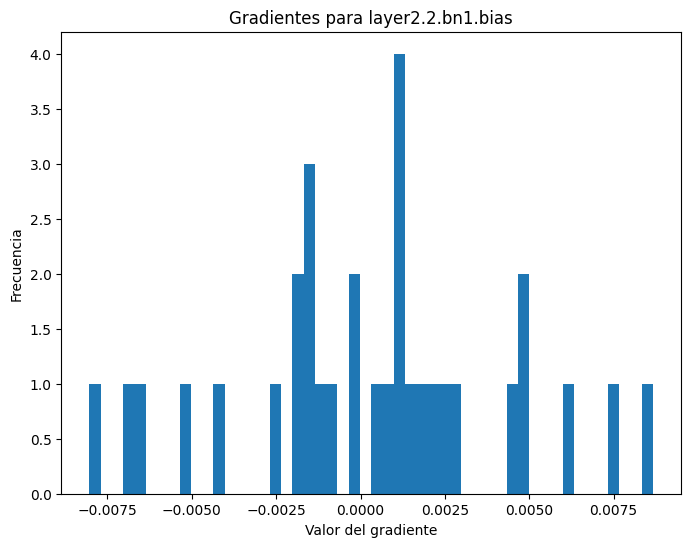

Gradientes para linear.weight: min=-0.034277647733688354, max=0.039655350148677826, mean=8.381902949494702e-10, std=0.008065106347203255


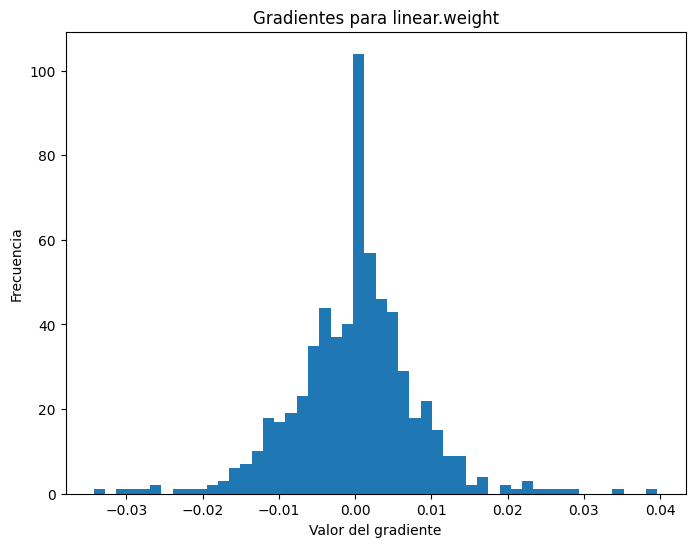

Gradientes para linear.bias: min=-0.015820730477571487, max=0.01735284924507141, mean=1.3969838619232178e-09, std=0.011717213317751884


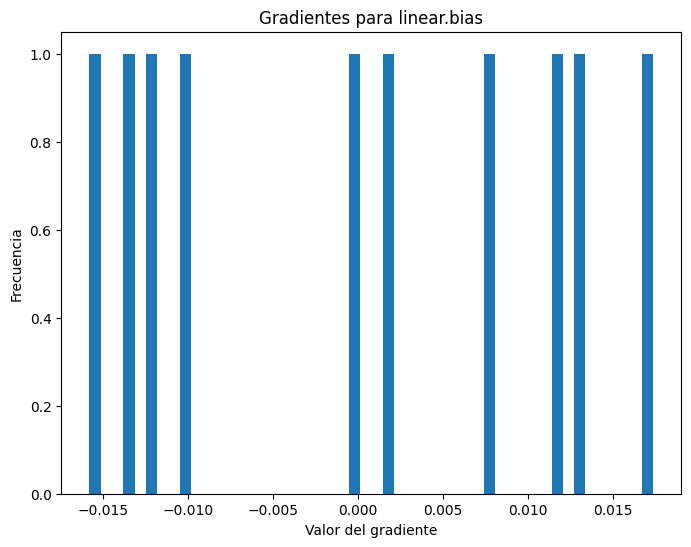

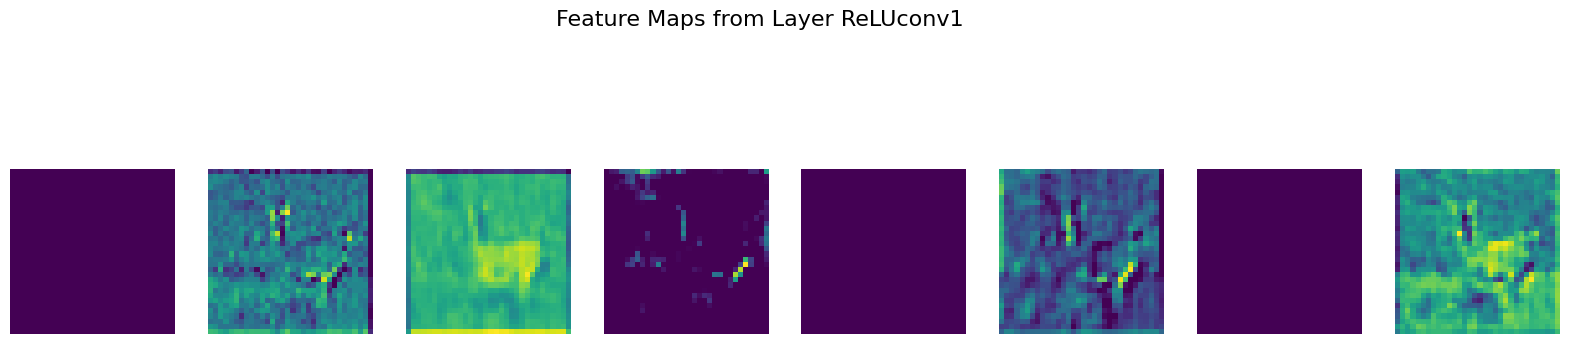

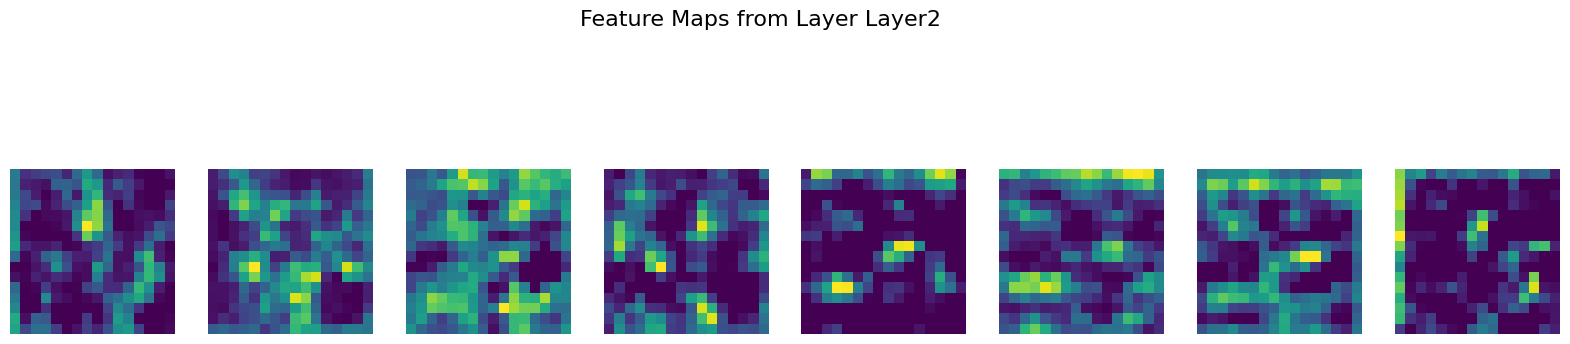

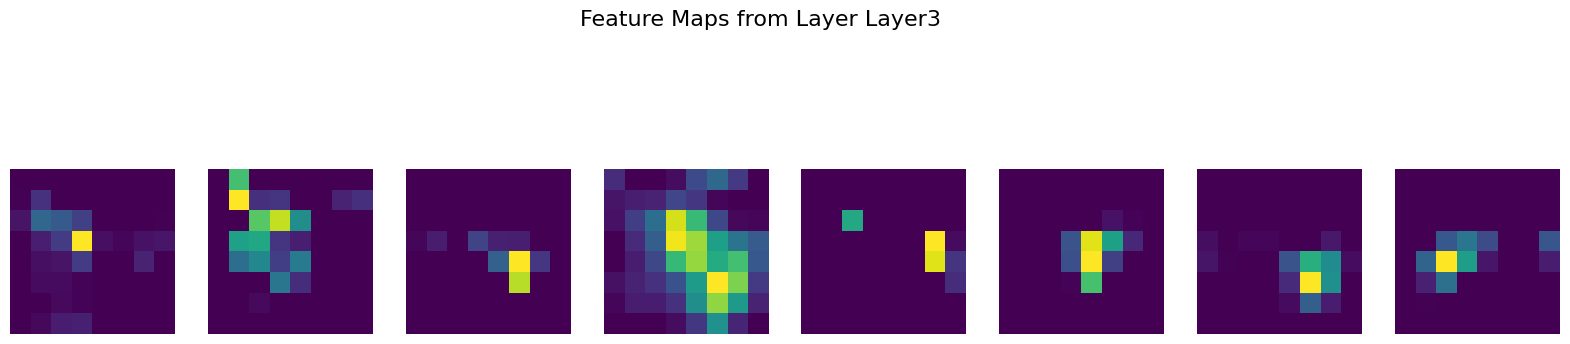

0.0004
Epoch 36/70
Iteración 12355 - Lote 35/352 - Pérdida de Entrenamiento: 0.1141, Precisión de Entrenamiento: 0.9621
Iteración 12390 - Lote 70/352 - Pérdida de Entrenamiento: 0.1138, Precisión de Entrenamiento: 0.9640
Iteración 12425 - Lote 105/352 - Pérdida de Entrenamiento: 0.1132, Precisión de Entrenamiento: 0.9627
Iteración 12460 - Lote 140/352 - Pérdida de Entrenamiento: 0.1172, Precisión de Entrenamiento: 0.9619
Iteración 12495 - Lote 175/352 - Pérdida de Entrenamiento: 0.1143, Precisión de Entrenamiento: 0.9625
Iteración 12530 - Lote 210/352 - Pérdida de Entrenamiento: 0.1132, Precisión de Entrenamiento: 0.9626
Iteración 12565 - Lote 245/352 - Pérdida de Entrenamiento: 0.1109, Precisión de Entrenamiento: 0.9634
Iteración 12600 - Lote 280/352 - Pérdida de Entrenamiento: 0.1101, Precisión de Entrenamiento: 0.9639
Iteración 12635 - Lote 315/352 - Pérdida de Entrenamiento: 0.1104, Precisión de Entrenamiento: 0.9638
Iteración 12670 - Lote 350/352 - Pérdida de Entrenamiento: 0.1114

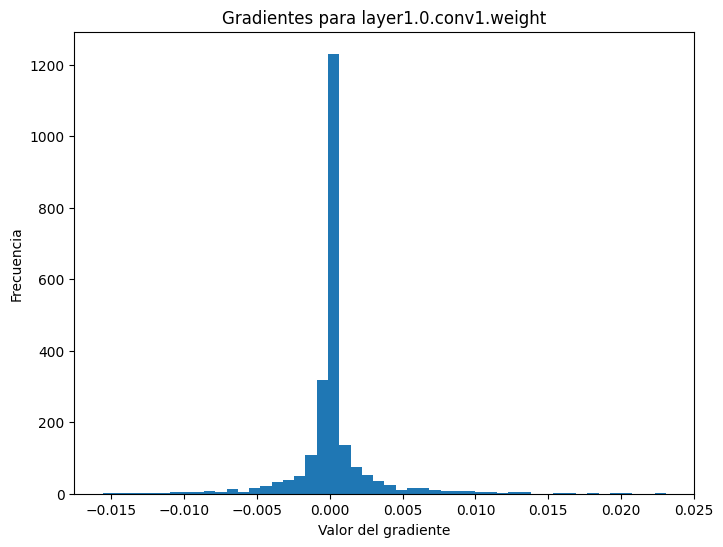

Gradientes para layer1.0.bn1.weight: min=-0.015550845302641392, max=0.02353493869304657, mean=0.0010297629050910473, std=0.009791232645511627


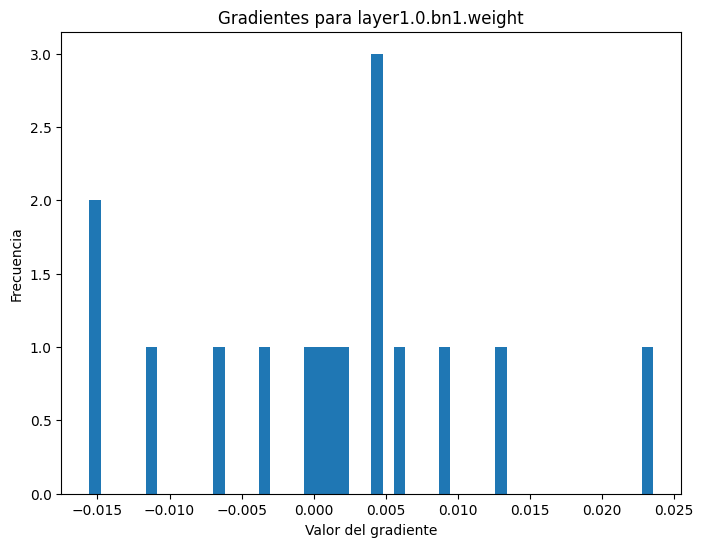

Gradientes para layer1.0.bn1.bias: min=-0.010319342836737633, max=0.007078221999108791, mean=-0.0005593781243078411, std=0.005432187579572201


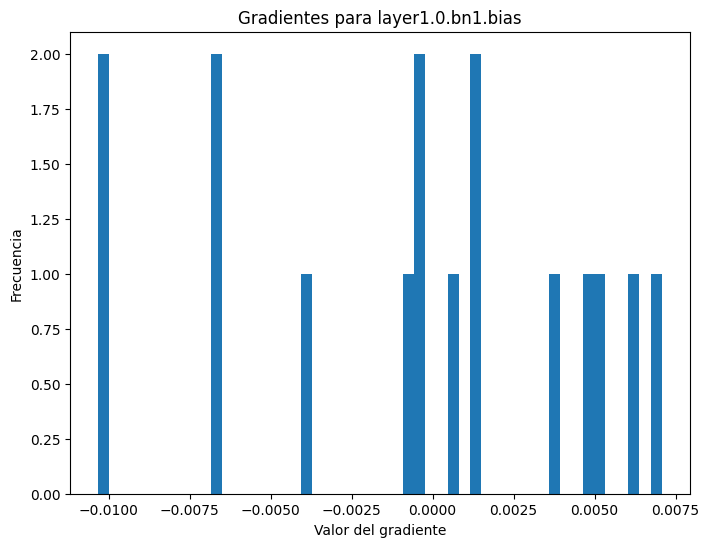

Gradientes para layer2.2.conv1.weight: min=-0.00792727805674076, max=0.005465825088322163, mean=-2.3499434973928146e-05, std=0.0011278575984761119


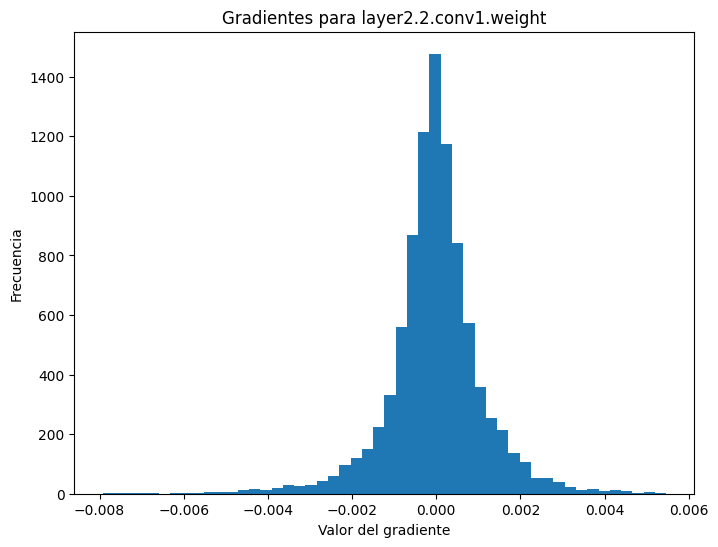

Gradientes para layer2.2.bn1.weight: min=-0.005873958580195904, max=0.005727859679609537, mean=0.00030604179482907057, std=0.0028237965889275074


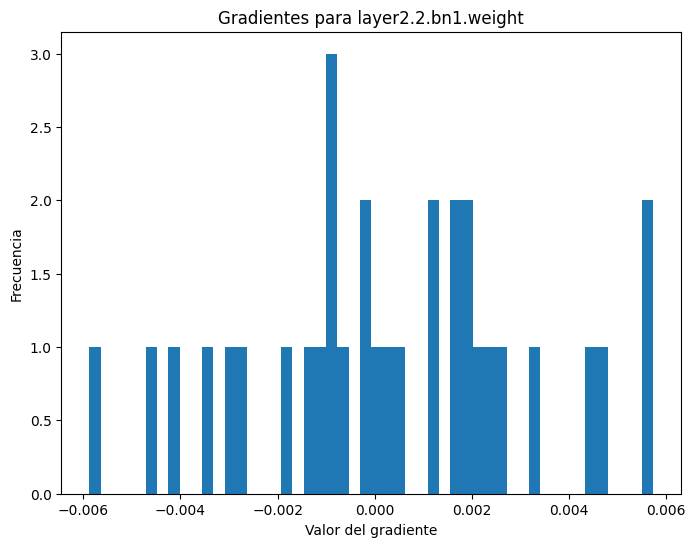

Gradientes para layer2.2.bn1.bias: min=-0.0036239968612790108, max=0.009019831195473671, mean=0.001100857392884791, std=0.0025384987238794565


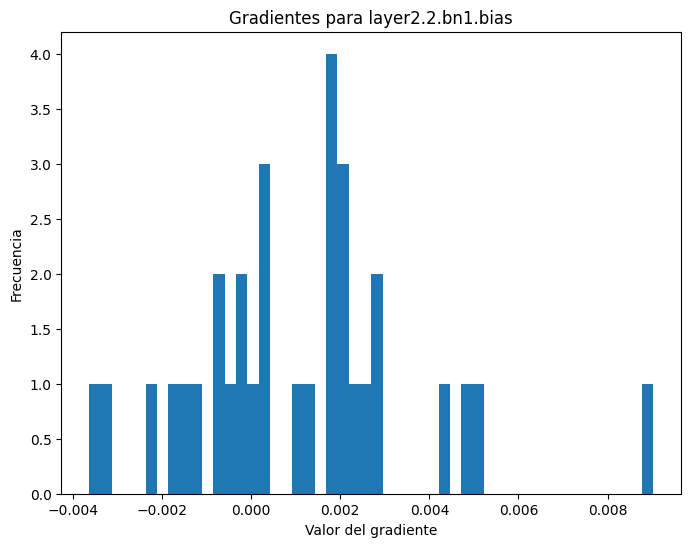

Gradientes para linear.weight: min=-0.024510430172085762, max=0.02802807092666626, mean=1.0710209386033398e-09, std=0.004885275848209858


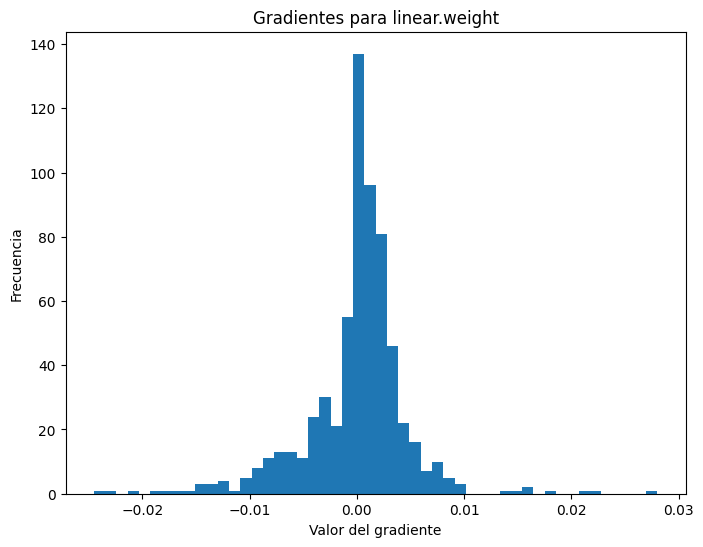

Gradientes para linear.bias: min=-0.01059633307158947, max=0.008244919590651989, mean=1.536682225911079e-09, std=0.0062903668731451035


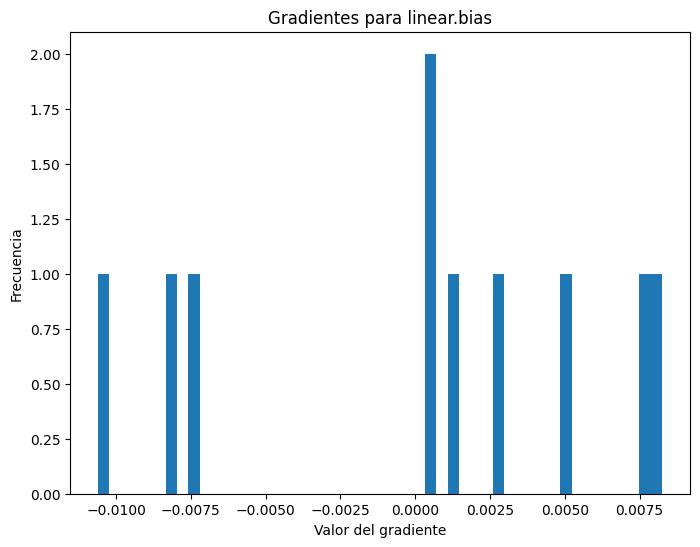

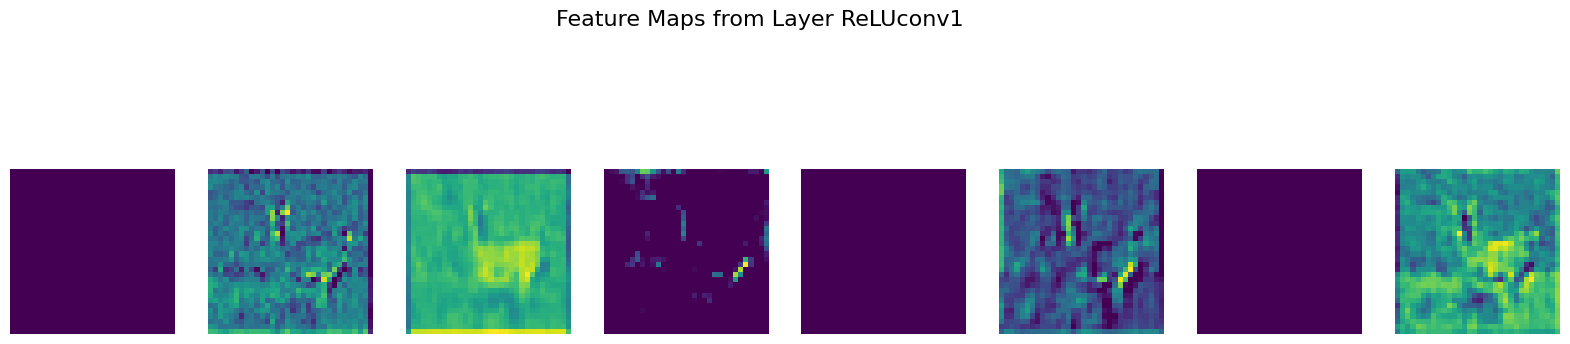

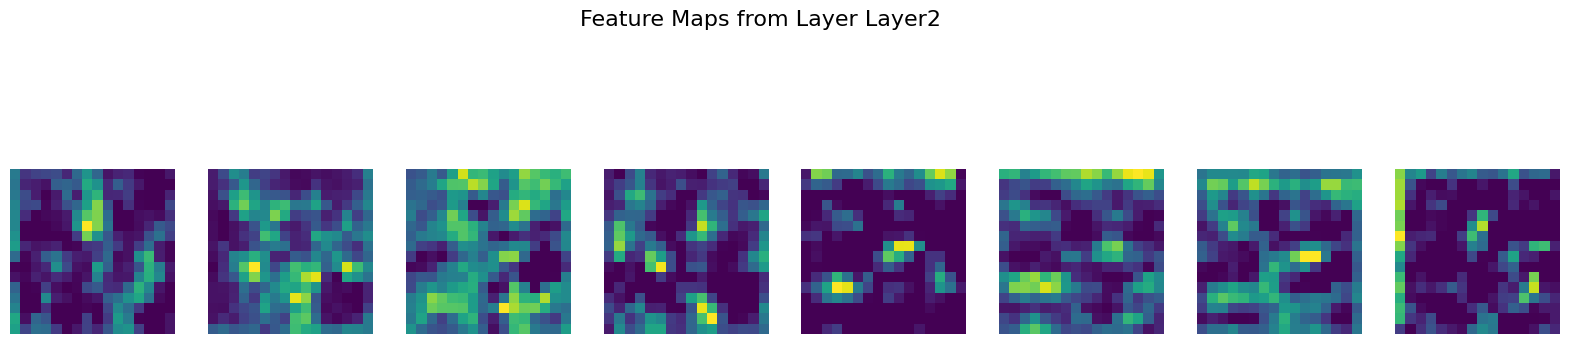

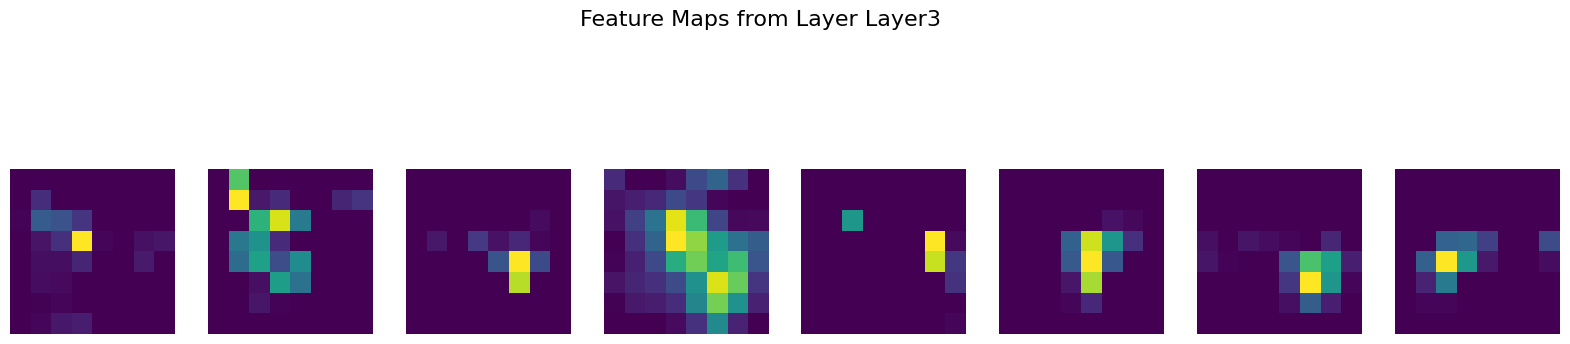

4e-05
Epoch 41/70
Iteración 14115 - Lote 35/352 - Pérdida de Entrenamiento: 0.1172, Precisión de Entrenamiento: 0.9616
Iteración 14150 - Lote 70/352 - Pérdida de Entrenamiento: 0.1125, Precisión de Entrenamiento: 0.9621
Iteración 14185 - Lote 105/352 - Pérdida de Entrenamiento: 0.1107, Precisión de Entrenamiento: 0.9636
Iteración 14220 - Lote 140/352 - Pérdida de Entrenamiento: 0.1112, Precisión de Entrenamiento: 0.9633
Iteración 14255 - Lote 175/352 - Pérdida de Entrenamiento: 0.1104, Precisión de Entrenamiento: 0.9637
Iteración 14290 - Lote 210/352 - Pérdida de Entrenamiento: 0.1102, Precisión de Entrenamiento: 0.9635
Iteración 14325 - Lote 245/352 - Pérdida de Entrenamiento: 0.1090, Precisión de Entrenamiento: 0.9641
Iteración 14360 - Lote 280/352 - Pérdida de Entrenamiento: 0.1091, Precisión de Entrenamiento: 0.9636
Iteración 14395 - Lote 315/352 - Pérdida de Entrenamiento: 0.1081, Precisión de Entrenamiento: 0.9640
Iteración 14430 - Lote 350/352 - Pérdida de Entrenamiento: 0.1080,

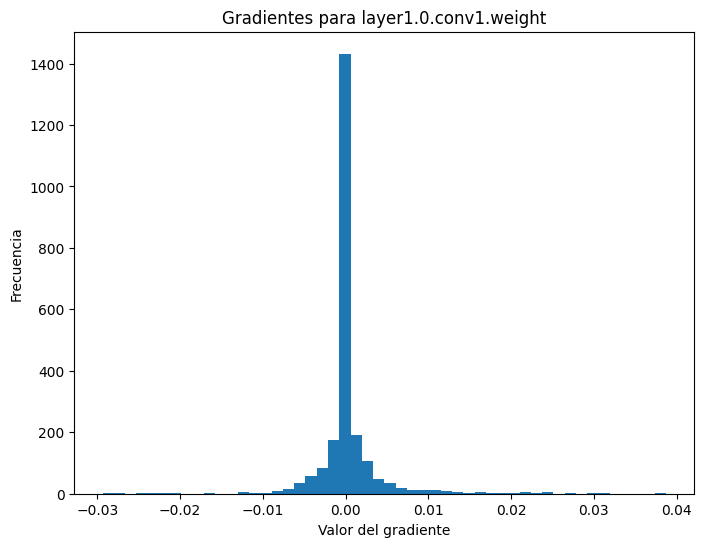

Gradientes para layer1.0.bn1.weight: min=-0.028981054201722145, max=0.03055528551340103, mean=-0.0031254971399903297, std=0.015355676412582397


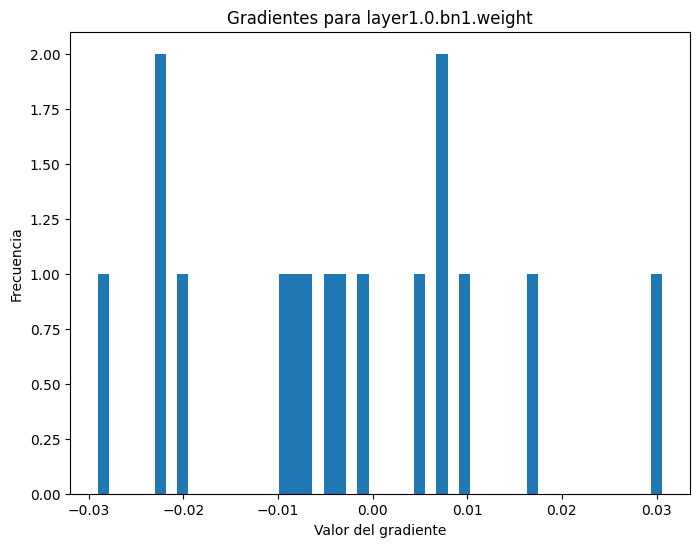

Gradientes para layer1.0.bn1.bias: min=-0.02481861226260662, max=0.01933792233467102, mean=-0.004330031108111143, std=0.015287687070667744


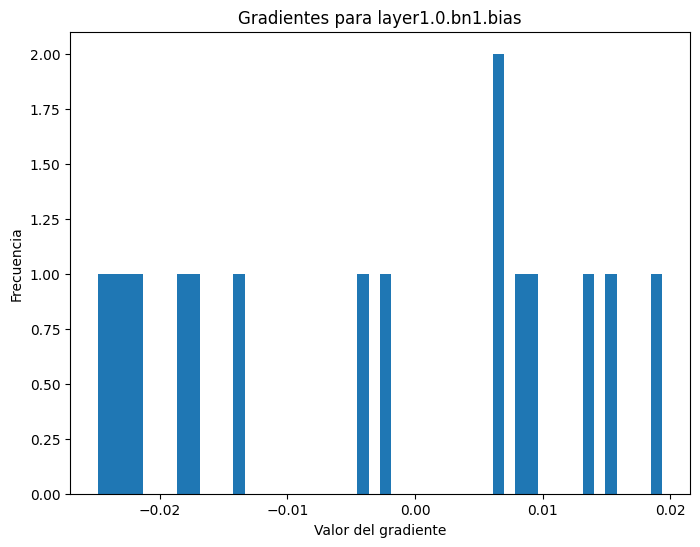

Gradientes para layer2.2.conv1.weight: min=-0.010906266048550606, max=0.012025001458823681, mean=0.0001684625312918797, std=0.0018044819589704275


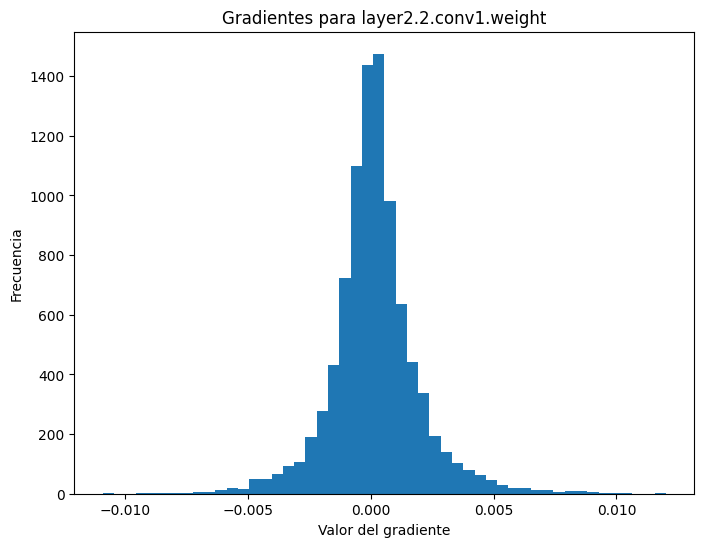

Gradientes para layer2.2.bn1.weight: min=-0.00557907996699214, max=0.013018370606005192, mean=2.051322371698916e-05, std=0.0037911797408014536


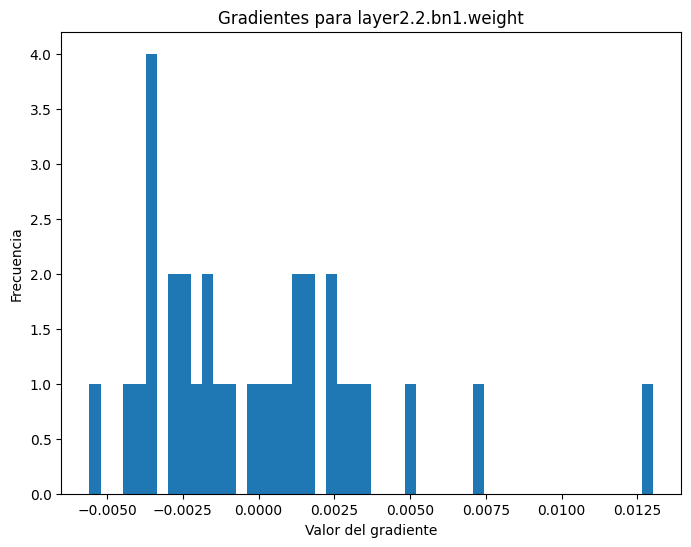

Gradientes para layer2.2.bn1.bias: min=-0.008301565423607826, max=0.008072027936577797, mean=-0.0002892387274187058, std=0.003875498892739415


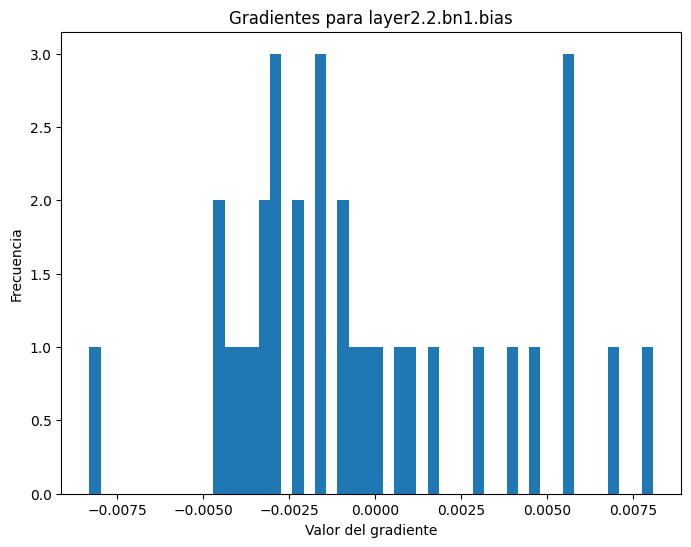

Gradientes para linear.weight: min=-0.0399349220097065, max=0.03443143144249916, mean=4.656612873077393e-10, std=0.008359313942492008


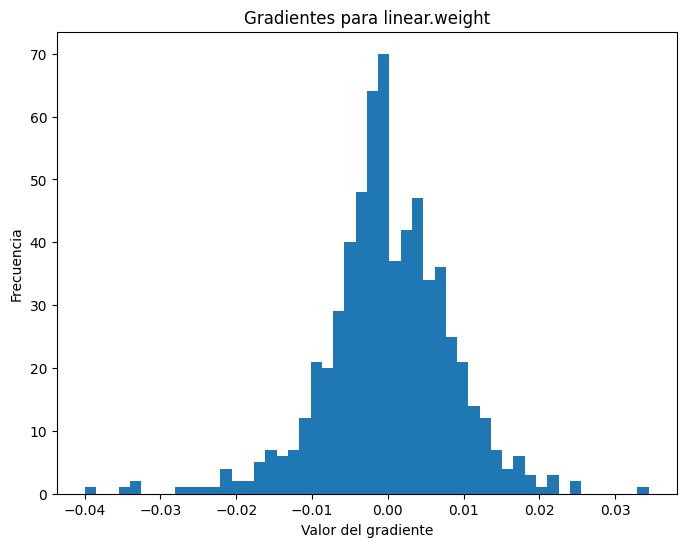

Gradientes para linear.bias: min=-0.0224588792771101, max=0.021198363974690437, mean=0.0, std=0.012225015088915825


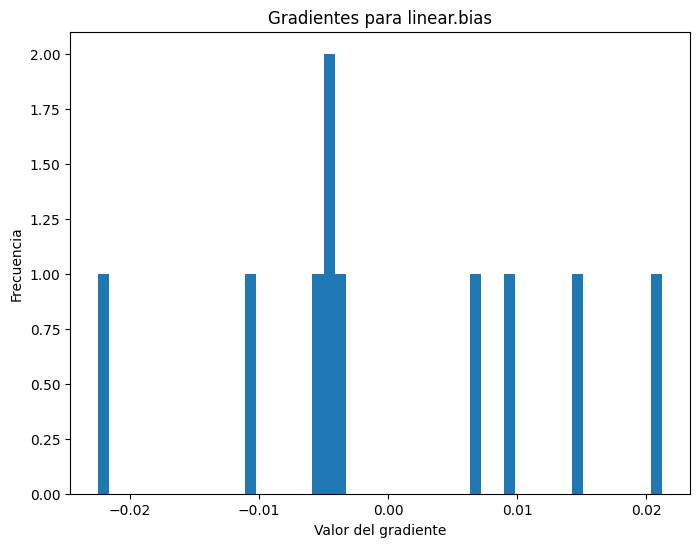

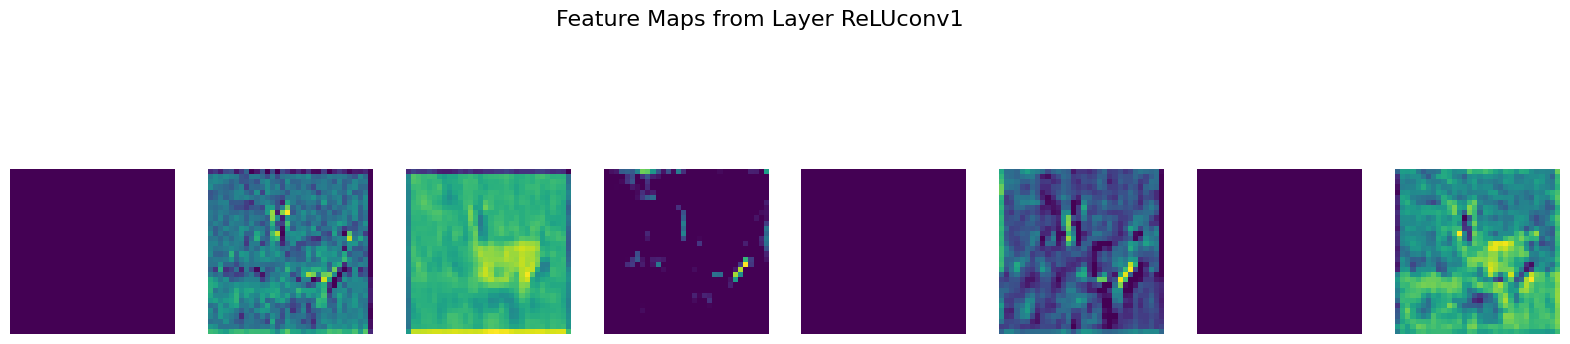

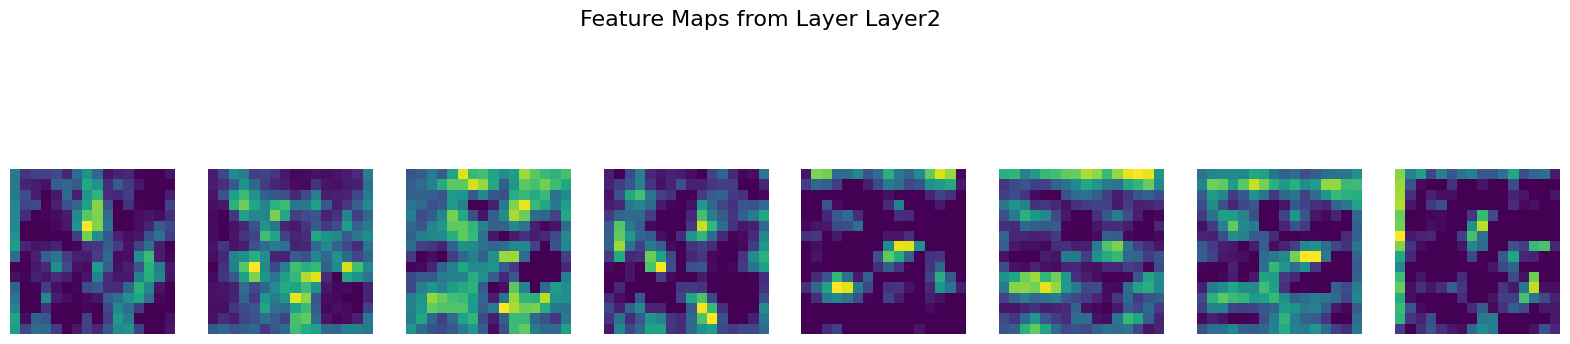

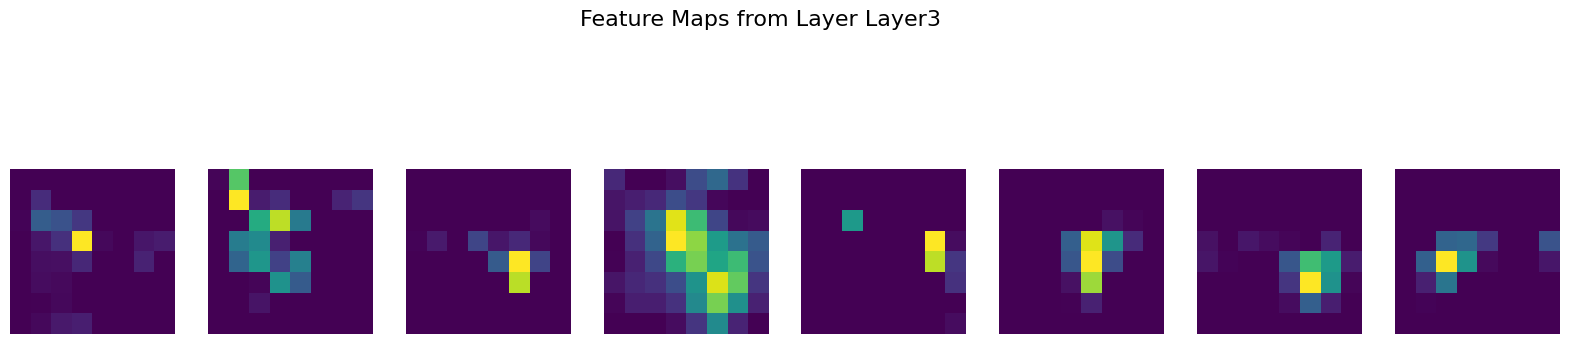

4.000000000000001e-06
Epoch 46/70
Iteración 15875 - Lote 35/352 - Pérdida de Entrenamiento: 0.1057, Precisión de Entrenamiento: 0.9641
Iteración 15910 - Lote 70/352 - Pérdida de Entrenamiento: 0.1032, Precisión de Entrenamiento: 0.9647
Iteración 15945 - Lote 105/352 - Pérdida de Entrenamiento: 0.1030, Precisión de Entrenamiento: 0.9655
Iteración 15980 - Lote 140/352 - Pérdida de Entrenamiento: 0.1066, Precisión de Entrenamiento: 0.9633
Iteración 16015 - Lote 175/352 - Pérdida de Entrenamiento: 0.1066, Precisión de Entrenamiento: 0.9634
Iteración 16050 - Lote 210/352 - Pérdida de Entrenamiento: 0.1078, Precisión de Entrenamiento: 0.9633
Iteración 16085 - Lote 245/352 - Pérdida de Entrenamiento: 0.1080, Precisión de Entrenamiento: 0.9630
Iteración 16120 - Lote 280/352 - Pérdida de Entrenamiento: 0.1063, Precisión de Entrenamiento: 0.9638
Iteración 16155 - Lote 315/352 - Pérdida de Entrenamiento: 0.1066, Precisión de Entrenamiento: 0.9640
Iteración 16190 - Lote 350/352 - Pérdida de Entren

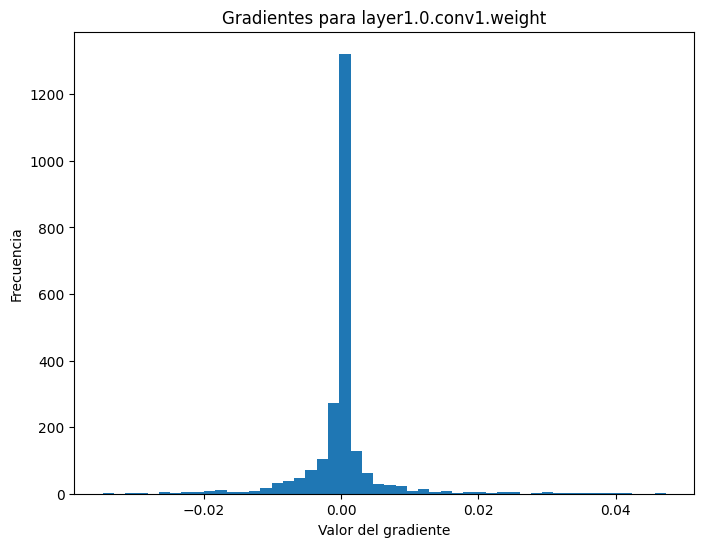

Gradientes para layer1.0.bn1.weight: min=-0.03584824874997139, max=0.04227340593934059, mean=0.0029830378480255604, std=0.019856097176671028


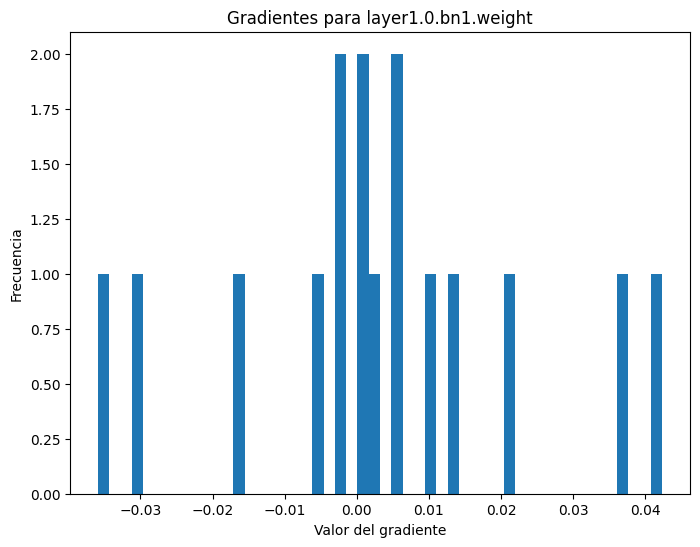

Gradientes para layer1.0.bn1.bias: min=-0.02305532991886139, max=0.04445086047053337, mean=0.007101818919181824, std=0.016521718353033066


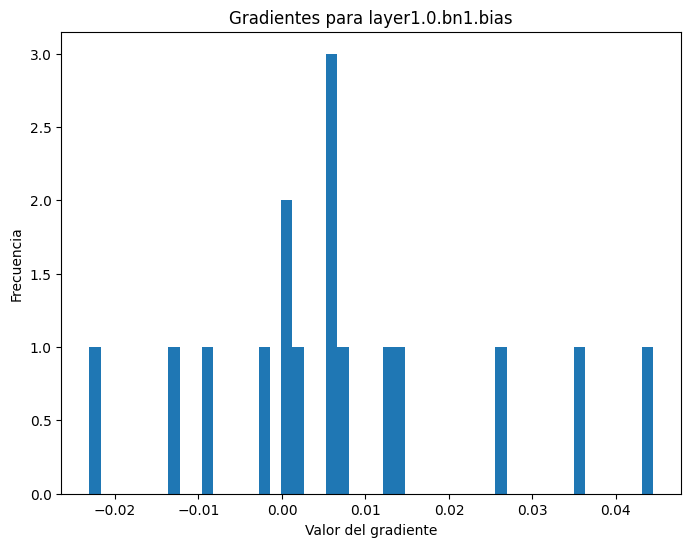

Gradientes para layer2.2.conv1.weight: min=-0.012354175560176373, max=0.012384974397718906, mean=4.799032467417419e-06, std=0.0019009093521162868


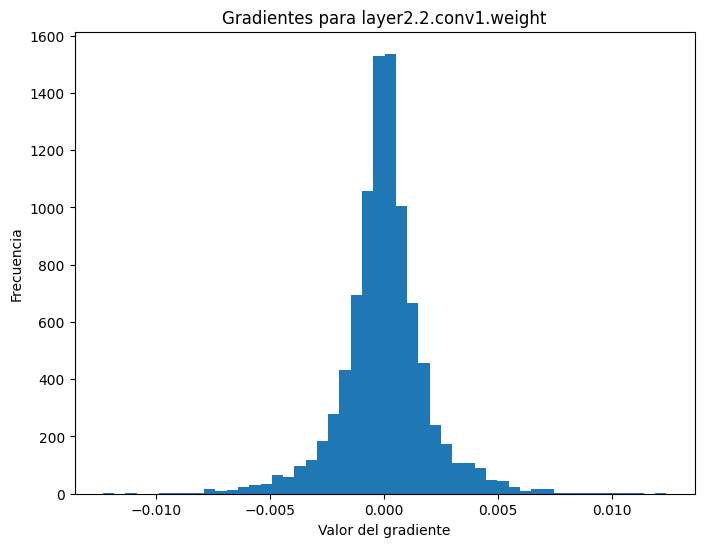

Gradientes para layer2.2.bn1.weight: min=-0.011605575680732727, max=0.011564256623387337, mean=0.00016345072071999311, std=0.005643368698656559


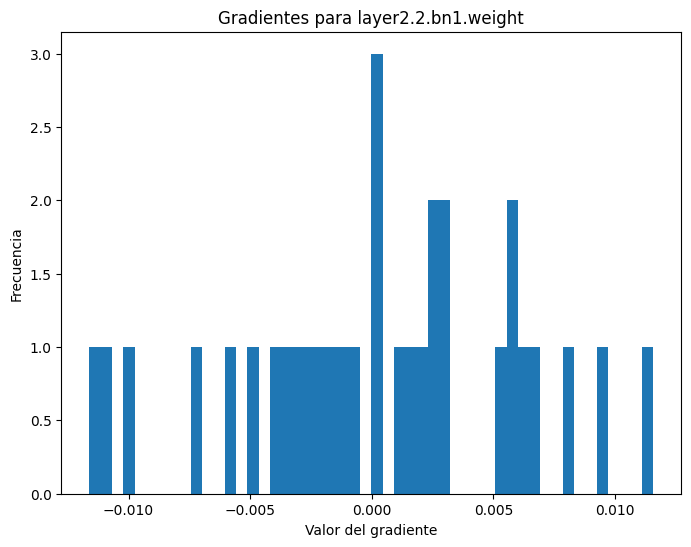

Gradientes para layer2.2.bn1.bias: min=-0.009498581290245056, max=0.012439223006367683, mean=0.00029201729921624064, std=0.005059793125838041


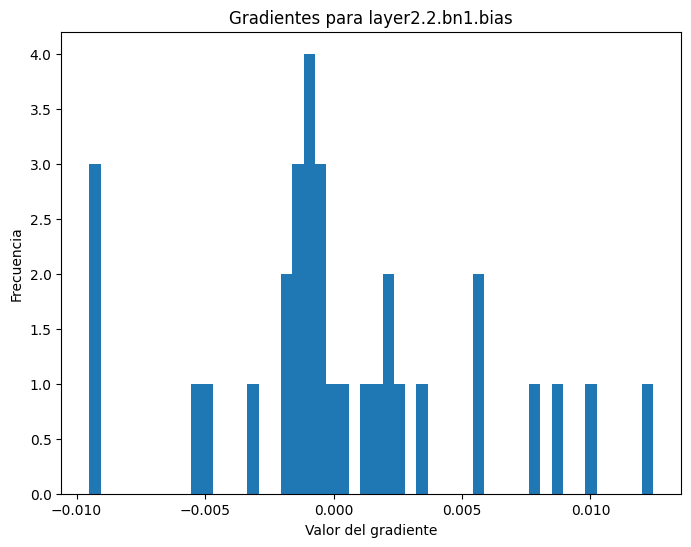

Gradientes para linear.weight: min=-0.02538461796939373, max=0.02408755198121071, mean=0.0, std=0.007360223215073347


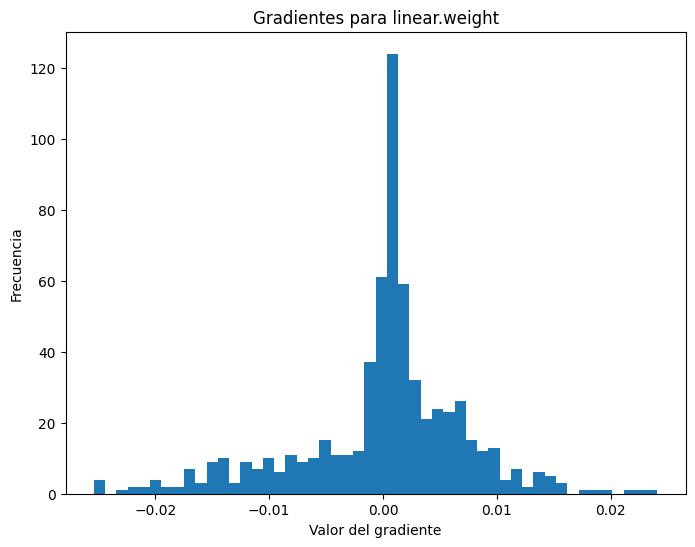

Gradientes para linear.bias: min=-0.019294852390885353, max=0.009988685138523579, mean=1.8626451769865326e-10, std=0.010380104184150696


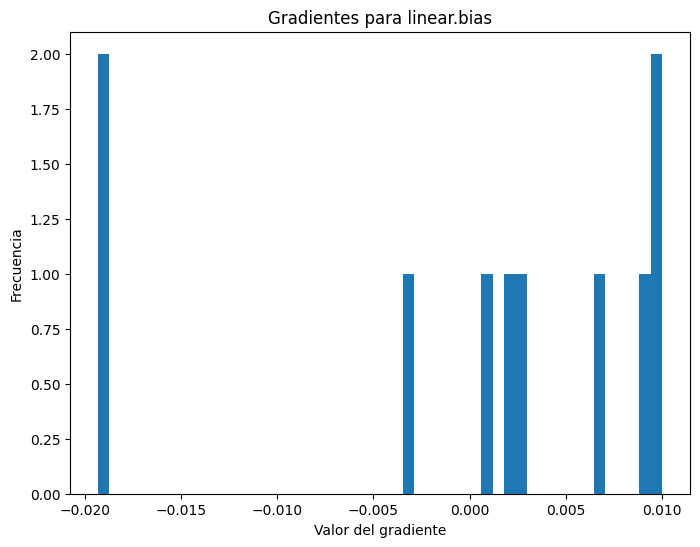

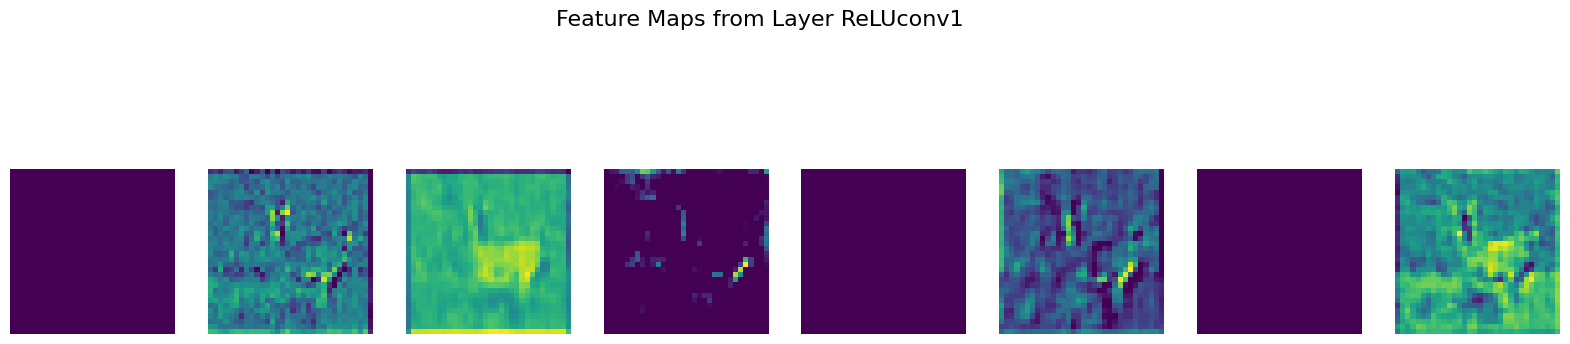

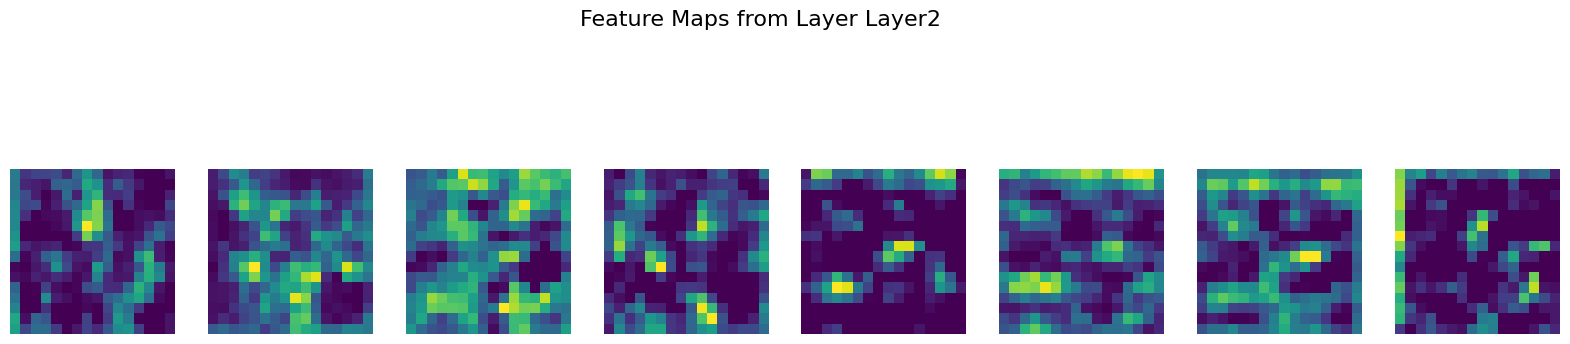

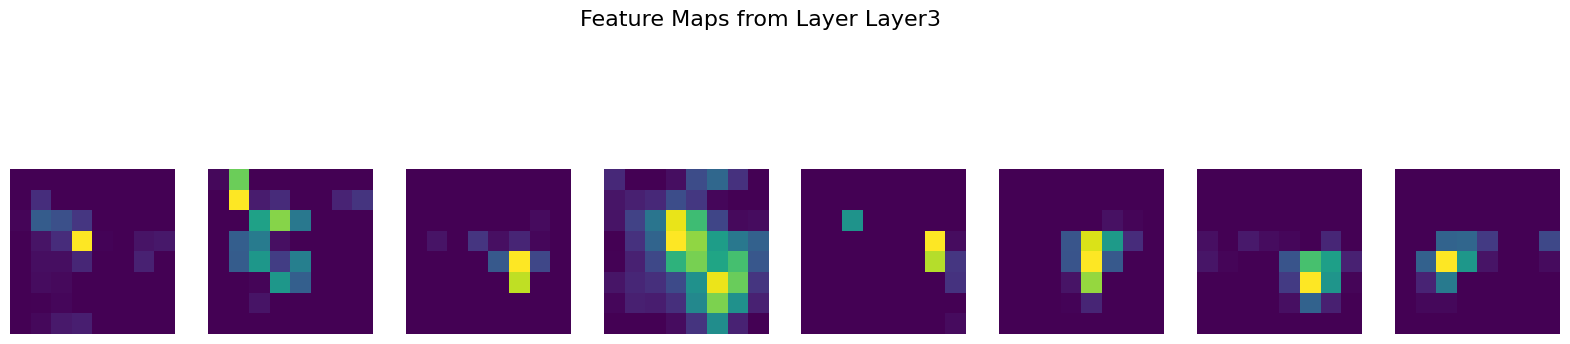

Early stopping at epoch 46

Tiempo total de entrenamiento: 2051.00 segundos


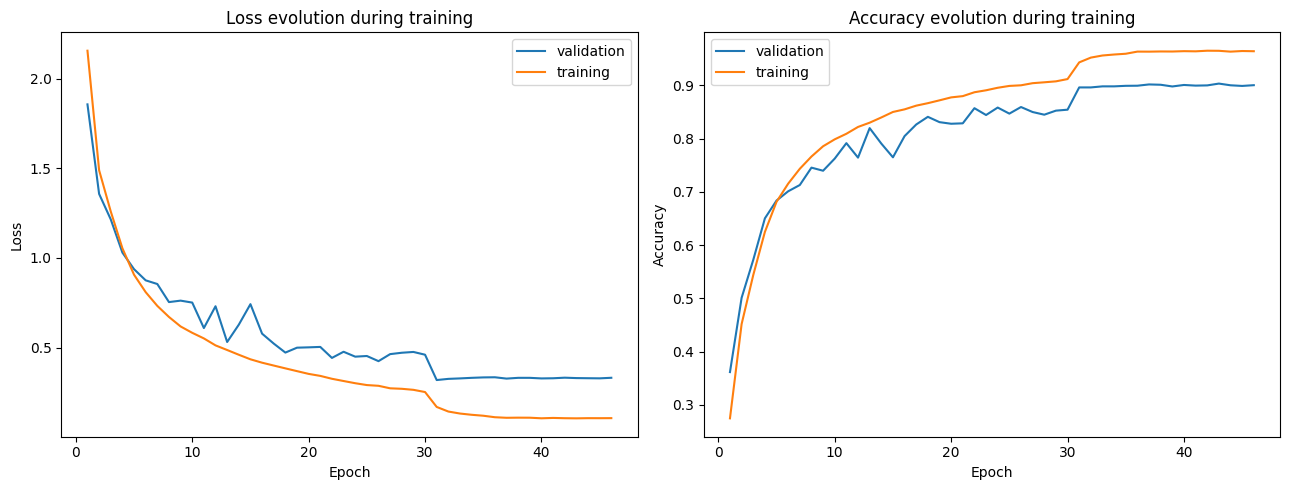

In [6]:
use_gpu = True

# Checkpointing functions
checkpoint_dir = r"C:\Users\benit\OneDrive\Escritorio\ResNet68"
os.makedirs(checkpoint_dir, exist_ok=True)

# Initialize feature map dictionary
feature_maps = {}
if __name__ == "__main__":
    # Hiperparámetros
    batch_size = 128
    epochs = 70
    max_iterations = 600000  # Ajusta según sea necesario
    learning_rate = 0.04
    n_evaluations_per_epoch = 10
    use_gpu = torch.cuda.is_available()
    data_augmentation = True
    weight_decay = 1e-4
    early_stop_thresh = 15
    patience = 3

    # Inicializar el modelo
    model = resnet68()

    print(model)

    # Definir función de pérdida
    criterion = nn.CrossEntropyLoss()

    # Entrenar el modelo
    curves = train_model(
        model=model,
        train_dataset=train_cifar10,
        val_dataset=val_cifar10,
        epochs=epochs,
        max_iterations=max_iterations,
        criterion=criterion,
        batch_size=batch_size,
        lr=learning_rate,
        n_evaluations_per_epoch=n_evaluations_per_epoch,
        early_stop_thresh=early_stop_thresh,
        show_gradients=show_gradients_ResNet_68,
        patience=patience,
        use_gpu=use_gpu,
        data_augmentation=data_augmentation,
        resume_checkpoint=None,  # Establece a una cadena de caracteres para reanudar, por ejemplo, "best_checkpoint_epoch_10.pth"
        weight_decay=weight_decay
    )

    # Plotear curvas de entrenamiento
    show_curves(curves)

### ### Visualizacion de la estructura, conexiones, complejidad y parametros

In [7]:
!pip install ptflops
!pip install torchinfo

In [8]:
import os
import sys
import time
import math
import copy
from math import ceil
from datetime import datetime
from functools import partial
from typing import Any, Callable, List, Optional, Sequence, Union
from dataclasses import dataclass
from io import StringIO

import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
from torchvision.ops import StochasticDepth
from torchvision.ops.misc import Conv2dNormActivation, SqueezeExcitation
from ptflops import get_model_complexity_info
from torchinfo import summary
import matplotlib.pyplot as plt


In [9]:
# Función para imprimir estructura del modelo
def print_model_structure(model, indent=0):
    """Imprime la estructura del modelo mostrando las conexiones entre capas."""
    for name, child in model.named_children():
        print('  ' * indent + f'└─ {name}')
        if list(child.children()):
            print_model_structure(child, indent + 1)
        else:
            params = sum(p.numel() for p in child.parameters())
            print('  ' * (indent + 1) + f'└─ Parameters: {params:,}')

def test(net, checkpoint_path=None):
    # Crear un archivo de texto con la fecha y hora actual
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file = f"model_analysis_{timestamp}.txt"

    # Redirigir la salida estándar a una cadena
    old_stdout = sys.stdout
    output_buffer = StringIO()
    sys.stdout = output_buffer

    try:
        # Cargar el mejor modelo
        if checkpoint_path and os.path.exists(checkpoint_path):
            print(f"Cargando el mejor modelo desde: {checkpoint_path}")
            checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
            net.load_state_dict(checkpoint['model_state_dict'])
            print(f"Modelo cargado de la época: {checkpoint['epoch']}")
        else:
            print("Usando modelo sin entrenar")

        # Mover el modelo a CPU para análisis
        net = net.cpu()
        net.eval()

        print("\n" + "="*50)
        print("ANÁLISIS DEL MODELO")
        print("="*50)

        # Sumario detallado del modelo
        print("\nRESUMEN DETALLADO DEL MODELO:")
        print("-"*50)
        summary_str = str(summary(net,
                input_size=(1, 3, 32, 32),
                col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
                col_width=20,
                row_settings=["var_names"],
                verbose=2))
        print(summary_str)

        # Estructura del modelo y conexiones
        print("\nESTRUCTURA DEL MODELO Y CONEXIONES:")
        print("-"*50)
        print_model_structure(net)

        # No hay MBConv en este modelo, así que omitimos el análisis de conexiones residuales específicas de MBConv

        # Calcular FLOPs y parámetros
        print("\nANÁLISIS DE COMPLEJIDAD:")
        print("-"*50)
        macs, params = get_model_complexity_info(
            net,
            (3, 32, 32),
            as_strings=True,
            print_per_layer_stat=True,
            verbose=True
        )

        print(f'\nComplejidad computacional total: {macs}')
        print(f'Número total de parámetros: {params}')

        # Guardar toda la información en el archivo
        with open(output_file, 'w', encoding='utf-8') as f:
            f.write(output_buffer.getvalue())

        print(f"\nAnálisis guardado en: {output_file}")

    finally:
        # Restaurar la salida estándar
        sys.stdout = old_stdout

if __name__ == "__main__":
    # Crear el modelo
    model = resnet68()

    # Definir la ruta del directorio de checkpoints (ajusta según tu entorno)
    checkpoint_dir = r"C:\Users\benit\OneDrive\Escritorio\ResNet68"
    best_checkpoint = None
    best_epoch = -1

    if os.path.exists(checkpoint_dir):
        for filename in os.listdir(checkpoint_dir):
            if filename.startswith('best_checkpoint_epoch_'):
                try:
                    epoch = int(filename.split('_')[-1].split('.')[0])
                    if epoch > best_epoch:
                        best_epoch = epoch
                        best_checkpoint = filename
                except ValueError:
                    pass

    if best_checkpoint:
        checkpoint_path = os.path.join(checkpoint_dir, best_checkpoint)
        print(f"Encontrado mejor checkpoint: {best_checkpoint}")
    else:
        checkpoint_path = None
        print("No se encontró ningún checkpoint, se analizará el modelo sin entrenamiento.")

    # Ejecutar el test
    test(model, checkpoint_path)


Encontrado mejor checkpoint: best_checkpoint_epoch_31.pth


<ipython-input-9-47a2c06c678e>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))


ResNet(
  1.05 M, 100.000% Params, 155.1 MMac, 99.582% MACs, 
  (conv1): Conv2d(432, 0.041% Params, 442.37 KMac, 0.284% MACs, 3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, 0.003% Params, 32.77 KMac, 0.021% MACs, 16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    51.39 k, 4.906% Params, 52.63 MMac, 33.789% MACs, 
    (0): BasicBlock(
      4.67 k, 0.446% Params, 4.78 MMac, 3.072% MACs, 
      (conv1): Conv2d(2.3 k, 0.220% Params, 2.36 MMac, 1.515% MACs, 16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, 0.003% Params, 32.77 KMac, 0.021% MACs, 16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(2.3 k, 0.220% Params, 2.36 MMac, 1.515% MACs, 16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, 0.003% Params, 32.77 KMac, 0.021% MACs, 16, eps=1e-05, momentum=0.1, affi

### Test

In [10]:
# Definir el directorio donde se guardaron los checkpoints
checkpoint_dir = r"C:\Users\benit\OneDrive\Escritorio\ResNet68"

# Obtener la lista de archivos de checkpoint
checkpoint_files = os.listdir(checkpoint_dir)
checkpoint_files = [f for f in checkpoint_files if f.startswith('best_checkpoint_epoch_') and f.endswith('.pth')]

# Encontrar el checkpoint con el número de época más alto (el mejor modelo)
epochs_in_checkpoints = []
for f in checkpoint_files:
    epoch_str = f.replace('best_checkpoint_epoch_', '').replace('.pth', '')
    try:
        epoch_num = int(epoch_str)
        epochs_in_checkpoints.append((epoch_num, f))
    except ValueError:
        continue

if epochs_in_checkpoints:
    best_epoch, best_checkpoint_file = max(epochs_in_checkpoints)
    checkpoint_path = os.path.join(checkpoint_dir, best_checkpoint_file)
    print(f"Mejor modelo encontrado: {best_checkpoint_file}")
else:
    print("No se encontraron archivos de checkpoint")
    # Manejar el error apropiadamente
    raise FileNotFoundError("No se encontraron archivos de checkpoint.")

model = resnet68()

# Configurar el dispositivo (CPU o GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cargar el checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

# Preparar el conjunto de prueba y el DataLoader


val_test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

# Cargar el conjunto de prueba MNIST
test_cifar10 = torchvision.datasets.CIFAR10(
    root="./cifar10",
    train=False,
    download=True,
    transform=val_test_transform  # Transformaciones para testing
)

# Crear el DataLoader para el conjunto de prueba
test_loader = torch.utils.data.DataLoader(
    test_cifar10,
    batch_size=128,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)



# Definir la función para evaluar TOP1 y TOP5
def evaluate_topk(loader, model, device, k=(1, 5)):
    model.eval()
    topk_accs = [0] * len(k)
    data_count = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, pred = outputs.topk(max(k), dim=1, largest=True, sorted=True)
            pred = pred.t()
            correct = pred.eq(labels.view(1, -1).expand_as(pred))
            for i, kk in enumerate(k):
                correct_k = correct[:kk].reshape(-1).float().sum(0, keepdim=True)
                topk_accs[i] += correct_k.item()
            data_count += labels.size(0)
    topk_accs = [acc / data_count for acc in topk_accs]
    return topk_accs

# Evaluar el modelo en el conjunto de prueba
top1_acc, top5_acc = evaluate_topk(test_loader, model, device, k=(1, 5))

print(f"Precisión TOP1 en el conjunto de prueba: {top1_acc * 100:.2f}%")
print(f"Precisión TOP5 en el conjunto de prueba: {top5_acc * 100:.2f}%")


Mejor modelo encontrado: best_checkpoint_epoch_31.pth


<ipython-input-10-608fdc59bf82>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Files already downloaded and verified
Precisión TOP1 en el conjunto de prueba: 88.66%
Precisión TOP5 en el conjunto de prueba: 99.66%


### UMAP y TSNE


In [11]:
!pip install umap-learn
import seaborn as sns
import umap.umap_ as umap

In [12]:
# Definir el directorio donde se guardaron los checkpoints
checkpoint_dir = r"C:\Users\benit\OneDrive\Escritorio\ResNet68"

# Obtener la lista de archivos de checkpoint
checkpoint_files = os.listdir(checkpoint_dir)
checkpoint_files = [f for f in checkpoint_files if f.startswith('best_checkpoint_epoch_') and f.endswith('.pth')]

# Encontrar el checkpoint con el número de época más alto (el mejor modelo)
epochs_in_checkpoints = []
for f in checkpoint_files:
    epoch_str = f.replace('best_checkpoint_epoch_', '').replace('.pth', '')
    try:
        epoch_num = int(epoch_str)
        epochs_in_checkpoints.append((epoch_num, f))
    except ValueError:
        continue

if epochs_in_checkpoints:
    best_epoch, best_checkpoint_file = max(epochs_in_checkpoints)
    checkpoint_path = os.path.join(checkpoint_dir, best_checkpoint_file)
    print(f"Mejor modelo encontrado: {best_checkpoint_file}")
else:
    print("No se encontraron archivos de checkpoint")
    # Manejar el error apropiadamente
    raise FileNotFoundError("No se encontraron archivos de checkpoint.")

model = resnet68()

# Configurar el dispositivo (CPU o GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cargar el checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

Mejor modelo encontrado: best_checkpoint_epoch_31.pth


<ipython-input-12-aaccdbbc018d>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [13]:
from sklearn.manifold import TSNE
import umap.umap_ as umap


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


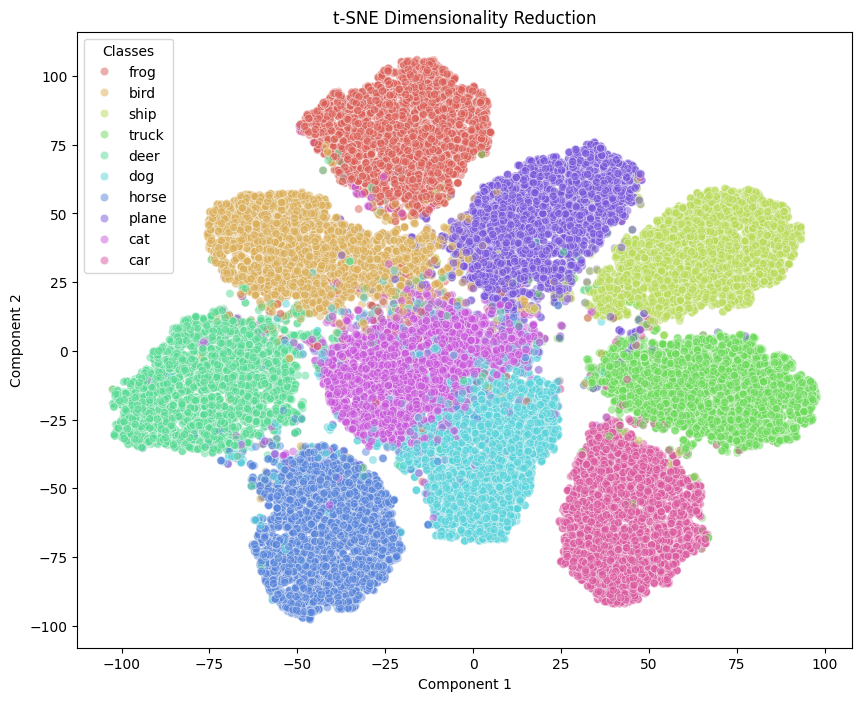

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


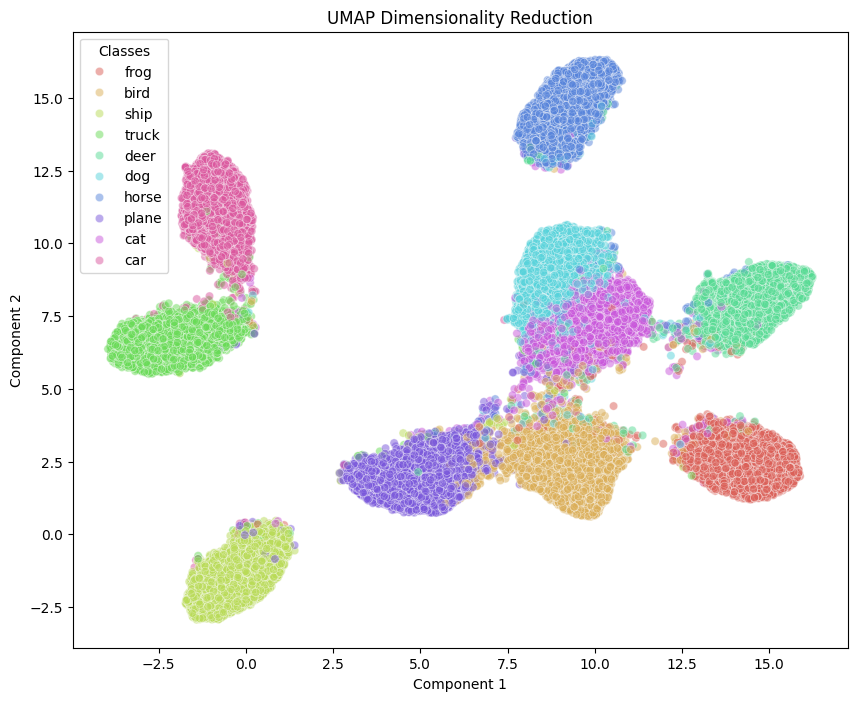

In [14]:
if use_gpu:
    model.cuda()

def get_embeddings(model, dataloader, use_gpu):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for imgs, lbls in dataloader:
            if use_gpu:
                imgs = imgs.cuda()
            # Extraer características pasando las imágenes por el modelo
            # Ajusta estos pasos dependiendo de tu arquitectura
            features = F.relu(model.bn1(model.conv1(imgs)))
            features = model.layer1(features)
            features = model.layer2(features)
            features = model.layer3(features)
            features = model.avgpool(features)
            features = torch.flatten(features, 1)
            features = model.linear(features)
            embeddings.append(features.cpu())
            labels.append(lbls)

    embeddings = torch.cat(embeddings)
    labels = torch.cat(labels)
    return embeddings, labels

full_train_loader = torch.utils.data.DataLoader(
    train_cifar10, batch_size=128, shuffle=False, num_workers=2, pin_memory=use_gpu
)

embeddings, labels = get_embeddings(model, full_train_loader, use_gpu)
embeddings_np = embeddings.numpy()
labels_np = labels.numpy()

#  Convertir etiquetas numéricas a nombres de clases
class_labels = [classes[label] for label in labels_np]

# Visualización con t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_np)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embeddings_tsne[:, 0], y=embeddings_tsne[:, 1],
    hue=class_labels, palette=sns.color_palette("hls", 10),
    legend="full", alpha=0.5
)
plt.title('t-SNE Dimensionality Reduction')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Classes')
plt.show()

# Visualización con UMAP
umap_reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42
)
embeddings_umap = umap_reducer.fit_transform(embeddings_np)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embeddings_umap[:, 0], y=embeddings_umap[:, 1],
    hue=class_labels, palette=sns.color_palette("hls", 10),
    legend="full", alpha=0.5
)
plt.title('UMAP Dimensionality Reduction')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Classes')
plt.show()